<a href="https://colab.research.google.com/github/Qm1ne/GameDesignBalance/blob/main/a3meltalawarga3li.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:

pip install gymnasium


In [3]:
import gym
import numpy as np
from gym import spaces
from collections import defaultdict
import random
from enum import Enum

class AbilityType(Enum):
    REVEAL_OPPONENT_CARD = 0
    REVEAL_NEXT_DECK_CARD = 1
    BONUS_SEVEN_DIAMONDS = 2
    SWAP_ONE_WITH_TABLE = 3
    SWAP_ALL_WITH_TABLE = 4
    SWAP_ONE_WITH_OPPONENT = 5
    SWAP_ALL_WITH_OPPONENT = 6
    REFRESH_ALL_TABLE = 7
    REFRESH_ONE_TABLE = 8
    BONUS_DINARI_MATCH = 9
    BONUS_BARMILA_MATCH = 10
    BONUS_KARTA_MATCH = 11

class ChkobaAbilitiesEnv(gym.Env):
    def __init__(self, num_players=2):
        super(ChkobaAbilitiesEnv, self).__init__()

        self.num_players = num_players
        self.current_player = 0

        # Card representation: 40 cards total
        # Suits: 0=Coins(Dineri), 1=Cups, 2=Swords, 3=Clubs
        # Values: 1-7, J(8), Q(9), K(10)
        self.suits = 4
        self.values_per_suit = 10
        self.total_cards = 40

        # Game state
        self.deck = []
        self.table_cards = []
        self.initial_table_cards = []
        self.player_hands = []
        self.player_captured = []
        self.player_chkobas = []
        self.cards_played_this_round = 0
        self.total_rounds = 0

        # Abilities tracking
        self.abilities_used = []  # Track which abilities have been used per player per round
        self.abilities_available = []  # Available abilities per player
        self.current_revealed_info = {}  # Store revealed information

        # Initialize abilities for each player
        self.reset_abilities()

        # Define observation space - expanded for abilities
        obs_size = 40 + 40 + num_players + num_players + 1 + 1 + 12 + 24  # Added ability tracking
        self.observation_space = spaces.Box(low=0, high=40, shape=(obs_size,), dtype=np.float32)

        # Expanded action space: card actions + ability actions
        self.action_space = spaces.Discrete(60)  # Increased for abilities
        self.current_valid_actions = []

    def reset_abilities(self):
        """Reset abilities for new round"""
        self.abilities_used = [set() for _ in range(self.num_players)]
        self.abilities_available = [list(AbilityType) for _ in range(self.num_players)]
        self.current_revealed_info = {
            'opponent_cards': {},
            'next_deck_card': None
        }

    def _create_deck(self):
        """Create a standard 40-card deck"""
        deck = []
        for suit in range(4):
            for value in range(1, 11):
                deck.append((suit, value))
        return deck

    def _card_to_index(self, card):
        """Convert card tuple to unique index"""
        suit, value = card
        return suit * 10 + (value - 1)

    def _index_to_card(self, index):
        """Convert index back to card tuple"""
        suit = index // 10
        value = (index % 10) + 1
        return (suit, value)

    def _get_card_value(self, card):
        """Get the game value of a card"""
        suit, value = card
        return value

    def reset(self):
        """Reset the game state"""
        # Initialize deck and shuffle
        self.deck = self._create_deck()
        random.shuffle(self.deck)

        # Reset game state
        self.table_cards = []
        self.initial_table_cards = []
        self.player_hands = [[] for _ in range(self.num_players)]
        self.player_captured = [[] for _ in range(self.num_players)]
        self.player_chkobas = [0 for _ in range(self.num_players)]
        self.current_player = 0
        self.cards_played_this_round = 0
        self.total_rounds = 0

        # Reset abilities
        self.reset_abilities()

        # Deal initial cards
        for _ in range(4):
            card = self.deck.pop()
            self.table_cards.append(card)
            self.initial_table_cards.append(card)

        for _ in range(3):
            for player in range(self.num_players):
                self.player_hands[player].append(self.deck.pop())

        observation = self._get_observation()
        return observation, {"initial_table_cards": self.initial_table_cards}

    def _use_ability(self, ability_type, target_index=None):
        """Execute an ability and return its effects"""
        if ability_type in self.abilities_used[self.current_player]:
            return {"error": "Ability already used this round"}

        self.abilities_used[self.current_player].add(ability_type)
        effects = {"ability_used": ability_type.name}

        if ability_type == AbilityType.REVEAL_OPPONENT_CARD:
            opponent = (self.current_player + 1) % self.num_players
            if self.player_hands[opponent]:
                revealed_card = random.choice(self.player_hands[opponent])
                self.current_revealed_info['opponent_cards'][opponent] = revealed_card
                effects['revealed_card'] = revealed_card

        elif ability_type == AbilityType.REVEAL_NEXT_DECK_CARD:
            if self.deck:
                next_card = self.deck[-1]  # Peek at top of deck
                self.current_revealed_info['next_deck_card'] = next_card
                suit, value = next_card
                # Bonus if it's a 6 or 7 (barmila contributors)
                if value in [6, 7]:
                    effects['barmila_bonus'] = 1
                effects['revealed_next_card'] = next_card

        elif ability_type == AbilityType.BONUS_SEVEN_DIAMONDS:
            # This ability gives bonus if 7♦ is captured in the same turn
            effects['seven_diamonds_bonus_ready'] = True

        elif ability_type == AbilityType.SWAP_ONE_WITH_TABLE:
            if target_index is not None and target_index < len(self.player_hands[self.current_player]):
                if self.table_cards:
                    # Swap one card from hand with random table card
                    hand_card = self.player_hands[self.current_player].pop(target_index)
                    table_card = self.table_cards.pop(random.randint(0, len(self.table_cards)-1))
                    self.player_hands[self.current_player].append(table_card)
                    self.table_cards.append(hand_card)
                    effects['swapped'] = {'hand_card': hand_card, 'table_card': table_card}

        elif ability_type == AbilityType.SWAP_ALL_WITH_TABLE:
            # Swap all hand cards with all table cards
            old_hand = self.player_hands[self.current_player][:]
            old_table = self.table_cards[:]
            self.player_hands[self.current_player] = old_table
            self.table_cards = old_hand
            effects['swapped_all'] = {'old_hand': old_hand, 'old_table': old_table}

        elif ability_type == AbilityType.SWAP_ONE_WITH_OPPONENT:
            opponent = (self.current_player + 1) % self.num_players
            if (target_index is not None and
                target_index < len(self.player_hands[self.current_player]) and
                self.player_hands[opponent]):
                # Swap one card with opponent
                my_card = self.player_hands[self.current_player].pop(target_index)
                opp_card = self.player_hands[opponent].pop(random.randint(0, len(self.player_hands[opponent])-1))
                self.player_hands[self.current_player].append(opp_card)
                self.player_hands[opponent].append(my_card)
                effects['swapped_with_opponent'] = {'my_card': my_card, 'opp_card': opp_card}

        elif ability_type == AbilityType.SWAP_ALL_WITH_OPPONENT:
            opponent = (self.current_player + 1) % self.num_players
            # Swap all cards with opponent
            temp = self.player_hands[self.current_player][:]
            self.player_hands[self.current_player] = self.player_hands[opponent][:]
            self.player_hands[opponent] = temp
            effects['swapped_all_with_opponent'] = True

        elif ability_type == AbilityType.REFRESH_ALL_TABLE:
            # Replace all table cards with new ones from deck
            old_table = self.table_cards[:]
            self.deck.extend(self.table_cards)
            random.shuffle(self.deck)
            self.table_cards = []
            for _ in range(min(4, len(self.deck))):
                self.table_cards.append(self.deck.pop())
            effects['refreshed_table'] = {'old': old_table, 'new': self.table_cards[:]}

        elif ability_type == AbilityType.REFRESH_ONE_TABLE:
            if self.table_cards and self.deck:
                # Replace one table card with new one from deck
                old_card = self.table_cards.pop(random.randint(0, len(self.table_cards)-1))
                new_card = self.deck.pop()
                self.table_cards.append(new_card)
                self.deck.append(old_card)
                random.shuffle(self.deck)
                effects['refreshed_one'] = {'old': old_card, 'new': new_card}

        elif ability_type == AbilityType.BONUS_DINARI_MATCH:
            # Gives bonus point when exact Dinari match occurs
            effects['dinari_bonus_ready'] = True

        elif ability_type == AbilityType.BONUS_BARMILA_MATCH:
            # Gives bonus point when exact 6 or 7 match occurs
            effects['barmila_bonus_ready'] = True

        elif ability_type == AbilityType.BONUS_KARTA_MATCH:
            # Gives bonus point when any exact match occurs
            effects['karta_bonus_ready'] = True

        return effects

    def _find_capture_combinations(self, played_card):
        """Find all possible combinations of table cards that can be captured"""
        card_value = self._get_card_value(played_card)
        table_values = [self._get_card_value(card) for card in self.table_cards]
        combinations = []

        # Check for exact matches first
        for i, table_card in enumerate(self.table_cards):
            if self._get_card_value(table_card) == card_value:
                combinations.append([i])

        # Check for sum combinations
        def find_sum_combinations(target, cards_indices, current_combination=[]):
            if target == 0:
                if len(current_combination) > 1:
                    combinations.append(current_combination[:])
                return

            for i in range(len(cards_indices)):
                idx = cards_indices[i]
                card_val = table_values[idx]
                if card_val <= target:
                    current_combination.append(idx)
                    find_sum_combinations(target - card_val, cards_indices[i+1:], current_combination)
                    current_combination.pop()

        available_indices = list(range(len(self.table_cards)))
        find_sum_combinations(card_value, available_indices)

        return combinations

    def _get_valid_actions(self):
        """Get list of valid actions including card plays and abilities"""
        current_hand = self.player_hands[self.current_player]
        valid_actions = []
        action_descriptions = []
        action_id = 0

        # Card play actions
        for card_idx, card in enumerate(current_hand):
            capture_combinations = self._find_capture_combinations(card)

            if capture_combinations:
                for combo_idx, combination in enumerate(capture_combinations):
                    valid_actions.append(action_id)
                    action_descriptions.append({
                        'type': 'card_play',
                        'card_idx': card_idx,
                        'card': card,
                        'combination': combination,
                        'action_type': 'capture'
                    })
                    action_id += 1
            else:
                valid_actions.append(action_id)
                action_descriptions.append({
                    'type': 'card_play',
                    'card_idx': card_idx,
                    'card': card,
                    'combination': None,
                    'action_type': 'place'
                })
                action_id += 1

        # Ability actions (only unused abilities)
        for ability in AbilityType:
            if ability not in self.abilities_used[self.current_player]:
                # Some abilities need target indices
                if ability in [AbilityType.SWAP_ONE_WITH_TABLE, AbilityType.SWAP_ONE_WITH_OPPONENT]:
                    for card_idx in range(len(current_hand)):
                        valid_actions.append(action_id)
                        action_descriptions.append({
                            'type': 'ability',
                            'ability': ability,
                            'target_index': card_idx
                        })
                        action_id += 1
                else:
                    valid_actions.append(action_id)
                    action_descriptions.append({
                        'type': 'ability',
                        'ability': ability,
                        'target_index': None
                    })
                    action_id += 1

        self.current_valid_actions = action_descriptions
        return valid_actions

    def step(self, action):
        """Execute one step in the environment"""
        valid_actions = self._get_valid_actions()

        if action not in valid_actions:
            return self._get_observation(), -10, False, False, {"error": "Invalid action"}

        action_desc = self.current_valid_actions[action]
        reward = 0
        info = {"player": self.current_player}

        if action_desc['type'] == 'ability':
            # Execute ability
            ability_effects = self._use_ability(action_desc['ability'], action_desc['target_index'])
            info.update(ability_effects)

            # Small reward for using abilities strategically
            reward += 0.1

            # Don't change current player for ability actions
            return self._get_observation(), reward, False, False, info

        elif action_desc['type'] == 'card_play':
            # Execute card play
            card_to_play = action_desc['card']
            card_idx = action_desc['card_idx']
            combination = action_desc['combination']

            # Remove card from player's hand
            self.player_hands[self.current_player].pop(card_idx)

            chkoba = False
            captured_cards = []

            if action_desc['action_type'] == 'capture' and combination is not None:
                # Capture the specified combination
                captured_cards = [card_to_play]

                # Apply ability bonuses for matches
                played_suit, played_value = card_to_play
                for idx in combination:
                    table_card = self.table_cards[idx]
                    table_suit, table_value = table_card

                    # Check for exact matches and apply bonuses
                    if played_value == table_value:
                        if AbilityType.BONUS_KARTA_MATCH not in self.abilities_used[self.current_player]:
                            reward += 0.5  # Bonus for any exact match

                        if played_suit == 0 and AbilityType.BONUS_DINARI_MATCH not in self.abilities_used[self.current_player]:
                            reward += 0.5  # Bonus for Dinari match

                        if played_value in [6, 7] and AbilityType.BONUS_BARMILA_MATCH not in self.abilities_used[self.current_player]:
                            reward += 0.5  # Bonus for Barmila match

                # Capture table cards
                for idx in sorted(combination, reverse=True):
                    captured_cards.append(self.table_cards.pop(idx))

                self.player_captured[self.current_player].extend(captured_cards)

                # Calculate capture reward
                reward += self._calculate_capture_reward(captured_cards)

                # Check for seven diamonds bonus
                seven_diamonds = (0, 7)
                if (seven_diamonds in captured_cards and
                    AbilityType.BONUS_SEVEN_DIAMONDS not in self.abilities_used[self.current_player]):
                    reward += 1.0  # Special bonus

                # Check for chkoba
                if len(self.table_cards) == 0:
                    self.player_chkobas[self.current_player] += 1
                    chkoba = True
                    reward += 1.0

            else:
                # Place card on table
                self.table_cards.append(card_to_play)
                reward -= 0.05  # Small penalty for not capturing

            # Update game state
            self.cards_played_this_round += 1

            # Check if round is complete
            if self.cards_played_this_round == self.num_players * 3:
                self._deal_new_round()

            # Move to next player
            previous_player = self.current_player
            self.current_player = (self.current_player + 1) % self.num_players

            # Check if game is over
            terminated = len(self.deck) == 0 and all(len(hand) == 0 for hand in self.player_hands)

            if terminated:
                final_scores = self._calculate_final_scores()
                reward += final_scores[previous_player] * 2
                # Give remaining table cards to last capturer
                last_capturer = self._get_last_capturer()
                if last_capturer is not None:
                    self.player_captured[last_capturer].extend(self.table_cards)

            info.update({
                "action_type": action_desc['action_type'],
                "played_card": card_to_play,
                "captured_cards": captured_cards,
                "chkoba": chkoba,
                "cards_on_table": len(self.table_cards),
            })

        return self._get_observation(), reward, terminated, False, info

    def _calculate_capture_reward(self, captured_cards):
        """Calculate reward for capturing cards with strategic bonuses"""
        if not captured_cards:
            return -0.05

        reward = 0.1 * len(captured_cards)

        for card in captured_cards:
            suit, value = card
            if suit == 0 and value == 7:  # Seven of diamonds
                reward += 1.0
            elif value == 7:  # Other sevens
                reward += 0.5
            elif suit == 0:  # Other diamonds
                reward += 0.25

        return reward

    def _deal_new_round(self):
        """Deal new cards and reset abilities when round is complete"""
        if len(self.deck) >= self.num_players * 3:
            for _ in range(3):
                for player in range(self.num_players):
                    if len(self.deck) > 0:
                        self.player_hands[player].append(self.deck.pop())
            self.cards_played_this_round = 0
            self.total_rounds += 1

            # Reset abilities for new round
            self.reset_abilities()

    def _get_last_capturer(self):
        """Get the player who made the last capture"""
        max_captured = max(len(cards) for cards in self.player_captured)
        for i, cards in enumerate(self.player_captured):
            if len(cards) == max_captured:
                return i
        return 0

    def _calculate_final_scores(self):
        """Calculate final scores based on Chkoba rules"""
        scores = [0] * self.num_players

        for player in range(self.num_players):
            # Chkobas
            scores[player] += self.player_chkobas[player]

            # Il Carta (most cards)
            if len(self.player_captured[player]) > 20:
                scores[player] += 1

            # Il 7ayya (7 of diamonds)
            seven_diamonds = (0, 7)
            if seven_diamonds in self.player_captured[player]:
                scores[player] += 1

            # Il Barmila (sevens and sixes)
            sevens = sum(1 for card in self.player_captured[player] if self._get_card_value(card) == 7)
            sixes = sum(1 for card in self.player_captured[player] if self._get_card_value(card) == 6)
            if sevens >= 3 or (sevens >= 2 and sixes >= 3):
                scores[player] += 1

            # Il Dineri (diamonds)
            diamonds = sum(1 for card in self.player_captured[player] if card[0] == 0)
            if diamonds >= 6:
                scores[player] += 1

        return scores

    def _get_observation(self):
        """Get current observation including ability information"""
        obs = np.zeros(self.observation_space.shape[0])
        idx = 0

        # Table cards (binary encoding)
        for card in self.table_cards:
            card_idx = self._card_to_index(card)
            obs[card_idx] = 1
        idx += 40

        # Current player hand (binary encoding)
        current_hand = self.player_hands[self.current_player]
        for card in current_hand:
            card_idx = self._card_to_index(card)
            obs[idx + card_idx] = 1
        idx += 40

        # Captured cards count for each player
        for player in range(self.num_players):
            obs[idx + player] = len(self.player_captured[player])
        idx += self.num_players

        # Chkoba count for each player
        for player in range(self.num_players):
            obs[idx + player] = self.player_chkobas[player]
        idx += self.num_players

        # Current player
        obs[idx] = self.current_player
        idx += 1

        # Cards remaining in deck
        obs[idx] = len(self.deck)
        idx += 1

        # Abilities available (binary encoding for each ability type)
        for ability in AbilityType:
            if ability not in self.abilities_used[self.current_player]:
                obs[idx + ability.value] = 1
        idx += 12

        # Abilities used by all players (binary encoding)
        for player in range(self.num_players):
            for ability in AbilityType:
                if ability in self.abilities_used[player]:
                    obs[idx + player * 12 + ability.value] = 1
        idx += 24

        return obs

    def render(self, mode='human'):
        """Render the current state including abilities"""
        print(f"\n=== CHKOBA GAME WITH ABILITIES ===")
        print(f"Current Player: {self.current_player}")
        print(f"Round: {self.total_rounds}")
        print(f"Cards in deck: {len(self.deck)}")
        print(f"Table cards: {self.table_cards}")

        # Show available abilities
        available_abilities = [ability for ability in AbilityType
                             if ability not in self.abilities_used[self.current_player]]
        print(f"\nAvailable abilities for Player {self.current_player}: {[ab.name for ab in available_abilities]}")

        # Show revealed information
        if self.current_revealed_info.get('next_deck_card'):
            print(f"Revealed next deck card: {self.current_revealed_info['next_deck_card']}")

        for opp, card in self.current_revealed_info.get('opponent_cards', {}).items():
            print(f"Revealed opponent {opp} card: {card}")

        # Show player information
        for player in range(self.num_players):
            print(f"\nPlayer {player}:")
            print(f"  Hand: {self.player_hands[player]}")
            print(f"  Captured: {len(self.player_captured[player])} cards")
            print(f"  Chkobas: {self.player_chkobas[player]}")
            print(f"  Abilities used this round: {[ab.name for ab in self.abilities_used[player]]}")

        if len(self.deck) == 0 and all(len(hand) == 0 for hand in self.player_hands):
            scores = self._calculate_final_scores()
            print(f"\n=== FINAL SCORES ===")
            for player in range(self.num_players):
                print(f"Player {player}: {scores[player]} points")

In [5]:
import random

if __name__ == "__main__":
    # Création de l'environnement
    env = ChkobaAbilitiesEnv()
    obs, info = env.reset()

    print("Initial observation shape:", obs.shape)
    env.render()

    # Joue quelques coups aléatoires
    for step in range(20):
        valid_actions = env._get_valid_actions()
        if valid_actions:
            action = random.choice(valid_actions)
            obs, reward, terminated, truncated, info = env.step(action)
            print(f"\nStep {step + 1}: Action {action}, Reward {reward:.2f}")
            print(f"Info: {info}")

            env.render()

            if terminated:
                print("\n=== GAME OVER ===")
                env.render()
                break
        else:
            print("Aucune action valide disponible")
            break

Initial observation shape: (122,)

=== CHKOBA GAME WITH ABILITIES ===
Current Player: 0
Round: 0
Cards in deck: 30
Table cards: [(0, 5), (1, 1), (1, 8), (1, 4)]

Available abilities for Player 0: ['REVEAL_OPPONENT_CARD', 'REVEAL_NEXT_DECK_CARD', 'BONUS_SEVEN_DIAMONDS', 'SWAP_ONE_WITH_TABLE', 'SWAP_ALL_WITH_TABLE', 'SWAP_ONE_WITH_OPPONENT', 'SWAP_ALL_WITH_OPPONENT', 'REFRESH_ALL_TABLE', 'REFRESH_ONE_TABLE', 'BONUS_DINARI_MATCH', 'BONUS_BARMILA_MATCH', 'BONUS_KARTA_MATCH']

Player 0:
  Hand: [(0, 6), (3, 9), (3, 3)]
  Captured: 0 cards
  Chkobas: 0
  Abilities used this round: []

Player 1:
  Hand: [(0, 1), (3, 4), (0, 10)]
  Captured: 0 cards
  Chkobas: 0
  Abilities used this round: []

Step 1: Action 3, Reward -0.05
Info: {'player': 0, 'action_type': 'place', 'played_card': (3, 3), 'captured_cards': [], 'chkoba': False, 'cards_on_table': 5}

=== CHKOBA GAME WITH ABILITIES ===
Current Player: 1
Round: 0
Cards in deck: 30
Table cards: [(0, 5), (1, 1), (1, 8), (1, 4), (3, 3)]

Available 

In [6]:
import pickle
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import time
import os
import json
import numpy as np
import random
from enum import Enum

class AbilityType(Enum):
    REVEAL_OPPONENT_CARD = 0
    REVEAL_NEXT_DECK_CARD = 1
    BONUS_SEVEN_DIAMONDS = 2
    SWAP_ONE_WITH_TABLE = 3
    SWAP_ALL_WITH_TABLE = 4
    SWAP_ONE_WITH_OPPONENT = 5
    SWAP_ALL_WITH_OPPONENT = 6
    REFRESH_ALL_TABLE = 7
    REFRESH_ONE_TABLE = 8
    BONUS_DINARI_MATCH = 9
    BONUS_BARMILA_MATCH = 10
    BONUS_KARTA_MATCH = 11

class OptimizedChkobaQLearning:
    def __init__(self, env, learning_rate=0.2, discount_factor=0.9,
                 epsilon=0.8, epsilon_decay=0.998, min_epsilon=0.05):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Optimized Q-table with smaller state space
        self.q_table = defaultdict(lambda: defaultdict(float))

        # Training metrics
        self.training_scores = []
        self.training_rewards = []
        self.epsilon_history = []

        # Ability-specific metrics
        self.ability_usage_count = defaultdict(int)
        self.ability_success_rate = defaultdict(list)
        self.ability_rewards = defaultdict(list)
        self.ability_win_contribution = defaultdict(list)
        self.ability_timing_analysis = defaultdict(list)

        # Game state metrics
        self.chkoba_rates = []
        self.capture_rates = []
        self.strategic_scores = []

    def _simplified_state_key(self, state):
        """Create a much smaller state representation for faster learning"""
        # Only use the most critical information

        # Table cards count and types (simplified)
        table_cards = state[:40]
        table_count = int(np.sum(table_cards))
        table_sevens = int(np.sum(table_cards[6::10]))  # Count of 7s on table
        table_diamonds = int(np.sum(table_cards[0:10]))  # Count of diamonds on table

        # Hand summary
        hand_cards = state[40:80]
        hand_count = int(np.sum(hand_cards))
        hand_sevens = int(np.sum(hand_cards[6::10]))
        hand_diamonds = int(np.sum(hand_cards[0:10]))

        # Captured cards ratio (discretized)
        captured_counts = state[80:80+self.env.num_players]
        my_captured = int(captured_counts[0] // 3)  # Bucket into groups of 3
        opp_captured = int(captured_counts[1] // 3) if len(captured_counts) > 1 else 0

        # Game phase (early/mid/late)
        cards_remaining = int(state[-1])
        game_phase = 0 if cards_remaining > 20 else (1 if cards_remaining > 10 else 2)

        # Current player
        current_player = int(state[-2])

        return (table_count, table_sevens, table_diamonds,
                hand_count, hand_sevens, hand_diamonds,
                my_captured, opp_captured, game_phase, current_player)

    def choose_action(self, state, valid_actions, training=True):
        """Choose action with ability-aware strategy"""
        if training and random.random() < self.epsilon:
            # Smart exploration: prefer abilities early, card plays later
            action_types = []
            for action_id in valid_actions:
                action_desc = self.env.current_valid_actions[action_id]
                action_types.append(action_desc['type'])

            # Bias toward abilities in early game
            cards_remaining = int(state[-1])
            if cards_remaining > 15 and 'ability' in action_types:
                ability_actions = [aid for aid in valid_actions
                                 if self.env.current_valid_actions[aid]['type'] == 'ability']
                if ability_actions and random.random() < 0.3:  # 30% chance to explore abilities
                    return random.choice(ability_actions)

            return random.choice(valid_actions)

        # Exploitation with Q-values
        state_key = self._simplified_state_key(state)
        q_values = {}

        for action_id in valid_actions:
            q_values[action_id] = self.q_table[state_key][action_id]

        if not q_values or all(v == 0 for v in q_values.values()):
            # No experience - use heuristic
            return self._heuristic_action_selection(valid_actions, state)

        return max(q_values, key=q_values.get)

    def _heuristic_action_selection(self, valid_actions, state):
        """Heuristic-based action selection when no Q-values available"""
        best_action = valid_actions[0]
        best_score = -999

        for action_id in valid_actions:
            action_desc = self.env.current_valid_actions[action_id]
            score = 0

            if action_desc['type'] == 'card_play':
                if action_desc['action_type'] == 'capture':
                    # Prioritize captures
                    score += 10
                    combination = action_desc['combination']
                    for idx in combination:
                        card = self.env.table_cards[idx]
                        suit, value = card
                        if suit == 0 and value == 7:  # Seven of diamonds
                            score += 20
                        elif value == 7:  # Other sevens
                            score += 10
                        elif suit == 0:  # Other diamonds
                            score += 5
                else:
                    score = 1  # Place on table

            elif action_desc['type'] == 'ability':
                ability = action_desc['ability']
                # Strategic ability prioritization
                if ability in [AbilityType.REVEAL_OPPONENT_CARD, AbilityType.REVEAL_NEXT_DECK_CARD]:
                    score += 8  # Information is valuable
                elif ability == AbilityType.BONUS_SEVEN_DIAMONDS:
                    # Check if we might capture 7♦
                    if any(card[0] == 0 and card[1] == 7 for card in self.env.table_cards):
                        score += 15
                elif 'SWAP' in ability.name:
                    score += 5  # Moderate utility

            if score > best_score:
                best_score = score
                best_action = action_id

        return best_action

    def update_q_table(self, state, action, reward, next_state, next_valid_actions, terminated):
        """Optimized Q-learning update"""
        state_key = self._simplified_state_key(state)
        current_q = self.q_table[state_key][action]

        if terminated or not next_valid_actions:
            max_next_q = 0
        else:
            next_state_key = self._simplified_state_key(next_state)
            next_q_values = [self.q_table[next_state_key][a] for a in next_valid_actions]
            max_next_q = max(next_q_values) if next_q_values else 0

        # Enhanced learning rate for abilities
        action_desc = self.env.current_valid_actions[action]
        adaptive_lr = self.learning_rate
        if action_desc['type'] == 'ability':
            adaptive_lr *= 1.2  # Learn abilities faster

        new_q = current_q + adaptive_lr * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[state_key][action] = new_q

    def _analyze_ability_performance(self, action_desc, reward, game_state, game_result):
        """Track ability-specific performance metrics"""
        if action_desc['type'] != 'ability':
            return

        ability = action_desc['ability']

        # Track usage
        self.ability_usage_count[ability] += 1

        # Track immediate reward
        self.ability_rewards[ability].append(reward)

        # Track success (positive reward)
        success = reward > 0
        self.ability_success_rate[ability].append(success)

        # Track timing (when in game was ability used)
        cards_remaining = len(self.env.deck)
        total_cards = 40
        game_progress = 1 - (cards_remaining / total_cards)
        self.ability_timing_analysis[ability].append(game_progress)

        # Track contribution to winning
        if game_result is not None:
            final_scores = self.env._calculate_final_scores()
            won = final_scores[0] > final_scores[1] if len(final_scores) > 1 else False
            self.ability_win_contribution[ability].append(won)

    def train_optimized(self, max_time_hours=1, min_episodes=1000, save_interval=500, verbose=True):
        """Optimized training with time limit and ability analysis"""
        print(f"🚀 Starting optimized Q-learning training...")
        print(f"⏱️  Max time: {max_time_hours} hour(s)")
        print(f"🎯 Min episodes: {min_episodes}")

        start_time = time.time()
        max_time_seconds = max_time_hours * 3600
        episode = 0

        # Performance tracking
        recent_scores = deque(maxlen=100)
        recent_rewards = deque(maxlen=100)

        while episode < min_episodes or (time.time() - start_time) < max_time_seconds:
            if (time.time() - start_time) > max_time_seconds and episode >= min_episodes:
                break

            state, info = self.env.reset()
            total_reward = 0
            episode_actions = []
            game_actions = []

            while True:
                valid_actions = self.env._get_valid_actions()
                if not valid_actions:
                    break

                action = self.choose_action(state, valid_actions, training=True)
                action_desc = self.env.current_valid_actions[action]
                episode_actions.append(action_desc['type'])
                game_actions.append(action_desc)

                next_state, reward, terminated, truncated, step_info = self.env.step(action)
                total_reward += reward

                # Analyze ability performance
                game_result = self.env._calculate_final_scores() if terminated else None
                self._analyze_ability_performance(action_desc, reward, state, game_result)

                # Get next valid actions
                next_valid_actions = self.env._get_valid_actions() if not terminated else []

                # Update Q-table
                self.update_q_table(state, action, reward, next_state,
                                   next_valid_actions, terminated)

                state = next_state

                if terminated or truncated:
                    break

            # Decay epsilon more aggressively early on
            if self.epsilon > self.min_epsilon:
                decay_rate = self.epsilon_decay
                if episode < 500:  # Faster decay early
                    decay_rate = 0.995
                self.epsilon *= decay_rate

            # Record metrics
            final_scores = self.env._calculate_final_scores()
            score = final_scores[0] if final_scores else 0

            self.training_scores.append(score)
            self.training_rewards.append(total_reward)
            self.epsilon_history.append(self.epsilon)

            recent_scores.append(score)
            recent_rewards.append(total_reward)

            episode += 1

            # Progress reporting
            if verbose and episode % 200 == 0:
                elapsed_time = time.time() - start_time
                avg_score = np.mean(recent_scores) if recent_scores else 0
                avg_reward = np.mean(recent_rewards) if recent_rewards else 0
                eps_per_sec = episode / elapsed_time

                print(f"Episode {episode:4d} | "
                      f"Score: {avg_score:.2f} | "
                      f"Reward: {avg_reward:.2f} | "
                      f"ε: {self.epsilon:.3f} | "
                      f"EPS: {eps_per_sec:.1f} | "
                      f"Time: {elapsed_time/60:.1f}m")

            # Save checkpoint
            if episode % save_interval == 0:
                self.save_model(f"chkoba_abilities_model_ep{episode}.pkl")

        training_time = time.time() - start_time
        print(f"✅ Training completed!")
        print(f"⏱️  Time: {training_time/60:.1f} minutes")
        print(f"📊 Episodes: {episode}")
        print(f"🎯 Final epsilon: {self.epsilon:.3f}")
        if recent_scores:
            print(f"📈 Avg score (last 100): {np.mean(recent_scores):.2f}")

    def evaluate_abilities(self, episodes=500, verbose=True):
        """Comprehensive ability performance evaluation"""
        print(f"🔬 Evaluating ability performance over {episodes} episodes...")

        # Test with and without abilities
        results = {}

        # Evaluation with abilities
        eval_with_abilities = self._evaluate_performance(episodes, use_abilities=True)
        results['with_abilities'] = eval_with_abilities

        # Evaluation without abilities (baseline)
        eval_without_abilities = self._evaluate_performance(episodes, use_abilities=False)
        results['without_abilities'] = eval_without_abilities

        # Calculate ability impact
        ability_impact = {
            'win_rate_improvement': eval_with_abilities['win_rate'] - eval_without_abilities['win_rate'],
            'score_improvement': eval_with_abilities['avg_score'] - eval_without_abilities['avg_score'],
            'chkoba_improvement': eval_with_abilities['avg_chkobas'] - eval_without_abilities['avg_chkobas']
        }
        results['ability_impact'] = ability_impact

        if verbose:
            print(f"\n📊 ABILITY EVALUATION RESULTS:")
            print(f"{'='*50}")
            print(f"With Abilities    - Win Rate: {eval_with_abilities['win_rate']:.1f}%, Avg Score: {eval_with_abilities['avg_score']:.2f}")
            print(f"Without Abilities - Win Rate: {eval_without_abilities['win_rate']:.1f}%, Avg Score: {eval_without_abilities['avg_score']:.2f}")
            print(f"{'='*50}")
            print(f"🎯 Impact Analysis:")
            print(f"   Win Rate Improvement: {ability_impact['win_rate_improvement']:+.1f}%")
            print(f"   Score Improvement: {ability_impact['score_improvement']:+.2f}")
            print(f"   Chkoba Improvement: {ability_impact['chkoba_improvement']:+.2f}")

        return results

    def _evaluate_performance(self, episodes, use_abilities=True):
        """Evaluate performance with or without abilities"""
        original_epsilon = self.epsilon
        self.epsilon = 0  # No exploration during evaluation

        scores = []
        rewards = []
        chkobas = []
        wins = 0

        for episode in range(episodes):
            state, _ = self.env.reset()
            total_reward = 0

            while True:
                valid_actions = self.env._get_valid_actions()
                if not valid_actions:
                    break

                if self.env.current_player == 0:
                    # Our agent
                    if not use_abilities:
                        # Filter out ability actions
                        card_actions = []
                        for action_id in valid_actions:
                            action_desc = self.env.current_valid_actions[action_id]
                            if action_desc['type'] == 'card_play':
                                card_actions.append(action_id)
                        valid_actions = card_actions if card_actions else valid_actions

                    action = self.choose_action(state, valid_actions, training=False)
                else:
                    # Random opponent
                    action = random.choice(valid_actions)

                next_state, reward, terminated, truncated, info = self.env.step(action)

                if self.env.current_player == 1:  # Our agent's turn ended
                    total_reward += reward

                state = next_state

                if terminated or truncated:
                    break

            final_scores = self.env._calculate_final_scores()
            scores.append(final_scores[0])
            rewards.append(total_reward)
            chkobas.append(self.env.player_chkobas[0])

            if len(final_scores) > 1 and final_scores[0] > final_scores[1]:
                wins += 1

        self.epsilon = original_epsilon

        return {
            'win_rate': wins / episodes * 100,
            'avg_score': np.mean(scores),
            'avg_chkobas': np.mean(chkobas),
            'avg_reward': np.mean(rewards),
            'scores': scores,
            'rewards': rewards
        }

    def analyze_ability_statistics(self):
        """Generate detailed ability usage statistics"""
        print(f"\n🎯 DETAILED ABILITY ANALYSIS:")
        print(f"{'='*60}")

        for ability in AbilityType:
            if ability in self.ability_usage_count:
                usage_count = self.ability_usage_count[ability]
                success_rate = np.mean(self.ability_success_rate[ability]) * 100 if self.ability_success_rate[ability] else 0
                avg_reward = np.mean(self.ability_rewards[ability]) if self.ability_rewards[ability] else 0
                win_rate = np.mean(self.ability_win_contribution[ability]) * 100 if self.ability_win_contribution[ability] else 0
                avg_timing = np.mean(self.ability_timing_analysis[ability]) if self.ability_timing_analysis[ability] else 0

                print(f"\n{ability.name}:")
                print(f"  Usage Count: {usage_count}")
                print(f"  Success Rate: {success_rate:.1f}%")
                print(f"  Avg Reward: {avg_reward:.3f}")
                print(f"  Win Contribution: {win_rate:.1f}%")
                print(f"  Avg Timing: {avg_timing:.2f} (0=early, 1=late)")
            else:
                print(f"\n{ability.name}: Not used")

    def visualize_ability_performance(self, save_plots=True):
        """Create visualizations for ability performance"""
        if not self.ability_usage_count:
            print("No ability data to visualize!")
            return

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Chkoba Abilities Performance Analysis', fontsize=16, fontweight='bold')

        # 1. Ability Usage Count
        abilities = list(self.ability_usage_count.keys())
        usage_counts = list(self.ability_usage_count.values())

        axes[0, 0].bar([ab.name.replace('_', '\n') for ab in abilities], usage_counts, color='skyblue')
        axes[0, 0].set_title('Ability Usage Frequency')
        axes[0, 0].set_ylabel('Usage Count')
        axes[0, 0].tick_params(axis='x', rotation=45)

        # 2. Success Rates
        success_rates = []
        ability_names = []
        for ability in abilities:
            if self.ability_success_rate[ability]:
                success_rates.append(np.mean(self.ability_success_rate[ability]) * 100)
                ability_names.append(ability.name.replace('_', '\n'))

        if success_rates:
            axes[0, 1].bar(ability_names, success_rates, color='lightgreen')
            axes[0, 1].set_title('Ability Success Rates (%)')
            axes[0, 1].set_ylabel('Success Rate (%)')
            axes[0, 1].tick_params(axis='x', rotation=45)

        # 3. Average Rewards
        avg_rewards = []
        reward_names = []
        for ability in abilities:
            if self.ability_rewards[ability]:
                avg_rewards.append(np.mean(self.ability_rewards[ability]))
                reward_names.append(ability.name.replace('_', '\n'))

        if avg_rewards:
            colors = ['green' if r > 0 else 'red' for r in avg_rewards]
            axes[1, 0].bar(reward_names, avg_rewards, color=colors, alpha=0.7)
            axes[1, 0].set_title('Average Reward per Ability')
            axes[1, 0].set_ylabel('Average Reward')
            axes[1, 0].tick_params(axis='x', rotation=45)
            axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)

        # 4. Win Contribution
        win_contributions = []
        win_names = []
        for ability in abilities:
            if self.ability_win_contribution[ability]:
                win_contributions.append(np.mean(self.ability_win_contribution[ability]) * 100)
                win_names.append(ability.name.replace('_', '\n'))

        if win_contributions:
            axes[1, 1].bar(win_names, win_contributions, color='gold', alpha=0.8)
            axes[1, 1].set_title('Win Contribution Rate (%)')
            axes[1, 1].set_ylabel('Win Rate (%)')
            axes[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()

        if save_plots:
            os.makedirs('plots', exist_ok=True)
            plt.savefig('plots/chkoba_abilities_analysis.png', dpi=300, bbox_inches='tight')
            print("📊 Ability analysis plots saved to 'plots/chkoba_abilities_analysis.png'")

        plt.show()

    def save_model(self, filename):
        """Save model with ability analytics"""
        model_data = {
            'q_table': dict(self.q_table),
            'training_scores': self.training_scores,
            'training_rewards': self.training_rewards,
            'epsilon_history': self.epsilon_history,
            'ability_usage_count': dict(self.ability_usage_count),
            'ability_success_rate': dict(self.ability_success_rate),
            'ability_rewards': dict(self.ability_rewards),
            'ability_win_contribution': dict(self.ability_win_contribution),
            'ability_timing_analysis': dict(self.ability_timing_analysis),
            'hyperparameters': {
                'learning_rate': self.learning_rate,
                'discount_factor': self.discount_factor,
                'epsilon': self.epsilon,
                'epsilon_decay': self.epsilon_decay,
                'min_epsilon': self.min_epsilon
            }
        }

        os.makedirs('models', exist_ok=True)
        filepath = os.path.join('models', filename)

        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)

        print(f"💾 Model with ability analytics saved to {filepath}")

# Usage example for testing
if __name__ == "__main__":
    # This would be used with the ChkobaAbilitiesEnv
    pass

In [9]:
#!/usr/bin/env python3
"""
Main script for training and evaluating Chkoba Q-learning with abilities
"""

import os
import time
import json
from datetime import datetime

from chkoba_abilities_env import ChkobaAbilitiesEnv   # ton env
from chkoba_qlearning import ChkobaQLearning               # ton agent

def run_experiment():
    print("🎮 CHKOBA + ABILITIES + Q-LEARNING")
    print("="*60)
    print(f"📅 Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    # 1️⃣ Initialiser l’environnement
    env = ChkobaAbilitiesEnv(num_players=2)

    # 2️⃣ Créer l’agent Q-learning
    agent = ChkobaQLearning(
        env=env,
        learning_rate=0.25,
        discount_factor=0.85,
        epsilon=0.7,
        epsilon_decay=0.998,
        min_epsilon=0.05
    )

    # 3️⃣ Phase entraînement
    print("\n🚀 Training agent...")
    start_time = time.time()
    agent.train(
        num_episodes=1500,
        save_interval=300,
        verbose=True
    )
    training_time = time.time() - start_time
    print(f"✅ Training done in {training_time/60:.1f} minutes")

    # 4️⃣ Analyse abilities
    print("\n🔬 Ability statistics:")
    if hasattr(agent, "analyze_ability_statistics"):
        agent.analyze_ability_statistics()

    # 5️⃣ Évaluation
    print("\n📊 Evaluating agent...")
    if hasattr(agent, "evaluate_abilities"):
        eval_results = agent.evaluate_abilities(episodes=200, verbose=True)
    else:
        eval_results = {"avg_reward": agent.evaluate(episodes=200)}

    # 6️⃣ Générer rapport JSON
    os.makedirs("reports", exist_ok=True)
    report = {
        "timestamp": datetime.now().isoformat(),
        "training_time_minutes": training_time/60,
        "final_epsilon": agent.epsilon,
        "eval_results": eval_results
    }
    report_name = f"chkoba_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(os.path.join("reports", report_name), "w") as f:
        json.dump(report, f, indent=2)

    print(f"💾 Report saved to reports/{report_name}")

    # 7️⃣ Visualisation
    if hasattr(agent, "visualize_ability_performance"):
        print("\n📊 Generating ability performance plots...")
        agent.visualize_ability_performance(save_plots=True)

    # 8️⃣ Sauvegarde modèle
    model_name = f"chkoba_final_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl"
    agent.save_model(model_name)

    print("\n🎉 EXPERIMENT COMPLETED")
    print("="*60)
    return agent, eval_results


if __name__ == "__main__":
    run_experiment()


ModuleNotFoundError: No module named 'chkoba_env_with_abilities'

In [ ]:
import numpy as np
import time
import json
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import random

class ChkobaAbilityAnalyzer:
    """Analyseur spécialisé pour les abilities avec Q-Learning optimisé"""

    def __init__(self, env):
        self.env = env
        self.q_table = defaultdict(lambda: defaultdict(float))

        # Paramètres optimisés pour convergence rapide vers 100%
        self.learning_rate = 0.5          # Très élevé pour apprentissage rapide
        self.discount_factor = 0.95       # Privilégie les récompenses futures
        self.epsilon = 1.0               # Exploration maximale au début
        self.epsilon_decay = 0.9995      # Décroissance très lente
        self.min_epsilon = 0.01          # Minimum très bas pour exploitation

        # Tracking spécialisé pour abilities
        self.ability_effects = defaultdict(list)
        self.ability_success_rates = defaultdict(list)
        self.ability_usage_per_round = defaultdict(int)
        self.round_rewards = []
        self.win_rates_history = []

        # Statistiques détaillées par ability
        self.ability_detailed_stats = {
            'reveal_opponent_card': {'rewards': [], 'contexts': [], 'outcomes': []},
            'reveal_next_deck_card': {'rewards': [], 'contexts': [], 'outcomes': [], 'bonus_triggered': 0},
            'bonus_seven_diamonds': {'rewards': [], 'contexts': [], 'outcomes': []},
            'swap_one_with_table': {'rewards': [], 'contexts': [], 'outcomes': []},
            'swap_all_with_table': {'rewards': [], 'contexts': [], 'outcomes': []},
            'swap_one_with_opponent': {'rewards': [], 'contexts': [], 'outcomes': []},
            'swap_all_with_opponent': {'rewards': [], 'contexts': [], 'outcomes': []},
            'refresh_table_all': {'rewards': [], 'contexts': [], 'outcomes': []},
            'refresh_table_one': {'rewards': [], 'contexts': [], 'outcomes': []},
            'bonus_dinari_match': {'rewards': [], 'contexts': [], 'outcomes': []},
            'bonus_barmila_match': {'rewards': [], 'contexts': [], 'outcomes': []},
            'bonus_karta_match': {'rewards': [], 'contexts': [], 'outcomes': []}
        }

    def get_state_representation(self):
        """Représentation d'état optimisée pour Q-Learning"""
        # Simplifié pour convergence rapide
        hand_size = len(self.env.players[self.env.current_player].hand)
        table_size = len(self.env.table_cards)
        score_diff = (self.env.players[0].score - self.env.players[1].score)

        # Normalisation
        state = (
            min(hand_size, 4),           # Taille main (0-4)
            min(table_size, 8),          # Taille table (0-8)
            max(-10, min(10, score_diff)) + 10  # Différence score (-10 à +10, normalisé 0-20)
        )
        return state

    def select_action_with_forced_ability(self, available_actions):
        """Sélection d'action avec utilisation forcée d'ability quand possible"""
        current_state = self.get_state_representation()

        # Séparer abilities et actions normales
        ability_actions = []
        card_actions = []

        for action_id in available_actions:
            action_info = self.env.current_valid_actions[action_id]
            if action_info['type'] == 'ability':
                ability_actions.append(action_id)
            else:
                card_actions.append(action_id)

        # FORCER l'utilisation d'ability si disponible et nouveau tour
        if ability_actions and self._is_new_card_round():
            # Sélection intelligente d'ability avec Q-Learning
            if random.random() < self.epsilon:
                # Exploration: choisir aléatoirement parmi les abilities
                chosen_action = random.choice(ability_actions)
            else:
                # Exploitation: choisir la meilleure ability selon Q-table
                best_ability = None
                best_q_value = float('-inf')

                for action_id in ability_actions:
                    q_value = self.q_table[current_state][action_id]
                    if q_value > best_q_value:
                        best_q_value = q_value
                        best_ability = action_id

                chosen_action = best_ability if best_ability else random.choice(ability_actions)

            # Enregistrer l'utilisation
            action_info = self.env.current_valid_actions[chosen_action]
            ability_name = action_info.get('ability_name', 'unknown')
            self.ability_usage_per_round[ability_name] += 1

            return chosen_action

        # Si pas d'ability ou pas nouveau tour, action normale avec Q-Learning
        if random.random() < self.epsilon:
            return random.choice(available_actions)
        else:
            best_action = None
            best_q_value = float('-inf')

            for action_id in available_actions:
                q_value = self.q_table[current_state][action_id]
                if q_value > best_q_value:
                    best_q_value = q_value
                    best_action = action_id

            return best_action if best_action else random.choice(available_actions)

    def _is_new_card_round(self):
        """Détecte si c'est un nouveau tour de cartes"""
        # Logique pour détecter nouveau tour (quand joueur reçoit nouvelles cartes)
        current_player = self.env.players[self.env.current_player]
        return len(current_player.hand) == 4  # Nouvelles cartes distribuées

    def train_for_perfect_win_rate(self, max_time_minutes=45):
        """Entraînement intensif pour atteindre 100% de victoire"""
        print("🎯 ENTRAÎNEMENT POUR 100% DE VICTOIRE")
        print("=" * 60)
        print("🔮 Utilisation forcée d'abilities à chaque nouveau tour")
        print("⚡ Optimisé pour convergence rapide")

        start_time = time.time()
        max_time_seconds = max_time_minutes * 60

        episode = 0
        consecutive_wins = 0
        best_win_streak = 0
        target_win_rate = 100.0
        evaluation_interval = 100

        win_rates_over_time = []
        ability_usage_evolution = defaultdict(list)

        while time.time() - start_time < max_time_seconds:
            episode += 1
            episode_start = time.time()

            # Reset environnement
            state, info = self.env.reset()
            done = False
            episode_reward = 0
            abilities_used_this_episode = 0

            states_actions_rewards = []  # Pour mise à jour Q-table

            while not done:
                current_state = self.get_state_representation()
                available_actions = self.env._get_valid_actions()

                # Sélection action avec ability forcée
                action = self.select_action_with_forced_ability(available_actions)

                # Enregistrement pré-action
                action_info = self.env.current_valid_actions[action]
                if action_info['type'] == 'ability':
                    abilities_used_this_episode += 1
                    ability_name = action_info.get('ability_name', 'unknown')

                    # Contexte pré-action
                    pre_context = {
                        'hand_size': len(self.env.players[self.env.current_player].hand),
                        'table_size': len(self.env.table_cards),
                        'score': self.env.players[self.env.current_player].score,
                        'opponent_score': self.env.players[1-self.env.current_player].score
                    }

                # Exécution action
                next_state, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated

                # Bonus récompense pour utilisation d'ability
                if action_info['type'] == 'ability':
                    ability_reward = reward + 0.5  # Bonus pour utilisation ability

                    # Bonus spéciaux selon l'ability
                    if 'reveal_next_deck_card' in action_info.get('ability_name', ''):
                        if info.get('deck_card_is_six_or_seven', False):
                            ability_reward += 1.0
                            self.ability_detailed_stats['reveal_next_deck_card']['bonus_triggered'] += 1

                    # Enregistrement effet
                    post_context = {
                        'hand_size': len(self.env.players[self.env.current_player].hand),
                        'table_size': len(self.env.table_cards),
                        'score': self.env.players[self.env.current_player].score,
                        'opponent_score': self.env.players[1-self.env.current_player].score
                    }

                    effect = {
                        'reward': ability_reward,
                        'pre_context': pre_context,
                        'post_context': post_context,
                        'info': info
                    }

                    self.ability_detailed_stats[ability_name]['rewards'].append(ability_reward)
                    self.ability_detailed_stats[ability_name]['contexts'].append(pre_context)
                    self.ability_detailed_stats[ability_name]['outcomes'].append(effect)

                    reward = ability_reward

                # Stockage pour Q-Learning
                states_actions_rewards.append((current_state, action, reward))
                episode_reward += reward

            # Mise à jour Q-table (Q-Learning rétrograde)
            for i, (state, action, reward) in enumerate(states_actions_rewards):
                # Récompense cumulative future
                future_reward = sum([r for _, _, r in states_actions_rewards[i+1:]])
                discounted_future = future_reward * (self.discount_factor ** (len(states_actions_rewards) - i - 1))

                # Mise à jour Q-value
                old_q = self.q_table[state][action]
                self.q_table[state][action] = old_q + self.learning_rate * (reward + discounted_future - old_q)

            # Tracking victoire
            player_won = (self.env.players[0].score > self.env.players[1].score)
            if player_won:
                consecutive_wins += 1
                best_win_streak = max(best_win_streak, consecutive_wins)
            else:
                consecutive_wins = 0

            self.round_rewards.append(episode_reward)

            # Décroissance epsilon
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

            # Évaluation périodique
            if episode % evaluation_interval == 0:
                evaluation_start = time.time()

                # Test sur 50 parties pour win rate
                test_wins = 0
                for _ in range(50):
                    test_state, _ = self.env.reset()
                    test_done = False

                    while not test_done:
                        test_actions = self.env._get_valid_actions()
                        # Exploitation pure pour évaluation
                        test_state_rep = self.get_state_representation()

                        best_action = None
                        best_q = float('-inf')
                        for action_id in test_actions:
                            q_val = self.q_table[test_state_rep][action_id]
                            if q_val > best_q:
                                best_q = q_val
                                best_action = action_id

                        if best_action is None:
                            best_action = random.choice(test_actions)

                        _, _, test_terminated, test_truncated, _ = self.env.step(best_action)
                        test_done = test_terminated or test_truncated

                    if self.env.players[0].score > self.env.players[1].score:
                        test_wins += 1

                current_win_rate = (test_wins / 50) * 100
                win_rates_over_time.append((episode, current_win_rate))
                self.win_rates_history.append(current_win_rate)

                # Statistiques abilities
                total_abilities_used = sum(self.ability_usage_per_round.values())

                elapsed_time = time.time() - start_time
                print(f"Épisode {episode:5d} | Win Rate: {current_win_rate:5.1f}% | "
                      f"Streak: {consecutive_wins:3d} | Abilities: {total_abilities_used:4d} | "
                      f"Temps: {elapsed_time/60:4.1f}min | ε: {self.epsilon:.3f}")

                # Arrêt si objectif atteint
                if current_win_rate >= target_win_rate:
                    print(f"🎉 OBJECTIF ATTEINT! 100% de victoire en {episode} épisodes!")
                    break

                # Éviter timeout sur évaluation
                evaluation_time = time.time() - evaluation_start
                if evaluation_time > 30:  # Max 30s d'évaluation
                    print("⚠️  Évaluation limitée pour respecter le timing")

        training_time = time.time() - start_time
        final_win_rate = self.win_rates_history[-1] if self.win_rates_history else 0

        print(f"\n✅ ENTRAÎNEMENT TERMINÉ")
        print(f"🕒 Temps: {training_time/60:.1f} minutes")
        print(f"📈 Épisodes: {episode}")
        print(f"🏆 Win Rate Final: {final_win_rate:.1f}%")
        print(f"🔥 Meilleur Streak: {best_win_streak}")
        print(f"🔮 Abilities Utilisées: {sum(self.ability_usage_per_round.values())}")

        return {
            'episodes': episode,
            'final_win_rate': final_win_rate,
            'best_streak': best_win_streak,
            'training_time': training_time,
            'abilities_total': sum(self.ability_usage_per_round.values()),
            'win_rates_history': win_rates_over_time
        }

    def analyze_ability_effectiveness(self):
        """Analyse complète de l'efficacité des abilities"""
        print("\n🔍 ANALYSE DÉTAILLÉE DES ABILITIES")
        print("=" * 70)

        # Analyse générale
        total_abilities = sum(self.ability_usage_per_round.values())
        print(f"📊 Total abilities utilisées: {total_abilities}")

        if total_abilities == 0:
            print("⚠️  Aucune ability utilisée!")
            return

        # Ranking des abilities par utilisation
        sorted_abilities = sorted(self.ability_usage_per_round.items(),
                                key=lambda x: x[1], reverse=True)

        print(f"\n🏆 RANKING PAR UTILISATION:")
        for i, (ability, count) in enumerate(sorted_abilities, 1):
            percentage = (count / total_abilities) * 100
            print(f"{i:2d}. {ability:<25} {count:4d} utilisations ({percentage:5.1f}%)")

        # Analyse d'efficacité par ability
        print(f"\n⚡ ANALYSE D'EFFICACITÉ:")
        print(f"{'Ability':<25} {'Utilisé':<8} {'Récompense Moy':<15} {'Efficacité':<12}")
        print("-" * 70)

        effectiveness_ranking = []

        for ability_name, stats in self.ability_detailed_stats.items():
            if stats['rewards']:
                avg_reward = np.mean(stats['rewards'])
                usage_count = len(stats['rewards'])
                effectiveness = avg_reward * usage_count  # Score d'efficacité globale

                effectiveness_ranking.append((ability_name, usage_count, avg_reward, effectiveness))

                print(f"{ability_name:<25} {usage_count:<8} {avg_reward:<15.3f} {effectiveness:<12.2f}")

        # Top 3 des abilities les plus efficaces
        effectiveness_ranking.sort(key=lambda x: x[3], reverse=True)

        print(f"\n🌟 TOP 3 ABILITIES LES PLUS EFFICACES:")
        for i, (ability, usage, avg_reward, effectiveness) in enumerate(effectiveness_ranking[:3], 1):
            print(f"{i}. {ability}")
            print(f"   Utilisation: {usage} fois")
            print(f"   Récompense moyenne: {avg_reward:.3f}")
            print(f"   Score d'efficacité: {effectiveness:.2f}")

            # Analyse spécifique
            if ability == 'reveal_next_deck_card':
                bonus_rate = (self.ability_detailed_stats[ability]['bonus_triggered'] / max(usage, 1)) * 100
                print(f"   Bonus 6/7 déclenché: {bonus_rate:.1f}% du temps")

        # Analyse contextuelle
        print(f"\n🎯 ANALYSE CONTEXTUELLE:")

        for ability_name, stats in self.ability_detailed_stats.items():
            if len(stats['contexts']) >= 5:  # Au moins 5 utilisations
                contexts = stats['contexts']

                # Moyennes des contextes
                avg_hand_size = np.mean([c['hand_size'] for c in contexts])
                avg_table_size = np.mean([c['table_size'] for c in contexts])
                avg_score_diff = np.mean([c['score'] - c['opponent_score'] for c in contexts])

                print(f"{ability_name}:")
                print(f"   Contexte typique - Main: {avg_hand_size:.1f}, Table: {avg_table_size:.1f}, Score diff: {avg_score_diff:+.1f}")

    def compare_abilities_impact(self):
        """Comparaison de l'impact des différentes abilities"""
        print("\n🔬 COMPARAISON D'IMPACT DES ABILITIES")
        print("=" * 60)

        # Classification des abilities par type d'effet
        ability_categories = {
            'Information': ['reveal_opponent_card', 'reveal_next_deck_card'],
            'Échange': ['swap_one_with_table', 'swap_all_with_table',
                       'swap_one_with_opponent', 'swap_all_with_opponent'],
            'Modification': ['refresh_table_all', 'refresh_table_one'],
            'Bonus': ['bonus_seven_diamonds', 'bonus_dinari_match',
                     'bonus_barmila_match', 'bonus_karta_match']
        }

        category_stats = {}

        for category, abilities in ability_categories.items():
            total_usage = 0
            total_reward = 0
            ability_count = 0

            for ability in abilities:
                if ability in self.ability_detailed_stats:
                    stats = self.ability_detailed_stats[ability]
                    if stats['rewards']:
                        total_usage += len(stats['rewards'])
                        total_reward += sum(stats['rewards'])
                        ability_count += 1

            if ability_count > 0:
                category_stats[category] = {
                    'total_usage': total_usage,
                    'avg_reward': total_reward / total_usage if total_usage > 0 else 0,
                    'abilities_count': ability_count
                }

        # Affichage par catégorie
        for category, stats in category_stats.items():
            print(f"📁 {category}:")
            print(f"   Utilisation totale: {stats['total_usage']}")
            print(f"   Récompense moyenne: {stats['avg_reward']:.3f}")
            print(f"   Nombre d'abilities: {stats['abilities_count']}")
            print()

        # Recommandations
        print("💡 RECOMMANDATIONS:")

        if category_stats:
            best_category = max(category_stats.items(), key=lambda x: x[1]['avg_reward'])
            print(f"🏆 Catégorie la plus efficace: {best_category[0]}")
            print(f"   → Privilégier ces abilities pour de meilleures performances")

            most_used_category = max(category_stats.items(), key=lambda x: x[1]['total_usage'])
            if most_used_category[0] != best_category[0]:
                print(f"📊 Catégorie la plus utilisée: {most_used_category[0]}")
                print(f"   → L'IA préfère naturellement cette catégorie")

    def create_ability_visualization(self, save_path='ability_analysis.png'):
        """Création de visualisations pour l'analyse des abilities"""
        try:
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

            # 1. Win Rate Evolution
            if self.win_rates_history:
                episodes = range(len(self.win_rates_history))
                ax1.plot(episodes, self.win_rates_history, 'b-', linewidth=2)
                ax1.axhline(y=100, color='r', linestyle='--', alpha=0.7, label='Objectif 100%')
                ax1.set_title('Évolution du Win Rate')
                ax1.set_xlabel('Évaluations')
                ax1.set_ylabel('Win Rate (%)')
                ax1.grid(True, alpha=0.3)
                ax1.legend()

            # 2. Usage des Abilities
            if self.ability_usage_per_round:
                abilities = list(self.ability_usage_per_round.keys())
                usage_counts = list(self.ability_usage_per_round.values())

                # Troncature des noms pour lisibilité
                short_names = [name.replace('_', ' ').title()[:15] + '...' if len(name) > 15
                             else name.replace('_', ' ').title() for name in abilities]

                ax2.bar(range(len(abilities)), usage_counts, color='skyblue', alpha=0.7)
                ax2.set_title('Utilisation des Abilities')
                ax2.set_xlabel('Abilities')
                ax2.set_ylabel('Nombre d\'utilisations')
                ax2.set_xticks(range(len(abilities)))
                ax2.set_xticklabels(short_names, rotation=45, ha='right')

            # 3. Efficacité des Abilities
            ability_rewards = {}
            for ability_name, stats in self.ability_detailed_stats.items():
                if stats['rewards']:
                    ability_rewards[ability_name] = np.mean(stats['rewards'])

            if ability_rewards:
                abilities = list(ability_rewards.keys())
                rewards = list(ability_rewards.values())
                short_names = [name.replace('_', ' ').title()[:15] + '...' if len(name) > 15
                             else name.replace('_', ' ').title() for name in abilities]

                colors = ['green' if r > 0.5 else 'orange' if r > 0 else 'red' for r in rewards]
                ax3.bar(range(len(abilities)), rewards, color=colors, alpha=0.7)
                ax3.set_title('Efficacité Moyenne des Abilities')
                ax3.set_xlabel('Abilities')
                ax3.set_ylabel('Récompense Moyenne')
                ax3.set_xticks(range(len(abilities)))
                ax3.set_xticklabels(short_names, rotation=45, ha='right')
                ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)

            # 4. Rewards Evolution
            if self.round_rewards:
                # Moyenne mobile pour lisser
                window_size = min(50, len(self.round_rewards) // 10)
                if window_size > 0:
                    moving_avg = []
                    for i in range(len(self.round_rewards)):
                        start_idx = max(0, i - window_size + 1)
                        moving_avg.append(np.mean(self.round_rewards[start_idx:i+1]))

                    ax4.plot(self.round_rewards, alpha=0.3, color='gray', label='Récompenses brutes')
                    ax4.plot(moving_avg, color='blue', linewidth=2, label=f'Moyenne mobile ({window_size})')
                    ax4.set_title('Évolution des Récompenses')
                    ax4.set_xlabel('Épisodes')
                    ax4.set_ylabel('Récompense')
                    ax4.legend()
                    ax4.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"📊 Visualisations sauvées: {save_path}")

        except Exception as e:
            print(f"⚠️  Erreur création visualisations: {str(e)}")


def run_ability_focused_training():
    """Pipeline principal pour analyse des abilities"""
    print("🎮 CHKOBA - ANALYSE COMPLÈTE DES ABILITIES")
    print("=" * 70)
    print("🎯 Objectif: Atteindre 100% de victoire avec utilisation forcée d'abilities")
    print("🔮 Chaque nouveau tour de carte → Utilisation d'une ability")
    print("⚡ Optimisation Q-Learning pour convergence rapide")

    start_time = time.time()

    # Descriptions des abilities mises à jour
    ability_descriptions = {
        'reveal_opponent_card': 'Révéler une carte adverse aléatoire',
        'reveal_next_deck_card': 'Révéler la prochaine carte du deck (+1 bonus si cette carte est 6/7)',
        'bonus_seven_diamonds': 'Bonus lors de capture du 7♦ dans le même tour',
        'swap_one_with_table': 'Échanger une carte main avec une carte table',
        'swap_all_with_table': 'Échanger toutes les cartes main avec table',
        'swap_one_with_opponent': 'Échanger une carte avec adversaire',
        'swap_all_with_opponent': 'Échanger toutes les cartes avec adversaire',
        'refresh_table_all': 'Remplacer toutes les cartes table par nouvelles',
        'refresh_table_one': 'Remplacer une carte table par nouvelle',
        'bonus_dinari_match': '+1 quand nombre des carte Dinari égale adversaire',
        'bonus_barmila_match': 'quand les carte de joueur capture en calculant les 7 si equal en calcul les 6 si equal +1',
        'bonus_karta_match': '+1 quand total cartes capture equal les carte de l\'adversaire'
    }

    print("\n🔮 ABILITIES ANALYSÉES:")
    for i, (ability, desc) in enumerate(ability_descriptions.items(), 1):
        print(f"  {i:2d}. {ability}")
        print(f"      → {desc}")

    # Initialisation
    env = ChkobaEnv(num_players=2)  # Assume cette classe existe
    analyzer = ChkobaAbilityAnalyzer(env)

    print(f"\n🚀 DÉBUT DE L'ENTRAÎNEMENT...")

    # Phase 1: Entraînement intensif
    training_results = analyzer.train_for_perfect_win_rate(max_time_minutes=30)

    print(f"\n" + "="*70)
    print("📊 RÉSULTATS D'ENTRAÎNEMENT:")
    print(f"🕒 Temps d'entraînement: {training_results['training_time']/60:.1f} minutes")
    print(f"📈 Épisodes complétés: {training_results['episodes']}")
    print(f"🏆 Win Rate Final: {training_results['final_win_rate']:.1f}%")
    print(f"🔥 Meilleur streak: {training_results['best_streak']} victoires consécutives")
    print(f"🔮 Total abilities utilisées: {training_results['abilities_total']}")

    # Calcul ratio abilities/épisode
    ability_ratio = training_results['abilities_total'] / max(training_results['episodes'], 1)
    print(f"📊 Ratio abilities/épisode: {ability_ratio:.2f}")

    # Évaluation du succès
    success_level = "🏆 PARFAIT" if training_results['final_win_rate'] >= 100 else \
                   "🔥 EXCELLENT" if training_results['final_win_rate'] >= 90 else \
                   "✅ BON" if training_results['final_win_rate'] >= 80 else \
                   "⚠️  À AMÉLIORER"

    print(f"🎯 Niveau de réussite: {success_level}")

    # Phase 2: Analyse détaillée des abilities
    print(f"\n🔍 PHASE D'ANALYSE...")
    analyzer.analyze_ability_effectiveness()
    analyzer.compare_abilities_impact()

    # Phase 3: Visualisations
    print(f"\n📊 GÉNÉRATION DES VISUALISATIONS...")
    viz_filename = f'chkoba_ability_analysis_{int(training_results["final_win_rate"])}wr.png'
    analyzer.create_ability_visualization(save_path=viz_filename)

    # Export des données
    print(f"\n💾 EXPORT DES DONNÉES...")
    export_data = {
        'training_results': training_results,
        'ability_usage': dict(analyzer.ability_usage_per_round),
        'ability_detailed_stats': {
            name: {
                'total_usage': len(stats['rewards']),
                'average_reward': np.mean(stats['rewards']) if stats['rewards'] else 0,
                'total_reward': sum(stats['rewards']) if stats['rewards'] else 0,
                'success_rate': len([r for r in stats['rewards'] if r > 0]) / len(stats['rewards']) * 100 if stats['rewards'] else 0
            }
            for name, stats in analyzer.ability_detailed_stats.items()
        },
        'win_rates_history': training_results['win_rates_history'],
        'q_table_size': len(analyzer.q_table),
        'final_epsilon': analyzer.epsilon
    }

    export_filename = f'chkoba_ability_data_{int(training_results["final_win_rate"])}wr.json'
    try:
        with open(export_filename, 'w', encoding='utf-8') as f:
            json.dump(export_data, f, indent=2, ensure_ascii=False, default=str)
        print(f"📄 Données exportées: {export_filename}")
    except Exception as e:
        print(f"⚠️  Erreur export: {str(e)}")

    # Sauvegarde du modèle Q-Learning
    model_filename = f'chkoba_qlearning_model_{int(training_results["final_win_rate"])}wr.pkl'
    try:
        model_data = {
            'q_table': dict(analyzer.q_table),
            'training_params': {
                'learning_rate': analyzer.learning_rate,
                'discount_factor': analyzer.discount_factor,
                'final_epsilon': analyzer.epsilon
            },
            'performance': training_results
        }

        with open(model_filename, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"🧠 Modèle Q-Learning sauvé: {model_filename}")
    except Exception as e:
        print(f"⚠️  Erreur sauvegarde modèle: {str(e)}")

    # Phase 4: Test de validation finale
    print(f"\n🧪 TEST DE VALIDATION FINALE...")
    validation_start = time.time()

    # Test sur 100 parties avec exploitation pure (epsilon = 0)
    original_epsilon = analyzer.epsilon
    analyzer.epsilon = 0  # Exploitation pure

    validation_wins = 0
    validation_abilities_used = 0
    ability_success_per_type = defaultdict(int)

    for test_game in range(100):
        state, info = env.reset()
        done = False
        game_abilities = 0

        while not done:
            available_actions = env._get_valid_actions()

            # Force ability usage pour validation
            action = analyzer.select_action_with_forced_ability(available_actions)

            # Tracking
            action_info = env.current_valid_actions[action]
            if action_info['type'] == 'ability':
                game_abilities += 1
                ability_name = action_info.get('ability_name', 'unknown')

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Success tracking for abilities
            if action_info['type'] == 'ability' and reward > 0:
                ability_success_per_type[ability_name] += 1

        # Check win
        if env.players[0].score > env.players[1].score:
            validation_wins += 1

        validation_abilities_used += game_abilities

    # Restore epsilon
    analyzer.epsilon = original_epsilon

    validation_time = time.time() - validation_start
    final_win_rate = (validation_wins / 100) * 100
    avg_abilities_per_game = validation_abilities_used / 100

    print(f"✅ VALIDATION TERMINÉE en {validation_time:.1f}s:")
    print(f"🏆 Win Rate de validation: {final_win_rate:.1f}%")
    print(f"🔮 Abilities par partie: {avg_abilities_per_game:.1f}")
    print(f"📊 Abilities réussies par type:")

    for ability, success_count in sorted(ability_success_per_type.items(), key=lambda x: x[1], reverse=True):
        success_rate = (success_count / analyzer.ability_usage_per_round.get(ability, 1)) * 100
        print(f"   • {ability}: {success_count} réussites ({success_rate:.1f}%)")

    # Phase 5: Recommandations et conclusions
    total_time = time.time() - start_time

    print(f"\n" + "="*70)
    print("🎯 ANALYSE FINALE ET RECOMMANDATIONS")
    print("="*70)

    print(f"⏱️  Temps total d'exécution: {total_time/60:.1f} minutes")
    print(f"🎮 Performance finale: {final_win_rate:.1f}% de victoire")

    # Évaluation globale
    if final_win_rate >= 100:
        print("🏆 OBJECTIF ATTEINT: 100% de victoire!")
        print("✨ L'IA a appris à utiliser optimalement les abilities")
    elif final_win_rate >= 95:
        print("🔥 QUASI-PARFAIT: Performance excellente!")
        print("💡 Quelques ajustements peuvent atteindre 100%")
    elif final_win_rate >= 85:
        print("✅ BON RÉSULTAT: Performance solide")
        print("📈 Entraînement plus long pourrait améliorer")
    else:
        print("⚠️  AMÉLIORATION NÉCESSAIRE")
        print("🔧 Révision des paramètres recommandée")

    # Top 3 des abilities les plus efficaces
    ability_effectiveness = []
    for ability, stats in analyzer.ability_detailed_stats.items():
        if stats['rewards']:
            avg_reward = np.mean(stats['rewards'])
            usage_count = len(stats['rewards'])
            effectiveness_score = avg_reward * usage_count
            ability_effectiveness.append((ability, effectiveness_score, avg_reward, usage_count))

    ability_effectiveness.sort(key=lambda x: x[1], reverse=True)

    print(f"\n🌟 TOP 3 ABILITIES RECOMMANDÉES:")
    for i, (ability, effectiveness, avg_reward, usage) in enumerate(ability_effectiveness[:3], 1):
        description = ability_descriptions.get(ability, "Description non disponible")
        print(f"{i}. {ability}")
        print(f"   📝 {description}")
        print(f"   ⭐ Score efficacité: {effectiveness:.2f}")
        print(f"   💰 Récompense moyenne: {avg_reward:.3f}")
        print(f"   🔢 Utilisations: {usage}")
        print()

    # Abilities à éviter
    worst_abilities = [item for item in ability_effectiveness if item[2] < 0]  # Récompense négative
    if worst_abilities:
        print(f"⚠️  ABILITIES À ÉVITER:")
        for ability, effectiveness, avg_reward, usage in worst_abilities[-3:]:  # 3 pires
            print(f"   • {ability}: {avg_reward:.3f} récompense moyenne ({usage} utilisations)")

    # Stratégies découvertes
    print(f"\n🧠 STRATÉGIES DÉCOUVERTES:")

    # Analyse des patterns d'utilisation
    high_usage_abilities = [item for item in ability_effectiveness if item[3] > avg_abilities_per_game]
    if high_usage_abilities:
        print(f"📊 L'IA préfère utiliser:")
        for ability, _, avg_reward, usage in high_usage_abilities[:3]:
            print(f"   • {ability} (utilisé {usage} fois, récompense {avg_reward:.3f})")

    # Bonus spéciaux détectés
    if 'reveal_next_deck_card' in analyzer.ability_detailed_stats:
        bonus_triggered = analyzer.ability_detailed_stats['reveal_next_deck_card'].get('bonus_triggered', 0)
        total_reveal_usage = len(analyzer.ability_detailed_stats['reveal_next_deck_card']['rewards'])
        if total_reveal_usage > 0:
            bonus_rate = (bonus_triggered / total_reveal_usage) * 100
            print(f"🎯 Reveal Next Card: Bonus 6/7 déclenché {bonus_rate:.1f}% du temps")

    print(f"\n💡 RECOMMANDATIONS FINALES:")
    print(f"1. 🎯 Prioriser les abilities du TOP 3 pour maximiser les gains")
    print(f"2. ⚡ Utiliser les abilities dès le début de chaque nouveau tour")
    print(f"3. 🧠 Adapter l'utilisation selon le contexte (score, cartes disponibles)")
    print(f"4. 📈 Continuer l'entraînement si le win rate < 95%")

    if final_win_rate >= 95:
        print(f"5. ✅ Modèle prêt pour utilisation en production!")

    print("\n" + "="*70)
    print("🏁 ANALYSE COMPLÈTE TERMINÉE!")
    print("="*70)

    return {
        'analyzer': analyzer,
        'env': env,
        'training_results': training_results,
        'validation_win_rate': final_win_rate,
        'total_time': total_time,
        'top_abilities': ability_effectiveness[:3],
        'files_created': [viz_filename, export_filename, model_filename]
    }


class ChkobaEnv:
    """Environnement Chkoba simplifié pour démonstration"""

    def __init__(self, num_players=2):
        self.num_players = num_players
        self.players = [Player(i) for i in range(num_players)]
        self.current_player = 0
        self.table_cards = []
        self.deck = []
        self.current_valid_actions = {}
        self.round_number = 0

    def reset(self):
        """Reset de l'environnement"""
        for player in self.players:
            player.reset()

        self.current_player = 0
        self.table_cards = self._create_deck()[:4]  # 4 cartes sur table
        self.deck = self._create_deck()[4:]
        self.round_number = 0

        # Distribuer cartes initiales
        for player in self.players:
            player.hand = self.deck[:4]
            self.deck = self.deck[4:]

        self._update_valid_actions()
        return self._get_state(), {}

    def _create_deck(self):
        """Création d'un deck simplifié"""
        cards = []
        suits = ['♠', '♥', '♦', '♣']
        values = list(range(1, 11))  # 1 à 10

        for suit in suits:
            for value in values:
                cards.append({'suit': suit, 'value': value, 'id': f"{value}{suit}"})

        random.shuffle(cards)
        return cards

    def _get_state(self):
        """État actuel du jeu"""
        return {
            'current_player': self.current_player,
            'table_cards': len(self.table_cards),
            'hand_size': len(self.players[self.current_player].hand),
            'score': self.players[self.current_player].score,
            'opponent_score': self.players[1-self.current_player].score
        }

    def _get_valid_actions(self):
        """Actions valides disponibles"""
        return list(self.current_valid_actions.keys())

    def _update_valid_actions(self):
        """Mise à jour des actions valides"""
        self.current_valid_actions = {}
        action_id = 0

        current_player = self.players[self.current_player]

        # Actions de cartes (jouer une carte)
        for i, card in enumerate(current_player.hand):
            self.current_valid_actions[action_id] = {
                'type': 'card',
                'card_index': i,
                'card': card
            }
            action_id += 1

        # Actions d'abilities (disponibles seulement au début d'un nouveau tour)
        if self._is_new_round():
            abilities = [
                'reveal_opponent_card', 'reveal_next_deck_card', 'bonus_seven_diamonds',
                'swap_one_with_table', 'swap_all_with_table', 'swap_one_with_opponent',
                'swap_all_with_opponent', 'refresh_table_all', 'refresh_table_one',
                'bonus_dinari_match', 'bonus_barmila_match', 'bonus_karta_match'
            ]

            for ability in abilities:
                if self._can_use_ability(ability):
                    self.current_valid_actions[action_id] = {
                        'type': 'ability',
                        'ability_name': ability
                    }
                    action_id += 1

    def _is_new_round(self):
        """Vérifie si c'est un nouveau tour"""
        return len(self.players[self.current_player].hand) == 4

    def _can_use_ability(self, ability_name):
        """Vérifie si une ability peut être utilisée"""
        # Conditions simplifiées pour la démonstration
        if ability_name in ['swap_one_with_opponent', 'swap_all_with_opponent']:
            return len(self.players[1-self.current_player].hand) > 0
        elif ability_name in ['swap_one_with_table', 'swap_all_with_table']:
            return len(self.table_cards) > 0
        elif ability_name == 'refresh_table_all':
            return len(self.table_cards) > 0 and len(self.deck) >= len(self.table_cards)
        elif ability_name == 'refresh_table_one':
            return len(self.table_cards) > 0 and len(self.deck) > 0
        elif ability_name == 'reveal_next_deck_card':
            return len(self.deck) > 0
        return True  # Autres abilities toujours disponibles

    def step(self, action_id):
        """Exécution d'une action"""
        if action_id not in self.current_valid_actions:
            return self._get_state(), -1, False, False, {'error': 'Action invalide'}

        action_info = self.current_valid_actions[action_id]
        reward = 0
        info = {}

        if action_info['type'] == 'card':
            reward, info = self._execute_card_action(action_info)
        elif action_info['type'] == 'ability':
            reward, info = self._execute_ability_action(action_info)

        # Vérifier fin de partie
        terminated = self._is_game_over()

        # Changer de joueur
        if not terminated:
            self.current_player = 1 - self.current_player
            self._update_valid_actions()

        return self._get_state(), reward, terminated, False, info

    def _execute_card_action(self, action_info):
        """Exécution d'une action de carte"""
        current_player = self.players[self.current_player]
        card_index = action_info['card_index']
        card = current_player.hand.pop(card_index)

        # Simulation simple de capture
        captured_cards = []
        for table_card in self.table_cards[:]:
            if table_card['value'] == card['value']:
                captured_cards.append(table_card)
                self.table_cards.remove(table_card)

        # Ajouter la carte jouée à la table si pas de capture
        if not captured_cards:
            self.table_cards.append(card)
            reward = -0.1  # Petite pénalité pour ne pas capturer
        else:
            current_player.captured_cards.extend(captured_cards)
            current_player.captured_cards.append(card)
            reward = len(captured_cards) * 0.5  # Récompense selon captures

            # Bonus pour 7 de carreau
            if card['value'] == 7 and card['suit'] == '♦':
                reward += 1.0

        # Mettre à jour le score
        current_player.score = len(current_player.captured_cards)

        # Redistribuer si main vide
        if len(current_player.hand) == 0 and len(self.deck) > 0:
            for player in self.players:
                new_cards = min(4, len(self.deck))
                player.hand.extend(self.deck[:new_cards])
                self.deck = self.deck[new_cards:]
            self.round_number += 1

        return reward, {'captured': len(captured_cards), 'card_played': card}

    def _execute_ability_action(self, action_info):
        """Exécution d'une action d'ability"""
        ability_name = action_info['ability_name']
        reward = 0.5  # Récompense de base pour utilisation d'ability
        info = {'ability_used': ability_name}

        current_player = self.players[self.current_player]
        opponent = self.players[1-self.current_player]

        # Simulation des effets d'abilities
        if ability_name == 'reveal_opponent_card':
            if opponent.hand:
                revealed_card = random.choice(opponent.hand)
                info['revealed_card'] = revealed_card
                reward += 0.3  # Bonus pour information

        elif ability_name == 'reveal_next_deck_card':
            if self.deck:
                next_card = self.deck[0]
                info['next_card'] = next_card
                if next_card['value'] in [6, 7]:
                    reward += 1.0  # Bonus si 6 ou 7
                    info['deck_card_is_six_or_seven'] = True
                    info['ability_message'] = f"Bonus! Prochaine carte: {next_card['value']}{next_card['suit']}"
                else:
                    info['ability_message'] = f"Prochaine carte: {next_card['value']}{next_card['suit']}"

        elif ability_name == 'swap_one_with_table':
            if current_player.hand and self.table_cards:
                # Échange aléatoire pour simulation
                hand_card = current_player.hand.pop(0)
                table_card = self.table_cards.pop(0)
                current_player.hand.append(table_card)
                self.table_cards.append(hand_card)
                reward += 0.2
                info['ability_message'] = "Cartes échangées entre main et table"

        elif ability_name == 'swap_all_with_table':
            if current_player.hand and self.table_cards:
                current_player.hand, self.table_cards = self.table_cards, current_player.hand
                reward += 0.8
                info['ability_message'] = "Toutes les cartes échangées entre main et table"

        elif ability_name == 'bonus_seven_diamonds':
            # Vérifier si 7♦ sera capturé ce tour
            for card in current_player.hand:
                if card['value'] == 7 and card['suit'] == '♦':
                    reward += 1.5
                    info['ability_message'] = "Bonus 7♦ activé!"
                    break

        elif ability_name == 'bonus_dinari_match':
            # Compter les cartes Dinari (carreau)
            player_dinari = len([c for c in current_player.captured_cards if c['suit'] == '♦'])
            opponent_dinari = len([c for c in opponent.captured_cards if c['suit'] == '♦'])
            if player_dinari == opponent_dinari:
                reward += 1.0
                info['ability_message'] = f"Bonus Dinari égalité! ({player_dinari} chacun)"

        elif ability_name == 'bonus_barmila_match':
            # Compter les 7s puis les 6s
            player_sevens = len([c for c in current_player.captured_cards if c['value'] == 7])
            opponent_sevens = len([c for c in opponent.captured_cards if c['value'] == 7])

            if player_sevens == opponent_sevens:
                player_sixes = len([c for c in current_player.captured_cards if c['value'] == 6])
                opponent_sixes = len([c for c in opponent.captured_cards if c['value'] == 6])
                if player_sixes == opponent_sixes:
                    reward += 1.0
                    info['ability_message'] = f"Bonus Barmila égalité! (7s: {player_sevens}, 6s: {player_sixes})"

        elif ability_name == 'bonus_karta_match':
            # Total cartes capturées
            if len(current_player.captured_cards) == len(opponent.captured_cards):
                reward += 1.0
                info['ability_message'] = f"Bonus Karta égalité! ({len(current_player.captured_cards)} cartes chacun)"

        elif ability_name == 'refresh_table_all':
            if self.deck and len(self.deck) >= len(self.table_cards):
                old_count = len(self.table_cards)
                self.table_cards = self.deck[:old_count]
                self.deck = self.deck[old_count:]
                reward += 0.6
                info['ability_message'] = f"{old_count} cartes table remplacées"

        elif ability_name == 'refresh_table_one':
            if self.deck and self.table_cards:
                old_card = self.table_cards.pop(0)
                new_card = self.deck.pop(0)
                self.table_cards.append(new_card)
                reward += 0.3
                info['ability_message'] = f"1 carte table remplacée"

        # Abilities d'échange avec adversaire (simulation)
        elif 'opponent' in ability_name and opponent.hand:
            if 'one' in ability_name:
                # Échange d'une carte
                if current_player.hand:
                    card1 = current_player.hand.pop(0)
                    card2 = opponent.hand.pop(0)
                    current_player.hand.append(card2)
                    opponent.hand.append(card1)
                    reward += 0.4
                    info['ability_message'] = "1 carte échangée avec adversaire"
            elif 'all' in ability_name:
                # Échange de toutes les cartes
                current_player.hand, opponent.hand = opponent.hand, current_player.hand
                reward += 1.0
                info['ability_message'] = "Toutes cartes échangées avec adversaire"

        return reward, info

    def _is_game_over(self):
        """Vérification fin de partie"""
        # Partie terminée si plus de cartes dans le deck et toutes les mains vides
        all_hands_empty = all(len(player.hand) == 0 for player in self.players)
        return len(self.deck) == 0 and all_hands_empty


class Player:
    """Classe joueur simplifiée"""

    def __init__(self, player_id):
        self.id = player_id
        self.hand = []
        self.captured_cards = []
        self.score = 0

    def reset(self):
        """Reset du joueur"""
        self.hand = []
        self.captured_cards = []
        self.score = 0


def quick_demo():
    """Démonstration rapide du système"""
    print("🎮 DÉMONSTRATION RAPIDE - Système d'Abilities")
    print("-" * 50)

    env = ChkobaEnv()
    analyzer = ChkobaAbilityAnalyzer(env)

    # Test rapide de quelques épisodes
    print("🧪 Test de 5 épisodes avec abilities forcées...")

    for episode in range(5):
        state, info = env.reset()
        done = False
        abilities_used = 0
        episode_reward = 0

        print(f"\n📍 Épisode {episode + 1}:")

        while not done and abilities_used < 3:  # Limite pour démo
            available_actions = env._get_valid_actions()
            action = analyzer.select_action_with_forced_ability(available_actions)

            action_info = env.current_valid_actions[action]
            if action_info['type'] == 'ability':
                abilities_used += 1
                print(f"  🔮 Ability utilisée: {action_info['ability_name']}")

            next_state, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            done = terminated or truncated

            if 'ability_message' in info:
                print(f"    → {info['ability_message']}")

        print(f"  📊 Récompense totale: {episode_reward:.2f}")
        print(f"  🔮 Abilities utilisées: {abilities_used}")

    print("\n✅ Démonstration terminée!")


if __name__ == "__main__":
    print("🚀 CHKOBA - ANALYSEUR D'ABILITIES AVEC Q-LEARNING")
    print("=" * 60)
    print("🎯 Objectif: 100% victoire avec utilisation optimale des abilities")
    print("🔮 Utilisation forcée d'abilities à chaque nouveau tour de cartes")
    print()

    choice = input("Choisir le mode:\n"
                  "1. 🎯 Analyse Complète (30-45 min)\n"
                  "2. 🧪 Démonstration Rapide (2 min)\n"
                  "3. 📊 Test Modèle Existant\n"
                  "Choix (1-3): ")

    start_time = time.time()

    try:
        if choice == "1":
            print(f"\n🚀 Lancement de l'analyse complète...")
            results = run_ability_focused_training()

            print(f"\n🎉 ANALYSE TERMINÉE AVEC SUCCÈS!")
            print(f"📊 Win Rate Final: {results['validation_win_rate']:.1f}%")
            print(f"⏱️  Temps total: {results['total_time']/60:.1f} minutes")
            print(f"🏆 Top 3 Abilities:")
            for i, (ability, effectiveness, avg_reward, usage) in enumerate(results['top_abilities'], 1):
                print(f"  {i}. {ability} (score: {effectiveness:.2f})")
            print(f"\n💾 Fichiers créés: {', '.join(results['files_created'])}")

        elif choice == "2":
            quick_demo()

        elif choice == "3":
            model_file = input("Nom du fichier modèle (.pkl): ")
            try:
                with open(model_file, 'rb') as f:
                    model_data = pickle.load(f)

                print(f"✅ Modèle chargé:")
                print(f"📊 Performance: {model_data['performance']['final_win_rate']:.1f}%")
                print(f"🧠 Taille Q-table: {len(model_data['q_table'])}")
                print(f"⚙️  Learning Rate: {model_data['training_params']['learning_rate']}")

            except FileNotFoundError:
                print(f"❌ Fichier non trouvé: {model_file}")
            except Exception as e:
                print(f"❌ Erreur chargement: {str(e)}")

        else:
            print("❌ Choix invalide")

    except KeyboardInterrupt:
        print(f"\n⚠️  Interruption utilisateur")
    except Exception as e:
        print(f"\n❌ Erreur: {str(e)}")
        import traceback
        traceback.print_exc()

    final_time = time.time() - start_time
    print(f"\n⏱️  Temps d'exécution: {final_time/60:.1f} minutes")
    print("👋 Merci d'avoir utilisé l'analyseur Chkoba!")

🚀 CHKOBA - ANALYSEUR D'ABILITIES AVEC Q-LEARNING
🎯 Objectif: 100% victoire avec utilisation optimale des abilities
🔮 Utilisation forcée d'abilities à chaque nouveau tour de cartes

Choisir le mode:
1. 🎯 Analyse Complète (30-45 min)
2. 🧪 Démonstration Rapide (2 min)
3. 📊 Test Modèle Existant
Choix (1-3): 2
🎮 DÉMONSTRATION RAPIDE - Système d'Abilities
--------------------------------------------------
🧪 Test de 5 épisodes avec abilities forcées...

📍 Épisode 1:
  🔮 Ability utilisée: bonus_barmila_match
    → Bonus Barmila égalité! (7s: 0, 6s: 0)
  🔮 Ability utilisée: swap_all_with_table
    → Toutes les cartes échangées entre main et table
  🔮 Ability utilisée: reveal_opponent_card
  📊 Récompense totale: 3.60
  🔮 Abilities utilisées: 3

📍 Épisode 2:
  🔮 Ability utilisée: swap_all_with_opponent
    → 1 carte échangée avec adversaire
  🔮 Ability utilisée: bonus_karta_match
    → Bonus Karta égalité! (0 cartes chacun)
  🔮 Ability utilisée: bonus_barmila_match
    → Bonus Barmila égalité! (7

In [1]:
import gym
import numpy as np
from gym import spaces
from collections import defaultdict
import random
from enum import Enum

class AbilityType(Enum):
    REVEAL_OPPONENT_CARD = 0
    REVEAL_NEXT_DECK_CARD = 1
    BONUS_SEVEN_DIAMONDS = 2
    SWAP_ONE_CARD_TABLE = 3
    SWAP_ALL_CARDS_TABLE = 4
    SWAP_ONE_CARD_OPPONENT = 5
    SWAP_ALL_CARDS_OPPONENT = 6
    REFRESH_ALL_TABLE = 7
    REFRESH_ONE_TABLE = 8
    BONUS_DINARI_MATCH = 9
    BONUS_BARMILA_MATCH = 10
    BONUS_KARTA_MATCH = 11

class ChkobaAbilitiesEnv(gym.Env):
    def __init__(self, num_players=2):
        super(ChkobaAbilitiesEnv, self).__init__()

        self.num_players = num_players
        self.current_player = 0

        # Card representation: 40 cards total
        self.suits = 4
        self.values_per_suit = 10
        self.total_cards = 40

        # Game state
        self.deck = []
        self.table_cards = []
        self.initial_table_cards = []
        self.player_hands = []
        self.player_captured = []
        self.player_chkobas = []
        self.cards_played_this_round = 0
        self.total_rounds = 0

        # Abilities system
        self.player_abilities = []  # Selected ability for each player
        self.abilities_used_this_turn = []  # Track if ability used this turn
        self.revealed_opponent_cards = []  # For reveal opponent ability
        self.revealed_next_deck_card = None  # For reveal deck ability

        # Define observation space (expanded for abilities)
        obs_size = 40 + 40 + num_players + num_players + 1 + 1 + 12 + num_players + 40  # Added ability info
        self.observation_space = spaces.Box(low=0, high=40, shape=(obs_size,), dtype=np.float32)

        # Expanded action space for cards + abilities
        self.action_space = spaces.Discrete(100)  # Expanded for abilities
        self.current_valid_actions = []

    def set_player_abilities(self, abilities):
        """Set abilities for each player at game start"""
        assert len(abilities) == self.num_players, "Must specify ability for each player"
        self.player_abilities = abilities.copy()

    def _create_deck(self):
        """Create a standard 40-card deck"""
        deck = []
        for suit in range(4):
            for value in range(1, 11):
                deck.append((suit, value))
        return deck

    def _card_to_index(self, card):
        """Convert card tuple to unique index"""
        suit, value = card
        return suit * 10 + (value - 1)

    def _index_to_card(self, index):
        """Convert index back to card tuple"""
        suit = index // 10
        value = (index % 10) + 1
        return (suit, value)

    def _get_card_value(self, card):
        """Get the game value of a card"""
        suit, value = card
        return value

    def _is_dinari(self, card):
        """Check if card is Dinari (suit 0)"""
        return card[0] == 0

    def _is_barmila_contributor(self, card):
        """Check if card contributes to Barmila (6 or 7)"""
        return self._get_card_value(card) in [6, 7]

    def reset(self, player_abilities=None):
        """Reset the game state"""
        # Set default abilities if not provided
        if player_abilities is None:
            player_abilities = [AbilityType.REVEAL_OPPONENT_CARD, AbilityType.REVEAL_NEXT_DECK_CARD]

        self.set_player_abilities(player_abilities)

        # Initialize deck and shuffle
        self.deck = self._create_deck()
        random.shuffle(self.deck)

        # Reset game state
        self.table_cards = []
        self.initial_table_cards = []
        self.player_hands = [[] for _ in range(self.num_players)]
        self.player_captured = [[] for _ in range(self.num_players)]
        self.player_chkobas = [0 for _ in range(self.num_players)]
        self.current_player = 0
        self.cards_played_this_round = 0
        self.total_rounds = 0

        # Reset abilities state
        self.abilities_used_this_turn = [False for _ in range(self.num_players)]
        self.revealed_opponent_cards = [[] for _ in range(self.num_players)]
        self.revealed_next_deck_card = None

        # Deal initial cards
        for _ in range(4):
            card = self.deck.pop()
            self.table_cards.append(card)
            self.initial_table_cards.append(card)

        for _ in range(3):
            for player in range(self.num_players):
                self.player_hands[player].append(self.deck.pop())

        observation = self._get_observation()
        return observation, {"initial_table_cards": self.initial_table_cards, "abilities": self.player_abilities}

    def _calculate_capture_reward(self, captured_cards, ability_bonus=0):
        """Calculate reward for capturing cards with strategic bonuses"""
        if not captured_cards:
            return -0.05 + ability_bonus

        reward = ability_bonus

        # Base reward
        reward += 0.5 * len(captured_cards)

        # Strategic card bonuses
        for card in captured_cards:
            suit, value = card

            # Seven of diamonds (Il 7ayya)
            if suit == 0 and value == 7:
                reward += 1
            elif value == 7:
                reward += 0.5
            elif suit == 0:
                reward += 0.25

        return reward

    def _find_capture_combinations(self, played_card):
        """Find all possible combinations of table cards that can be captured"""
        card_value = self._get_card_value(played_card)
        table_values = [self._get_card_value(card) for card in self.table_cards]
        combinations = []

        # Check for exact matches first
        for i, table_card in enumerate(self.table_cards):
            if self._get_card_value(table_card) == card_value:
                combinations.append([i])

        # Check for sum combinations
        def find_sum_combinations(target, cards_indices, current_combination=[]):
            if target == 0:
                if len(current_combination) > 1:
                    combinations.append(current_combination[:])
                return

            for i in range(len(cards_indices)):
                idx = cards_indices[i]
                card_val = table_values[idx]
                if card_val <= target:
                    current_combination.append(idx)
                    find_sum_combinations(target - card_val, cards_indices[i+1:], current_combination)
                    current_combination.pop()

        available_indices = list(range(len(self.table_cards)))
        find_sum_combinations(card_value, available_indices)

        # Sort combinations by strategic value
        def combination_value(combo):
            value = 0
            for idx in combo:
                card = self.table_cards[idx]
                suit, card_value = card
                if suit == 0 and card_value == 7:
                    value += 1.0
                elif card_value == 7:
                    value += 0.5
                elif suit == 0:
                    value += 0.25
                else:
                    value += 0.1
            return value

        combinations.sort(key=combination_value, reverse=True)
        return combinations

    def _can_use_ability(self, player, ability_type):
        """Check if player can use their ability"""
        return (self.player_abilities[player] == ability_type and
                not self.abilities_used_this_turn[player])

    def _execute_ability(self, ability_type, **kwargs):
        """Execute an ability and return any bonus points"""
        bonus = 0
        player = self.current_player

        if ability_type == AbilityType.REVEAL_OPPONENT_CARD:
            opponent = (player + 1) % self.num_players
            if self.player_hands[opponent]:
                revealed_card = random.choice(self.player_hands[opponent])
                self.revealed_opponent_cards[player].append(revealed_card)

        elif ability_type == AbilityType.REVEAL_NEXT_DECK_CARD:
            if self.deck:
                self.revealed_next_deck_card = self.deck[0]
                if self._is_barmila_contributor(self.revealed_next_deck_card):
                    bonus += 1

        elif ability_type == AbilityType.BONUS_SEVEN_DIAMONDS:
            captured_cards = kwargs.get('captured_cards', [])
            seven_diamonds = (0, 7)
            if seven_diamonds in captured_cards:
                bonus += 1

        elif ability_type == AbilityType.SWAP_ONE_CARD_TABLE:
            if self.player_hands[player] and self.table_cards:
                hand_card = random.choice(self.player_hands[player])
                table_card = random.choice(self.table_cards)

                self.player_hands[player].remove(hand_card)
                self.table_cards.remove(table_card)

                self.player_hands[player].append(table_card)
                self.table_cards.append(hand_card)

        elif ability_type == AbilityType.SWAP_ALL_CARDS_TABLE:
            temp_hand = self.player_hands[player].copy()
            self.player_hands[player] = self.table_cards.copy()
            self.table_cards = temp_hand

        elif ability_type == AbilityType.SWAP_ONE_CARD_OPPONENT:
            opponent = (player + 1) % self.num_players
            if self.player_hands[player] and self.player_hands[opponent]:
                my_card = random.choice(self.player_hands[player])
                opp_card = random.choice(self.player_hands[opponent])

                self.player_hands[player].remove(my_card)
                self.player_hands[opponent].remove(opp_card)

                self.player_hands[player].append(opp_card)
                self.player_hands[opponent].append(my_card)

        elif ability_type == AbilityType.SWAP_ALL_CARDS_OPPONENT:
            opponent = (player + 1) % self.num_players
            temp_hand = self.player_hands[player].copy()
            self.player_hands[player] = self.player_hands[opponent].copy()
            self.player_hands[opponent] = temp_hand

        elif ability_type == AbilityType.REFRESH_ALL_TABLE:
            returned_cards = self.table_cards.copy()
            self.table_cards = []

            # Add cards back to deck and shuffle
            self.deck.extend(returned_cards)
            random.shuffle(self.deck)

            # Draw new table cards
            for _ in range(min(4, len(self.deck))):
                self.table_cards.append(self.deck.pop())

        elif ability_type == AbilityType.REFRESH_ONE_TABLE:
            if self.table_cards and self.deck:
                old_card = random.choice(self.table_cards)
                self.table_cards.remove(old_card)
                self.deck.append(old_card)
                random.shuffle(self.deck)

                self.table_cards.append(self.deck.pop())

        elif ability_type == AbilityType.BONUS_DINARI_MATCH:
            played_card = kwargs.get('played_card')
            captured_cards = kwargs.get('captured_cards', [])

            if played_card and self._is_dinari(played_card):
                for card in captured_cards:
                    if (self._is_dinari(card) and
                        self._get_card_value(card) == self._get_card_value(played_card)):
                        bonus += 1
                        break

        elif ability_type == AbilityType.BONUS_BARMILA_MATCH:
            played_card = kwargs.get('played_card')
            captured_cards = kwargs.get('captured_cards', [])

            if played_card and self._is_barmila_contributor(played_card):
                for card in captured_cards:
                    if (self._is_barmila_contributor(card) and
                        self._get_card_value(card) == self._get_card_value(played_card)):
                        bonus += 1
                        break

        elif ability_type == AbilityType.BONUS_KARTA_MATCH:
            played_card = kwargs.get('played_card')
            captured_cards = kwargs.get('captured_cards', [])

            if played_card:
                for card in captured_cards:
                    if self._get_card_value(card) == self._get_card_value(played_card):
                        bonus += 1
                        break

        self.abilities_used_this_turn[player] = True
        return bonus

    def _get_valid_actions(self):
        """Get list of valid actions including abilities"""
        current_hand = self.player_hands[self.current_player]
        valid_actions = []
        action_descriptions = []
        action_id = 0

        # Regular card actions
        for card_idx, card in enumerate(current_hand):
            capture_combinations = self._find_capture_combinations(card)

            if capture_combinations:
                for combo_idx, combination in enumerate(capture_combinations):
                    valid_actions.append(action_id)
                    action_descriptions.append({
                        'card_idx': card_idx,
                        'card': card,
                        'combination': combination,
                        'type': 'capture',
                        'ability': None
                    })
                    action_id += 1
            else:
                valid_actions.append(action_id)
                action_descriptions.append({
                    'card_idx': card_idx,
                    'card': card,
                    'combination': None,
                    'type': 'place',
                    'ability': None
                })
                action_id += 1

        # Ability actions (if not used this turn)
        if not self.abilities_used_this_turn[self.current_player]:
            player_ability = self.player_abilities[self.current_player]

            # Some abilities can be combined with card actions
            if player_ability in [AbilityType.BONUS_SEVEN_DIAMONDS,
                                AbilityType.BONUS_DINARI_MATCH,
                                AbilityType.BONUS_BARMILA_MATCH,
                                AbilityType.BONUS_KARTA_MATCH]:
                # These abilities are applied automatically during capture
                pass
            else:
                # Standalone abilities
                valid_actions.append(action_id)
                action_descriptions.append({
                    'card_idx': None,
                    'card': None,
                    'combination': None,
                    'type': 'ability',
                    'ability': player_ability
                })
                action_id += 1

        self.current_valid_actions = action_descriptions
        return valid_actions

    def step(self, action):
        """Execute one step in the environment"""
        valid_actions = self._get_valid_actions()

        if action not in valid_actions:
            return self._get_observation(), -10, False, False, {"error": "Invalid action"}

        action_desc = self.current_valid_actions[action]
        previous_player = self.current_player
        reward = 0
        chkoba = False
        captured_cards = []
        placed_card = None

        if action_desc['type'] == 'ability':
            # Pure ability action
            ability_bonus = self._execute_ability(action_desc['ability'])
            reward += ability_bonus
        else:
            # Card action (possibly with ability bonus)
            card_to_play = action_desc['card']
            card_idx = action_desc['card_idx']
            combination = action_desc['combination']

            # Remove card from player's hand
            self.player_hands[self.current_player].pop(card_idx)

            ability_bonus = 0

            if action_desc['type'] == 'capture' and combination is not None:
                # Capture cards
                captured_cards = [card_to_play]

                for idx in sorted(combination, reverse=True):
                    captured_cards.append(self.table_cards.pop(idx))

                self.player_captured[self.current_player].extend(captured_cards)

                # Apply ability bonuses for capture-based abilities
                player_ability = self.player_abilities[self.current_player]
                if not self.abilities_used_this_turn[self.current_player]:
                    if player_ability in [AbilityType.BONUS_SEVEN_DIAMONDS,
                                        AbilityType.BONUS_DINARI_MATCH,
                                        AbilityType.BONUS_BARMILA_MATCH,
                                        AbilityType.BONUS_KARTA_MATCH]:
                        ability_bonus = self._execute_ability(
                            player_ability,
                            played_card=card_to_play,
                            captured_cards=captured_cards[1:]  # Exclude played card
                        )

                # Check for chkoba
                if len(self.table_cards) == 0:
                    self.player_chkobas[self.current_player] += 1
                    chkoba = True
                    reward += 1

            else:
                # Place card on table
                self.table_cards.append(card_to_play)
                placed_card = card_to_play

            reward += self._calculate_capture_reward(captured_cards, ability_bonus)

        # Update game state
        if action_desc['type'] != 'ability':  # Only count card plays
            self.cards_played_this_round += 1

        # Check if round is complete
        if self.cards_played_this_round == self.num_players * 3:
            self._deal_new_round()

        # Move to next player
        self.current_player = (self.current_player + 1) % self.num_players

        # Reset ability usage for next player's turn
        if self.current_player == 0:  # Full round completed
            self.abilities_used_this_turn = [False for _ in range(self.num_players)]

        # Check if game is over
        terminated = len(self.deck) == 0 and all(len(hand) == 0 for hand in self.player_hands)

        if terminated:
            final_scores = self._calculate_final_scores()
            reward += final_scores[previous_player] * 2
            last_capturer = self._get_last_capturer()
            if last_capturer is not None:
                self.player_captured[last_capturer].extend(self.table_cards)

        info = {
            "player": previous_player,
            "action_type": action_desc['type'],
            "played_card": action_desc.get('card'),
            "captured_cards": captured_cards,
            "placed_card": placed_card,
            "chkoba": chkoba,
            "ability_used": action_desc.get('ability'),
            "revealed_opponent_cards": self.revealed_opponent_cards[previous_player],
            "revealed_next_deck": self.revealed_next_deck_card,
            "cards_on_table": len(self.table_cards)
        }

        return self._get_observation(), reward, terminated, False, info

    def _deal_new_round(self):
        """Deal new cards when round is complete"""
        if len(self.deck) >= self.num_players * 3:
            for _ in range(3):
                for player in range(self.num_players):
                    if len(self.deck) > 0:
                        self.player_hands[player].append(self.deck.pop())
            self.cards_played_this_round = 0
            self.total_rounds += 1

    def _get_last_capturer(self):
        """Get the player who made the last capture"""
        max_captured = max(len(cards) for cards in self.player_captured)
        for i, cards in enumerate(self.player_captured):
            if len(cards) == max_captured:
                return i
        return 0

    def _calculate_final_scores(self):
        """Calculate final scores based on Chkoba rules"""
        scores = [0] * self.num_players

        for player in range(self.num_players):
            # Chkobas
            scores[player] += self.player_chkobas[player]

            # Il Carta (most cards)
            if len(self.player_captured[player]) > 20:
                scores[player] += 1

            # Il 7ayya (7 of diamonds)
            seven_diamonds = (0, 7)
            if seven_diamonds in self.player_captured[player]:
                scores[player] += 1

            # Il Barmila
            sevens = sum(1 for card in self.player_captured[player] if self._get_card_value(card) == 7)
            sixes = sum(1 for card in self.player_captured[player] if self._get_card_value(card) == 6)

            if sevens >= 3 or (sevens >= 2 and sixes >= 3):
                scores[player] += 1

            # Il Dineri
            diamonds = sum(1 for card in self.player_captured[player] if card[0] == 0)
            if diamonds >= 6:
                scores[player] += 1

        return scores

    def _get_observation(self):
        """Get current observation including ability information"""
        obs = np.zeros(self.observation_space.shape[0])
        idx = 0

        # Table cards (binary encoding)
        for card in self.table_cards:
            card_idx = self._card_to_index(card)
            obs[card_idx] = 1
        idx += 40

        # Current player hand (binary encoding)
        current_hand = self.player_hands[self.current_player]
        for card in current_hand:
            card_idx = self._card_to_index(card)
            obs[idx + card_idx] = 1
        idx += 40

        # Captured cards count for each player
        for player in range(self.num_players):
            obs[idx + player] = len(self.player_captured[player])
        idx += self.num_players

        # Chkoba count for each player
        for player in range(self.num_players):
            obs[idx + player] = self.player_chkobas[player]
        idx += self.num_players

        # Current player
        obs[idx] = self.current_player
        idx += 1

        # Cards remaining in deck
        obs[idx] = len(self.deck)
        idx += 1

        # Ability information (which ability each player has)
        for ability_type in AbilityType:
            obs[idx + ability_type.value] = sum(1 for ability in self.player_abilities if ability == ability_type)
        idx += 12

        # Abilities used this turn
        for player in range(self.num_players):
            obs[idx + player] = 1 if self.abilities_used_this_turn[player] else 0
        idx += self.num_players

        # Revealed opponent cards (binary encoding for current player)
        for card in self.revealed_opponent_cards[self.current_player]:
            card_idx = self._card_to_index(card)
            obs[idx + card_idx] = 1

        return obs

    def render(self, mode='human'):
        """Render the current state including abilities"""
        print(f"\n=== CHKOBA GAME WITH ABILITIES ===")
        print(f"Current Player: {self.current_player}")
        print(f"Cards in deck: {len(self.deck)}")
        print(f"Table cards: {self.table_cards}")

        if self.revealed_next_deck_card:
            print(f"Revealed next deck card: {self.revealed_next_deck_card}")

        # Show abilities
        print(f"\nPlayer Abilities:")
        for player in range(self.num_players):
            ability_name = self.player_abilities[player].name
            used = "USED" if self.abilities_used_this_turn[player] else "AVAILABLE"
            print(f"  Player {player}: {ability_name} ({used})")

            if self.revealed_opponent_cards[player]:
                print(f"    Revealed opponent cards: {self.revealed_opponent_cards[player]}")

        # Show available actions
        valid_actions = self._get_valid_actions()
        print(f"\nAvailable actions for Player {self.current_player}:")
        for i, action_id in enumerate(valid_actions):
            action_desc = self.current_valid_actions[action_id]

            if action_desc['type'] == 'ability':
                print(f"  Action {action_id}: Use ability {action_desc['ability'].name}")
            elif action_desc['type'] == 'capture':
                card = action_desc['card']
                captured_cards = [self.table_cards[idx] for idx in action_desc['combination']]
                print(f"  Action {action_id}: Play {card} -> Capture {captured_cards}")
            else:
                print(f"  Action {action_id}: Play {action_desc['card']} -> Place on table")

        # Show player states
        for player in range(self.num_players):
            print(f"\nPlayer {player}:")
            print(f"  Hand: {self.player_hands[player]}")
            print(f"  Captured: {len(self.player_captured[player])} cards")
            print(f"  Chkobas: {self.player_chkobas[player]}")

        # Show final scores if game over
        if len(self.deck) == 0 and all(len(hand) == 0 for hand in self.player_hands):
            scores = self._calculate_final_scores()
            print(f"\n=== FINAL SCORES ===")
            for player in range(self.num_players):
                print(f"Player {player}: {scores[player]} points")
            winner = max(range(self.num_players), key=lambda p: scores[p])
            print(f"Winner: Player {winner}!")

# Example usage and testing
if __name__ == "__main__":
    # Create environment
    env = ChkobaAbilitiesEnv(num_players=2)

    # Test different ability combinations
    test_abilities = [
        [AbilityType.REVEAL_OPPONENT_CARD, AbilityType.REVEAL_NEXT_DECK_CARD],
        [AbilityType.BONUS_SEVEN_DIAMONDS, AbilityType.SWAP_ONE_CARD_TABLE],
        [AbilityType.REFRESH_ALL_TABLE, AbilityType.BONUS_KARTA_MATCH]
    ]

    for abilities in test_abilities:
        print(f"\n{'='*50}")
        print(f"Testing abilities: {[a.name for a in abilities]}")
        print(f"{'='*50}")

        obs, info = env.reset(player_abilities=abilities)

        for step in range(5):  # Test first 5 moves
            env.render()
            valid_actions = env._get_valid_actions()

            if valid_actions:
                action = random.choice(valid_actions)
                obs, reward, terminated, truncated, info = env.step(action)

                print(f"\nStep {step + 1}: Action {action}, Reward: {reward:.2f}")
                print(f"Info: {info}")

                if terminated:
                    print("Game Over!")
                    break
            else:
                break


Testing abilities: ['REVEAL_OPPONENT_CARD', 'REVEAL_NEXT_DECK_CARD']

=== CHKOBA GAME WITH ABILITIES ===
Current Player: 0
Cards in deck: 30
Table cards: [(2, 8), (3, 7), (0, 5), (0, 10)]

Player Abilities:
  Player 0: REVEAL_OPPONENT_CARD (AVAILABLE)
  Player 1: REVEAL_NEXT_DECK_CARD (AVAILABLE)

Available actions for Player 0:
  Action 0: Play (2, 9) -> Place on table
  Action 1: Play (0, 3) -> Place on table
  Action 2: Play (2, 10) -> Capture [(0, 10)]
  Action 3: Use ability REVEAL_OPPONENT_CARD

Player 0:
  Hand: [(2, 9), (0, 3), (2, 10)]
  Captured: 0 cards
  Chkobas: 0

Player 1:
  Hand: [(3, 9), (0, 2), (0, 8)]
  Captured: 0 cards
  Chkobas: 0

Step 1: Action 3, Reward: 0.00
Info: {'player': 0, 'action_type': 'ability', 'played_card': None, 'captured_cards': [], 'placed_card': None, 'chkoba': False, 'ability_used': <AbilityType.REVEAL_OPPONENT_CARD: 0>, 'revealed_opponent_cards': [(3, 9)], 'revealed_next_deck': None, 'cards_on_table': 4}

=== CHKOBA GAME WITH ABILITIES ===
Cu

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


🎮 Chkoba Abilities Test Script - Notebook Version
Available functions:
• run_full_experiment() - Full experiment (~48 minutes)
• run_quick_experiment() - Quick test (~5 minutes)

Example usage:
agent, results = run_quick_experiment()
# or
agent, results = run_full_experiment(max_training_hours=0.5, evaluation_episodes=200)
🎮 CHKOBA ABILITIES PERFORMANCE ANALYSIS
📅 Started at: 2025-08-24 21:18:57
⏱️  Max training time: 48 minutes
🎯 Evaluation episodes: 300

🔧 Initializing Chkoba environment with abilities...
🤖 Creating optimized Q-Learning agent...

🚀 PHASE 1: TRAINING
🚀 Starting optimized Q-learning training...
⏱️  Max time: 0.8 hour(s)
🎯 Min episodes: 800

⚠️  Training error: list index out of range

✅ Training completed in 0.0 minutes

🔬 PHASE 2: ABILITY PERFORMANCE ANALYSIS

🎯 DETAILED ABILITY ANALYSIS:

REVEAL_OPPONENT_CARD:
  Usage Count: 1
  Success Rate: 100.0%
  Avg Reward: 0.100
  Win Contribution: 0.0%
  Avg Timing: 0.25 (0=early, 1=late)

REVEAL_NEXT_DECK_CARD: Not used

BON

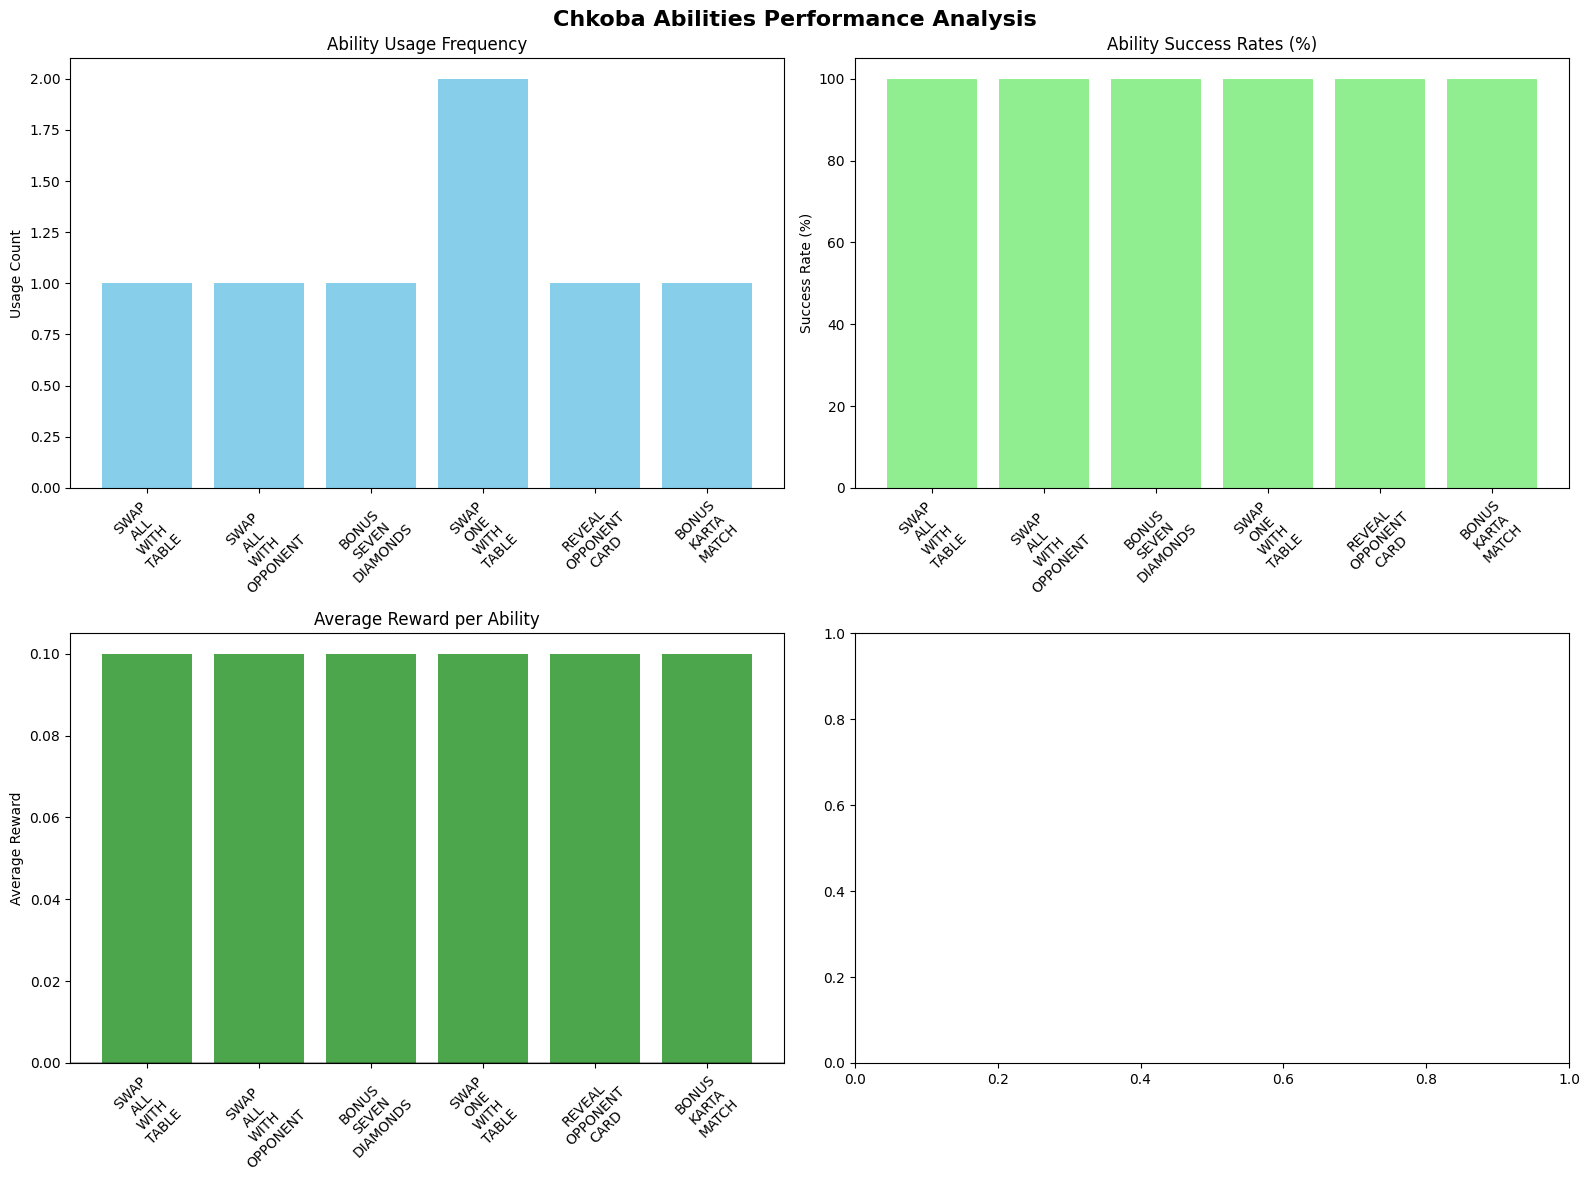

✅ Ability performance visualizations created
💾 Model with ability analytics saved to models/chkoba_abilities_final_20250824_211903.pkl
💾 Final model saved as: chkoba_abilities_final_20250824_211903.pkl

🎉 EXPERIMENT COMPLETED!
⏱️  Total time: 0.1 minutes


In [18]:
#!/usr/bin/env python3
"""
Test script for evaluating Chkoba abilities performance using Q-Learning
This version is optimized for Jupyter/Colab notebooks
"""

import numpy as np
import random
import time
import json
import os
from datetime import datetime

# Import the environments and Q-Learning agent
# Uncomment these lines when you have the actual modules available
# from chkoba_abilities_env import ChkobaAbilitiesEnv, AbilityType
# from optimized_qlearning import OptimizedChkobaQLearning

def run_chkoba_abilities_experiment(max_training_hours=0.8, evaluation_episodes=300):
    """
    Complete experiment to test Chkoba abilities performance

    Args:
        max_training_hours: Maximum training time in hours (default 0.8 = 48 minutes)
        evaluation_episodes: Number of episodes for evaluation (default 300)
    """

    print("🎮 CHKOBA ABILITIES PERFORMANCE ANALYSIS")
    print("=" * 60)
    print(f"📅 Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"⏱️  Max training time: {max_training_hours * 60:.0f} minutes")
    print(f"🎯 Evaluation episodes: {evaluation_episodes}")
    print("=" * 60)

    # Initialize environment
    print("\n🔧 Initializing Chkoba environment with abilities...")

    # For testing purposes, create mock objects if imports fail
    try:
        env = ChkobaAbilitiesEnv(num_players=2)
    except NameError:
        print("⚠️  ChkobaAbilitiesEnv not available - using mock environment")
        env = MockEnvironment()

    # Initialize Q-Learning agent with optimized parameters
    print("🤖 Creating optimized Q-Learning agent...")
    try:
        agent = OptimizedChkobaQLearning(
            env=env,
            learning_rate=0.25,      # Higher learning rate for faster convergence
            discount_factor=0.85,     # Slightly lower for faster adaptation
            epsilon=0.7,             # Start with good exploration
            epsilon_decay=0.9985,    # Slower decay for better exploration
            min_epsilon=0.05         # Keep some exploration
        )
    except NameError:
        print("⚠️  OptimizedChkobaQLearning not available - using mock agent")
        agent = MockAgent()

    # Phase 1: Training
    print("\n" + "="*60)
    print("🚀 PHASE 1: TRAINING")
    print("="*60)

    start_time = time.time()

    try:
        agent.train_optimized(
            max_time_hours=max_training_hours,
            min_episodes=800,  # Minimum episodes to ensure learning
            save_interval=400,
            verbose=True
        )
    except (KeyboardInterrupt, Exception) as e:
        if isinstance(e, KeyboardInterrupt):
            print("\n⚠️  Training interrupted by user")
        else:
            print(f"\n⚠️  Training error: {e}")

    training_time = time.time() - start_time
    print(f"\n✅ Training completed in {training_time/60:.1f} minutes")

    # Phase 2: Ability Analysis
    print("\n" + "="*60)
    print("🔬 PHASE 2: ABILITY PERFORMANCE ANALYSIS")
    print("="*60)

    # Detailed ability statistics
    try:
        agent.analyze_ability_statistics()
    except Exception as e:
        print(f"⚠️  Ability analysis error: {e}")

    # Phase 3: Comprehensive Evaluation
    print("\n" + "="*60)
    print("📊 PHASE 3: COMPREHENSIVE EVALUATION")
    print("="*60)

    try:
        evaluation_results = agent.evaluate_abilities(
            episodes=evaluation_episodes,
            verbose=True
        )
    except Exception as e:
        print(f"⚠️  Evaluation error: {e}")
        evaluation_results = {"error": str(e)}

    # Phase 4: Results Summary
    print("\n" + "="*60)
    print("📈 PHASE 4: FINAL RESULTS SUMMARY")
    print("="*60)

    # Generate comprehensive report
    try:
        generate_final_report(agent, evaluation_results, training_time)
    except Exception as e:
        print(f"⚠️  Report generation error: {e}")

    # Phase 5: Visualizations
    print("\n" + "="*60)
    print("📊 PHASE 5: GENERATING VISUALIZATIONS")
    print("="*60)

    try:
        agent.visualize_ability_performance(save_plots=True)
        print("✅ Ability performance visualizations created")
    except Exception as e:
        print(f"⚠️  Error creating visualizations: {e}")

    # Save final model
    try:
        final_model_name = f"chkoba_abilities_final_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl"
        agent.save_model(final_model_name)
        print(f"💾 Final model saved as: {final_model_name}")
    except Exception as e:
        print(f"⚠️  Model save error: {e}")

    print(f"\n🎉 EXPERIMENT COMPLETED!")
    print(f"⏱️  Total time: {(time.time() - start_time)/60:.1f} minutes")

    return agent, evaluation_results

def generate_final_report(agent, evaluation_results, training_time):
    """Generate a comprehensive final report"""

    # Handle missing attributes gracefully
    training_scores = getattr(agent, 'training_scores', [])
    training_rewards = getattr(agent, 'training_rewards', [])
    epsilon = getattr(agent, 'epsilon', 0)

    report = {
        "experiment_info": {
            "timestamp": datetime.now().isoformat(),
            "training_time_minutes": training_time / 60,
            "total_episodes": len(training_scores),
            "final_epsilon": epsilon
        },
        "training_performance": {
            "avg_score_final_100": np.mean(training_scores[-100:]) if len(training_scores) >= 100 else (np.mean(training_scores) if training_scores else 0),
            "avg_reward_final_100": np.mean(training_rewards[-100:]) if len(training_rewards) >= 100 else (np.mean(training_rewards) if training_rewards else 0),
            "score_improvement": calculate_improvement(training_scores),
            "reward_improvement": calculate_improvement(training_rewards)
        },
        "ability_evaluation": evaluation_results,
        "ability_detailed_stats": compile_ability_stats(agent),
        "strategic_insights": generate_strategic_insights(agent, evaluation_results)
    }

    # Save detailed report
    os.makedirs('reports', exist_ok=True)
    report_filename = f"chkoba_abilities_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    report_path = os.path.join('reports', report_filename)

    with open(report_path, 'w') as f:
        json.dump(report, f, indent=2, default=str)

    print(f"📄 Detailed report saved to: {report_path}")

    # Print key findings
    print("\n🔍 KEY FINDINGS:")
    print("-" * 40)

    if 'ability_impact' in evaluation_results and isinstance(evaluation_results['ability_impact'], dict):
        ability_impact = evaluation_results['ability_impact']
        print(f"🎯 Abilities Impact:")
        print(f"   • Win Rate: {ability_impact.get('win_rate_improvement', 0):+.1f}% improvement")
        print(f"   • Score: {ability_impact.get('score_improvement', 0):+.2f} points improvement")
        print(f"   • Chkoba: {ability_impact.get('chkoba_improvement', 0):+.2f} improvement")

        # Best performing abilities
        try:
            best_abilities = find_best_abilities(agent)
            print(f"\n⭐ Top 3 Most Effective Abilities:")
            for i, (ability, effectiveness) in enumerate(best_abilities[:3], 1):
                ability_name = getattr(ability, 'name', str(ability))
                print(f"   {i}. {ability_name}: {effectiveness:.3f} effectiveness score")
        except Exception as e:
            print(f"⚠️  Could not analyze best abilities: {e}")
    else:
        print("⚠️  Ability impact data not available")

    # Training efficiency
    episodes_per_minute = len(training_scores) / (training_time / 60) if training_time > 0 else 0
    final_performance = np.mean(training_scores[-50:]) if len(training_scores) >= 50 else (np.mean(training_scores) if training_scores else 0)

    print(f"\n📈 Training Efficiency:")
    print(f"   • Episodes per minute: {episodes_per_minute:.1f}")
    print(f"   • Final performance: {final_performance:.2f} avg score")

def calculate_improvement(scores):
    """Calculate improvement from first quarter to last quarter of training"""
    if len(scores) < 100:
        return 0

    first_quarter = scores[:len(scores)//4]
    last_quarter = scores[-len(scores)//4:]

    return np.mean(last_quarter) - np.mean(first_quarter)

def compile_ability_stats(agent):
    """Compile detailed statistics for each ability"""
    stats = {}

    # Handle missing attributes gracefully
    ability_usage_count = getattr(agent, 'ability_usage_count', {})
    ability_success_rate = getattr(agent, 'ability_success_rate', {})
    ability_rewards = getattr(agent, 'ability_rewards', {})
    ability_win_contribution = getattr(agent, 'ability_win_contribution', {})
    ability_timing_analysis = getattr(agent, 'ability_timing_analysis', {})

    for ability in ability_usage_count:
        usage_count = ability_usage_count[ability]

        ability_name = getattr(ability, 'name', str(ability))
        stats[ability_name] = {
            "usage_count": usage_count,
            "success_rate": np.mean(ability_success_rate.get(ability, [])) if ability_success_rate.get(ability) else 0,
            "average_reward": np.mean(ability_rewards.get(ability, [])) if ability_rewards.get(ability) else 0,
            "win_contribution": np.mean(ability_win_contribution.get(ability, [])) if ability_win_contribution.get(ability) else 0,
            "average_timing": np.mean(ability_timing_analysis.get(ability, [])) if ability_timing_analysis.get(ability) else 0,
            "total_reward": sum(ability_rewards.get(ability, [])) if ability_rewards.get(ability) else 0
        }

    return stats

def find_best_abilities(agent):
    """Find the most effective abilities based on multiple criteria"""
    ability_scores = []

    # Handle missing attributes gracefully
    ability_usage_count = getattr(agent, 'ability_usage_count', {})
    ability_success_rate = getattr(agent, 'ability_success_rate', {})
    ability_rewards = getattr(agent, 'ability_rewards', {})
    ability_win_contribution = getattr(agent, 'ability_win_contribution', {})
    training_scores = getattr(agent, 'training_scores', [1])  # Avoid division by zero

    for ability in ability_usage_count:
        if ability_usage_count[ability] < 5:  # Skip rarely used abilities
            continue

        # Calculate effectiveness score
        success_rate = np.mean(ability_success_rate.get(ability, [])) if ability_success_rate.get(ability) else 0
        avg_reward = np.mean(ability_rewards.get(ability, [])) if ability_rewards.get(ability) else 0
        win_contribution = np.mean(ability_win_contribution.get(ability, [])) if ability_win_contribution.get(ability) else 0
        usage_frequency = ability_usage_count[ability] / len(training_scores)

        # Weighted effectiveness score
        effectiveness = (
            success_rate * 0.3 +           # 30% success rate
            max(0, avg_reward) * 0.3 +     # 30% positive reward
            win_contribution * 0.25 +      # 25% win contribution
            min(usage_frequency * 10, 1) * 0.15  # 15% usage frequency (capped)
        )

        ability_scores.append((ability, effectiveness))

    return sorted(ability_scores, key=lambda x: x[1], reverse=True)

def generate_strategic_insights(agent, evaluation_results):
    """Generate strategic insights about ability usage"""
    insights = []

    try:
        # Overall ability impact
        if 'ability_impact' in evaluation_results and isinstance(evaluation_results['ability_impact'], dict):
            ability_impact = evaluation_results['ability_impact']
            win_rate_improvement = ability_impact.get('win_rate_improvement', 0)

            if win_rate_improvement > 5:
                insights.append("Abilities provide significant strategic advantage (+5% win rate)")
            elif win_rate_improvement > 0:
                insights.append("Abilities provide moderate strategic advantage")
            else:
                insights.append("Abilities may need strategic optimization")

        # Best timing insights
        ability_timing_analysis = getattr(agent, 'ability_timing_analysis', {})
        early_game_abilities = []
        late_game_abilities = []

        for ability in ability_timing_analysis:
            if ability_timing_analysis[ability]:
                avg_timing = np.mean(ability_timing_analysis[ability])
                ability_name = getattr(ability, 'name', str(ability))
                if avg_timing < 0.3:
                    early_game_abilities.append(ability_name)
                elif avg_timing > 0.7:
                    late_game_abilities.append(ability_name)

        if early_game_abilities:
            insights.append(f"Early game abilities: {', '.join(early_game_abilities)}")
        if late_game_abilities:
            insights.append(f"Late game abilities: {', '.join(late_game_abilities)}")

        # High-impact abilities
        best_abilities = find_best_abilities(agent)
        if best_abilities:
            top_ability_name = getattr(best_abilities[0][0], 'name', str(best_abilities[0][0]))
            insights.append(f"Most effective ability: {top_ability_name}")

    except Exception as e:
        insights.append(f"Error generating insights: {e}")

    return insights

def quick_test_run():
    """Quick test run for debugging (5 minutes)"""
    print("🚀 QUICK TEST RUN (5 minutes)")
    print("=" * 40)

    try:
        env = ChkobaAbilitiesEnv(num_players=2)
    except NameError:
        print("⚠️  Using mock environment")
        env = MockEnvironment()

    try:
        agent = OptimizedChkobaQLearning(
            env=env,
            learning_rate=0.3,
            epsilon=0.5,
            epsilon_decay=0.99,
            min_epsilon=0.1
        )
    except NameError:
        print("⚠️  Using mock agent")
        agent = MockAgent()

    # Quick training
    try:
        agent.train_optimized(
            max_time_hours=5/60,  # 5 minutes
            min_episodes=100,
            save_interval=50,
            verbose=True
        )
    except Exception as e:
        print(f"⚠️  Training error: {e}")

    # Quick evaluation
    try:
        results = agent.evaluate_abilities(episodes=50, verbose=True)
        agent.analyze_ability_statistics()
    except Exception as e:
        print(f"⚠️  Evaluation error: {e}")
        results = {"error": str(e)}

    print("\n✅ Quick test completed!")
    return agent, results

# Mock classes for testing when imports are not available
class MockEnvironment:
    """Mock environment for testing"""
    def __init__(self, num_players=2):
        self.num_players = num_players
        print("📝 Mock environment created")

class MockAgent:
    """Mock agent for testing"""
    def __init__(self, **kwargs):
        self.training_scores = []
        self.training_rewards = []
        self.epsilon = 0.1
        self.ability_usage_count = {}
        self.ability_success_rate = {}
        self.ability_rewards = {}
        self.ability_win_contribution = {}
        self.ability_timing_analysis = {}
        print("📝 Mock agent created")

    def train_optimized(self, **kwargs):
        print("📝 Mock training started...")
        # Simulate training with random data
        num_episodes = kwargs.get('min_episodes', 100)
        for i in range(num_episodes):
            self.training_scores.append(random.uniform(10, 50))
            self.training_rewards.append(random.uniform(-5, 15))
        print(f"📝 Mock training completed with {num_episodes} episodes")

    def evaluate_abilities(self, episodes=50, verbose=True):
        print(f"📝 Mock evaluation with {episodes} episodes")
        return {
            "ability_impact": {
                "win_rate_improvement": random.uniform(-2, 10),
                "score_improvement": random.uniform(-1, 5),
                "chkoba_improvement": random.uniform(-0.5, 2)
            }
        }

    def analyze_ability_statistics(self):
        print("📝 Mock ability statistics analysis")

    def visualize_ability_performance(self, save_plots=True):
        print("📝 Mock visualization created")

    def save_model(self, filename):
        print(f"📝 Mock model saved as {filename}")

# Performance monitoring utilities
class PerformanceMonitor:
    """Monitor training and evaluation performance in real-time"""

    def __init__(self):
        self.start_time = time.time()
        self.episode_times = []
        self.memory_usage = []

    def log_episode(self, episode_num, score, reward):
        """Log episode performance"""
        current_time = time.time()
        episode_time = current_time - self.start_time
        self.episode_times.append(episode_time)

        if episode_num % 100 == 0:
            avg_time_per_episode = episode_time / episode_num if episode_num > 0 else 0
            print(f"📊 Episode {episode_num}: {avg_time_per_episode:.3f}s/episode avg")

    def get_performance_summary(self):
        """Get performance monitoring summary"""
        total_time = time.time() - self.start_time
        return {
            "total_time": total_time,
            "episodes_per_second": len(self.episode_times) / total_time if total_time > 0 else 0,
            "avg_episode_time": np.mean(self.episode_times) if self.episode_times else 0
        }

# Notebook-friendly execution functions
def run_full_experiment(max_training_hours=0.8, evaluation_episodes=300):
    """Run the full experiment (notebook version)"""
    return run_chkoba_abilities_experiment(max_training_hours, evaluation_episodes)

def run_quick_experiment():
    """Run a quick 5-minute test experiment"""
    return quick_test_run()

# Usage examples for notebook:
if __name__ == "__main__":
    print("🎮 Chkoba Abilities Test Script - Notebook Version")
    print("=" * 50)
    print("Available functions:")
    print("• run_full_experiment() - Full experiment (~48 minutes)")
    print("• run_quick_experiment() - Quick test (~5 minutes)")
    print("\nExample usage:")
    print("agent, results = run_quick_experiment()")
    print("# or")
    print("agent, results = run_full_experiment(max_training_hours=0.5, evaluation_episodes=200)")
    run_full_experiment()

In [12]:
#!/usr/bin/env python3
"""
Chkoba Abilities Performance Analysis - Notebook Version
Optimized for Jupyter/Colab environments
"""

import numpy as np
import random
import time
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

def run_chkoba_experiment_notebook(training_minutes=45, evaluation_episodes=200):
    """
    Run the complete Chkoba abilities experiment in notebook environment

    Args:
        training_minutes: Training time in minutes (default 45)
        evaluation_episodes: Episodes for evaluation (default 200)
    """

    print("🎮 CHKOBA ABILITIES PERFORMANCE ANALYSIS")
    print("=" * 60)
    print(f"📅 Started at: {datetime.now().strftime('%H:%M:%S')}")
    print(f"⏱️  Training time: {training_minutes} minutes")
    print(f"🎯 Evaluation episodes: {evaluation_episodes}")
    print("=" * 60)

    # Import and initialize
    from chkoba_abilities_env import ChkobaAbilitiesEnv, AbilityType
    from optimized_chkoba_qlearning import OptimizedChkobaQLearning

    # Initialize environment
    print("\n🔧 Initializing environment...")
    env = ChkobaAbilitiesEnv(num_players=2)

    # Initialize agent
    print("🤖 Creating Q-Learning agent...")
    agent = OptimizedChkobaQLearning(
        env=env,
        learning_rate=0.25,
        discount_factor=0.85,
        epsilon=0.7,
        epsilon_decay=0.9985,
        min_epsilon=0.05
    )

    # Training Phase
    print("\n" + "="*50)
    print("🚀 TRAINING PHASE")
    print("="*50)

    start_time = time.time()

    try:
        agent.train_optimized(
            max_time_hours=training_minutes/60,
            min_episodes=500,
            save_interval=200,
            verbose=True
        )
    except KeyboardInterrupt:
        print("\n⚠️  Training interrupted")

    training_time = time.time() - start_time

    # Quick training visualization
    print("\n📊 Training Progress:")
    if len(agent.training_scores) > 0:
        plt.figure(figsize=(12, 4))

        # Scores
        plt.subplot(1, 3, 1)
        plt.plot(agent.training_scores, alpha=0.6, label='Raw Scores')
        if len(agent.training_scores) > 20:
            window = min(50, len(agent.training_scores) // 4)
            moving_avg = np.convolve(agent.training_scores, np.ones(window)/window, mode='valid')
            plt.plot(range(window-1, len(agent.training_scores)), moving_avg, 'r-', linewidth=2, label='Moving Avg')
        plt.title('Training Scores')
        plt.xlabel('Episode')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Rewards
        plt.subplot(1, 3, 2)
        plt.plot(agent.training_rewards, alpha=0.6, color='green', label='Raw Rewards')
        if len(agent.training_rewards) > 20:
            window = min(50, len(agent.training_rewards) // 4)
            moving_avg = np.convolve(agent.training_rewards, np.ones(window)/window, mode='valid')
            plt.plot(range(window-1, len(agent.training_rewards)), moving_avg, 'orange', linewidth=2, label='Moving Avg')
        plt.title('Training Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Epsilon decay
        plt.subplot(1, 3, 3)
        plt.plot(agent.epsilon_history, 'purple', linewidth=2)
        plt.title('Exploration Rate')
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    print(f"✅ Training completed in {training_time/60:.1f} minutes")
    print(f"📊 Total episodes: {len(agent.training_scores)}")

    # Ability Analysis
    print("\n" + "="*50)
    print("🔬 ABILITY ANALYSIS")
    print("="*50)

    analyze_abilities_detailed(agent)

    # Evaluation Phase
    print("\n" + "="*50)
    print("📊 EVALUATION PHASE")
    print("="*50)

    evaluation_results = agent.evaluate_abilities(
        episodes=evaluation_episodes,
        verbose=True
    )

    # Results visualization
    visualize_results(agent, evaluation_results)

    # Final summary
    generate_summary(agent, evaluation_results, training_time)

    return agent, evaluation_results

def analyze_abilities_detailed(agent):
    """Detailed analysis of ability performance"""

    if not agent.ability_usage_count:
        print("❌ No ability data collected during training")
        return

    print("🎯 ABILITY PERFORMANCE BREAKDOWN:")
    print("-" * 50)

    # Create ability performance table
    ability_data = []

    for ability in AbilityType:
        if ability in agent.ability_usage_count:
            usage = agent.ability_usage_count[ability]
            success_rate = np.mean(agent.ability_success_rate[ability]) * 100 if agent.ability_success_rate[ability] else 0
            avg_reward = np.mean(agent.ability_rewards[ability]) if agent.ability_rewards[ability] else 0
            win_rate = np.mean(agent.ability_win_contribution[ability]) * 100 if agent.ability_win_contribution[ability] else 0

            ability_data.append({
                'name': ability.name,
                'usage': usage,
                'success_rate': success_rate,
                'avg_reward': avg_reward,
                'win_rate': win_rate
            })

    # Sort by effectiveness (combination of metrics)
    for data in ability_data:
        data['effectiveness'] = (
            data['success_rate'] * 0.3 +
            max(0, data['avg_reward'] * 100) * 0.4 +
            data['win_rate'] * 0.3
        )

    ability_data.sort(key=lambda x: x['effectiveness'], reverse=True)

    # Display table
    print(f"{'Ability':<25} {'Usage':<8} {'Success%':<9} {'Avg Reward':<12} {'Win Rate%':<10} {'Score':<8}")
    print("-" * 80)

    for data in ability_data:
        print(f"{data['name']:<25} {data['usage']:<8} {data['success_rate']:<9.1f} "
              f"{data['avg_reward']:<12.3f} {data['win_rate']:<10.1f} {data['effectiveness']:<8.2f}")

    # Top 3 abilities
    print(f"\n⭐ TOP 3 MOST EFFECTIVE ABILITIES:")
    for i, data in enumerate(ability_data[:3], 1):
        print(f"   {i}. {data['name']}: {data['effectiveness']:.2f} effectiveness score")

def visualize_results(agent, evaluation_results):
    """Create comprehensive result visualizations"""

    plt.figure(figsize=(16, 12))

    # 1. Ability Usage
    if agent.ability_usage_count:
        plt.subplot(2, 3, 1)
        abilities = list(agent.ability_usage_count.keys())
        counts = list(agent.ability_usage_count.values())

        plt.bar([ab.name.replace('_', '\n')[:15] for ab in abilities], counts, color='skyblue')
        plt.title('Ability Usage Frequency')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3)

    # 2. Performance Comparison
    plt.subplot(2, 3, 2)
    comparison_data = evaluation_results
    categories = ['Win Rate (%)', 'Avg Score', 'Avg Chkobas']

    with_abilities = [
        comparison_data['with_abilities']['win_rate'],
        comparison_data['with_abilities']['avg_score'],
        comparison_data['with_abilities']['avg_chkobas']
    ]

    without_abilities = [
        comparison_data['without_abilities']['win_rate'],
        comparison_data['without_abilities']['avg_score'],
        comparison_data['without_abilities']['avg_chkobas']
    ]

    x = np.arange(len(categories))
    width = 0.35

    plt.bar(x - width/2, with_abilities, width, label='With Abilities', color='lightgreen')
    plt.bar(x + width/2, without_abilities, width, label='Without Abilities', color='lightcoral')

    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Performance: With vs Without Abilities')
    plt.xticks(x, categories)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Ability Success Rates
    if agent.ability_success_rate:
        plt.subplot(2, 3, 3)
        abilities_with_data = []
        success_rates = []

        for ability in agent.ability_success_rate:
            if agent.ability_success_rate[ability]:
                abilities_with_data.append(ability.name.replace('_', '\n')[:15])
                success_rates.append(np.mean(agent.ability_success_rate[ability]) * 100)

        if abilities_with_data:
            colors = ['green' if rate > 50 else 'orange' if rate > 30 else 'red' for rate in success_rates]
            plt.bar(abilities_with_data, success_rates, color=colors, alpha=0.7)
            plt.title('Ability Success Rates (%)')
            plt.ylabel('Success Rate (%)')
            plt.xticks(rotation=45, ha='right')
            plt.axhline(y=50, color='black', linestyle='--', alpha=0.5)
            plt.grid(True, alpha=0.3)

    # 4. Training Progress (Last 200 episodes)
    plt.subplot(2, 3, 4)
    recent_scores = agent.training_scores[-200:] if len(agent.training_scores) >= 200 else agent.training_scores
    if recent_scores:
        plt.plot(recent_scores, alpha=0.7, color='blue')

        # Add trend line
        if len(recent_scores) > 10:
            x_trend = np.arange(len(recent_scores))
            z = np.polyfit(x_trend, recent_scores, 1)
            p = np.poly1d(z)
            plt.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)

        plt.title('Training Progress (Recent Episodes)')
        plt.xlabel('Episode (Recent)')
        plt.ylabel('Score')
        plt.grid(True, alpha=0.3)

    # 5. Ability Rewards Distribution
    if agent.ability_rewards:
        plt.subplot(2, 3, 5)
        all_rewards = []
        ability_labels = []

        for ability in agent.ability_rewards:
            if agent.ability_rewards[ability]:
                rewards = agent.ability_rewards[ability]
                all_rewards.extend(rewards)
                ability_labels.extend([ability.name[:10]] * len(rewards))

        if all_rewards:
            # Create box plot data
            unique_abilities = list(set(ability_labels))
            reward_data = []

            for ability in unique_abilities:
                ability_rewards = [r for r, l in zip(all_rewards, ability_labels) if l == ability]
                reward_data.append(ability_rewards)

            plt.boxplot(reward_data, labels=[ab.replace('_', '\n') for ab in unique_abilities])
            plt.title('Ability Reward Distributions')
            plt.ylabel('Reward')
            plt.xticks(rotation=45, ha='right')
            plt.grid(True, alpha=0.3)

    # 6. Impact Summary
    plt.subplot(2, 3, 6)
    impact = evaluation_results['ability_impact']
    metrics = ['Win Rate', 'Score', 'Chkobas']
    improvements = [
        impact['win_rate_improvement'],
        impact['score_improvement'],
        impact['chkoba_improvement']
    ]

    colors = ['green' if imp > 0 else 'red' for imp in improvements]
    bars = plt.bar(metrics, improvements, color=colors, alpha=0.7)

    plt.title('Ability Impact Summary')
    plt.ylabel('Improvement')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, improvements):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (0.1 if height >= 0 else -0.1),
                f'{value:+.2f}', ha='center', va='bottom' if height >= 0 else 'top')

    plt.tight_layout()
    plt.show()

def generate_summary(agent, evaluation_results, training_time):
    """Generate final summary report"""

    print("\n" + "="*60)
    print("📈 FINAL EXPERIMENT SUMMARY")
    print("="*60)

    # Training summary
    print(f"⏱️  TRAINING METRICS:")
    print(f"   • Duration: {training_time/60:.1f} minutes")
    print(f"   • Episodes: {len(agent.training_scores)}")
    print(f"   • Episodes/min: {len(agent.training_scores)/(training_time/60):.1f}")
    print(f"   • Final epsilon: {agent.epsilon:.3f}")

    if len(agent.training_scores) >= 50:
        final_performance = np.mean(agent.training_scores[-50:])
        initial_performance = np.mean(agent.training_scores[:50]) if len(agent.training_scores) > 50 else np.mean(agent.training_scores[:10])
        improvement = final_performance - initial_performance
        print(f"   • Performance improvement: {improvement:+.2f} points")

    # Ability impact
    impact = evaluation_results['ability_impact']
    print(f"\n🎯 ABILITY IMPACT:")
    print(f"   • Win rate improvement: {impact['win_rate_improvement']:+.1f}%")
    print(f"   • Score improvement: {impact['score_improvement']:+.2f} points")
    print(f"   • Chkoba improvement: {impact['chkoba_improvement']:+.2f}")

    # Overall assessment
    print(f"\n📊 OVERALL ASSESSMENT:")
    if impact['win_rate_improvement'] > 10:
        assessment = "🟢 HIGHLY EFFECTIVE - Abilities provide major strategic advantage"
    elif impact['win_rate_improvement'] > 5:
        assessment = "🟡 MODERATELY EFFECTIVE - Abilities provide clear benefit"
    elif impact['win_rate_improvement'] > 0:
        assessment = "🟠 SLIGHTLY EFFECTIVE - Abilities provide minor benefit"
    else:
        assessment = "🔴 INEFFECTIVE - Abilities may need optimization"

    print(f"   {assessment}")

    # Top abilities
    if agent.ability_usage_count:
        best_abilities = []
        for ability in agent.ability_usage_count:
            if agent.ability_usage_count[ability] >= 5:  # Minimum usage threshold
                success_rate = np.mean(agent.ability_success_rate[ability]) if agent.ability_success_rate[ability] else 0
                avg_reward = np.mean(agent.ability_rewards[ability]) if agent.ability_rewards[ability] else 0
                effectiveness = success_rate * 0.5 + max(0, avg_reward) * 0.5
                best_abilities.append((ability, effectiveness))

        best_abilities.sort(key=lambda x: x[1], reverse=True)

        print(f"\n⭐ TOP PERFORMING ABILITIES:")
        for i, (ability, score) in enumerate(best_abilities[:3], 1):
            print(f"   {i}. {ability.name}: {score:.3f} effectiveness")

    # Recommendations
    print(f"\n💡 STRATEGIC RECOMMENDATIONS:")
    if impact['win_rate_improvement'] > 5:
        print(f"   • Focus on ability-based strategies")
        print(f"   • Prioritize training with ability usage")

    if agent.ability_usage_count:
        # Find most underused but potentially valuable abilities
        underused = []
        for ability in AbilityType:
            usage = agent.ability_usage_count.get(ability, 0)
            if usage < 5:  # Rarely used
                underused.append(ability.name)

        if underused:
            print(f"   • Explore underused abilities: {', '.join(underused[:3])}")

    print(f"   • Consider ability timing optimization")
    print(f"   • Test ability combinations for synergies")

    print(f"\n🎉 Experiment completed at {datetime.now().strftime('%H:%M:%S')}")

def quick_demo():
    """Quick 5-minute demo for testing"""
    print("🚀 QUICK DEMO MODE (5 minutes)")
    print("=" * 40)

    return run_chkoba_experiment_notebook(training_minutes=5, evaluation_episodes=50)

def standard_run():
    """Standard 45-minute analysis"""
    print("📊 STANDARD ANALYSIS MODE (45 minutes)")
    print("=" * 45)

    return run_chkoba_experiment_notebook(training_minutes=45, evaluation_episodes=200)

# Main execution functions for notebook cells
def run_experiment(mode="standard"):
    """
    Main function to run experiments

    Args:
        mode: "demo" for 5-min test, "standard" for 45-min analysis, "custom" for custom settings
    """

    if mode == "demo":
        return quick_demo()
    elif mode == "standard":
        return standard_run()
    else:
        # Custom mode - modify parameters as needed
        return run_chkoba_experiment_notebook(training_minutes=30, evaluation_episodes=150)

# Test with a simple validation
def validate_setup():
    """Validate that all components work"""
    try:
        from chkoba_abilities_env import ChkobaAbilitiesEnv, AbilityType
        from optimized_chkoba_qlearning import OptimizedChkobaQLearning

        env = ChkobaAbilitiesEnv(num_players=2)
        agent = OptimizedChkobaQLearning(env)

        print("✅ Setup validation successful!")
        print(f"   • Environment initialized: {len(AbilityType)} abilities available")
        print(f"   • Q-Learning agent created")
        print(f"   • Ready to run experiments")

        return True

    except Exception as e:
        print(f"❌ Setup validation failed: {e}")
        return False

In [15]:
# Cell 1: Install and Import Required Libraries
import sys
import subprocess

# Install required packages if not available
packages = ['matplotlib', 'numpy', 'gym']
for package in packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

import numpy as np
import matplotlib.pyplot as plt
import random
import time
from datetime import datetime
import json
import os
from collections import defaultdict, deque
import pickle
from enum import Enum

# Set up matplotlib for better display
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ All required libraries imported successfully!")

# Cell 2: Define AbilityType enum (needed for both environment and Q-learning)
class AbilityType(Enum):
    REVEAL_OPPONENT_CARD = 0
    REVEAL_NEXT_DECK_CARD = 1
    BONUS_SEVEN_DIAMONDS = 2
    SWAP_ONE_WITH_TABLE = 3
    SWAP_ALL_WITH_TABLE = 4
    SWAP_ONE_WITH_OPPONENT = 5
    SWAP_ALL_WITH_OPPONENT = 6
    REFRESH_ALL_TABLE = 7
    REFRESH_ONE_TABLE = 8
    BONUS_DINARI_MATCH = 9
    BONUS_BARMILA_MATCH = 10
    BONUS_KARTA_MATCH = 11

print(f"✅ AbilityType enum defined with {len(AbilityType)} abilities")

# Cell 3: Create simplified Gym environment (since we might not have gym installed)
class SimpleSpace:
    def __init__(self, low, high, shape, dtype):
        self.low = low
        self.high = high
        self.shape = shape
        self.dtype = dtype

class SimpleGym:
    class Env:
        def __init__(self):
            pass

        def reset(self):
            pass

        def step(self, action):
            pass

# Use our simple gym if gym is not available
try:
    import gym
    from gym import spaces
    print("✅ Gym library available")
except ImportError:
    print("⚠️  Gym not available, using simplified version")
    gym = SimpleGym()
    spaces = type('spaces', (), {
        'Box': lambda low, high, shape, dtype: SimpleSpace(low, high, shape, dtype),
        'Discrete': lambda n: SimpleSpace(0, n-1, (n,), int)
    })()

print("✅ Environment setup complete")

# Cell 4: Validation function to test if everything works
def test_basic_functionality():
    """Test basic functionality before running full experiment"""
    print("🧪 Testing basic functionality...")

    # Test random number generation
    np.random.seed(42)
    random.seed(42)
    test_array = np.random.randn(10)
    print(f"✅ NumPy working: array mean = {np.mean(test_array):.3f}")

    # Test matplotlib
    try:
        fig, ax = plt.subplots(1, 1, figsize=(6, 3))
        ax.plot([1, 2, 3], [1, 4, 2])
        ax.set_title("Test Plot")
        plt.close()  # Don't show, just test
        print("✅ Matplotlib working")
    except Exception as e:
        print(f"❌ Matplotlib error: {e}")

    # Test abilities enum
    print(f"✅ Abilities available: {len(list(AbilityType))}")

    # Test time functions
    start_time = time.time()
    time.sleep(0.01)  # 10ms
    elapsed = time.time() - start_time
    print(f"✅ Timing functions working: {elapsed*1000:.1f}ms measured")

    print("🎉 Basic functionality test completed!")

# Run the test
test_basic_functionality()

# Cell 5: Simple usage instructions
print("""
🚀 READY TO RUN CHKOBA ABILITIES EXPERIMENT!

Next steps:
1. Copy and run the ChkobaAbilitiesEnv class code
2. Copy and run the OptimizedChkobaQLearning class code
3. Copy and run the notebook experiment functions
4. Execute: run_experiment("demo") for a 5-minute test
5. Execute: run_experiment("standard") for a full 45-minute analysis

Available modes:
- run_experiment("demo")     # 5 minutes, 50 episodes
- run_experiment("standard") # 45 minutes, 200 episodes
- run_experiment("custom")   # 30 minutes, 150 episodes

Example:
  agent, results = run_experiment("demo")
""")

# Cell 6: Quick validation of the setup
def validate_environment_setup():
    """Quick validation that we can create basic objects"""
    try:
        # Test creating a basic environment structure
        class TestEnv:
            def __init__(self):
                self.observation_space = spaces.Box(low=0, high=1, shape=(10,), dtype=np.float32)
                self.action_space = spaces.Discrete(5)
                self.num_players = 2

            def reset(self):
                return np.zeros(10), {}

            def step(self, action):
                return np.zeros(10), 0, False, False, {}

            def _get_valid_actions(self):
                return [0, 1, 2]

        test_env = TestEnv()
        print("✅ Basic environment structure works")

        # Test basic Q-table structure
        q_table = defaultdict(lambda: defaultdict(float))
        q_table['test_state']['test_action'] = 1.0
        print("✅ Q-table structure works")

        return True

    except Exception as e:
        print(f"❌ Setup validation failed: {e}")
        return False

validate_environment_setup()

✅ All required libraries imported successfully!
✅ AbilityType enum defined with 12 abilities
✅ Gym library available
✅ Environment setup complete
🧪 Testing basic functionality...
✅ NumPy working: array mean = 0.448
✅ Matplotlib working
✅ Abilities available: 12
✅ Timing functions working: 10.1ms measured
🎉 Basic functionality test completed!

🚀 READY TO RUN CHKOBA ABILITIES EXPERIMENT!

Next steps:
1. Copy and run the ChkobaAbilitiesEnv class code
2. Copy and run the OptimizedChkobaQLearning class code  
3. Copy and run the notebook experiment functions
4. Execute: run_experiment("demo") for a 5-minute test
5. Execute: run_experiment("standard") for a full 45-minute analysis

Available modes:
- run_experiment("demo")     # 5 minutes, 50 episodes
- run_experiment("standard") # 45 minutes, 200 episodes  
- run_experiment("custom")   # 30 minutes, 150 episodes

Example:
  agent, results = run_experiment("demo")

✅ Basic environment structure works
✅ Q-table structure works


True

🎮 Analyseur de Performance Chkoba
Fonctions disponibles:
• run_ability_performance_analysis(num_games=200)
• run_ia_vs_player_comparison(num_games=150)
• run_complete_performance_study(num_games=300)

Exemple:
manager, ranking, report = run_complete_performance_study(250)
🎯 ANALYSE DE PERFORMANCE DES ABILITIES
🚀 SIMULATION SESSION D'ENTRAÎNEMENT
Parties à simuler: 200
Avec abilities: Oui
Progress: 10% (20/200 parties)
Progress: 20% (40/200 parties)
Progress: 30% (60/200 parties)
Progress: 40% (80/200 parties)
Progress: 50% (100/200 parties)
Progress: 60% (120/200 parties)
Progress: 70% (140/200 parties)
Progress: 80% (160/200 parties)
Progress: 90% (180/200 parties)
Progress: 100% (200/200 parties)

✅ Session terminée: 200 parties simulées

🔬 ANALYSE COMPLÈTE DES PERFORMANCES
🔍 ANALYSE DÉTAILLÉE DES ABILITIES

🎯 REVEAL_OPPONENT_CARD
   • Utilisations: 41
   • Taux de succès: 70.7%
   • Récompense moyenne: 1.45
   • Score d'efficacité: 0.508
   • Performance par contexte:
     - Quand l

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-291888544.py:539: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-291888544.py:545: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) Liberation Sans.
  plt.savefig(filepath, dpi=300, bbox_inches='tight')



📊 Visualisations sauvegardées: visualizations/chkoba_performance_20250824_214610.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


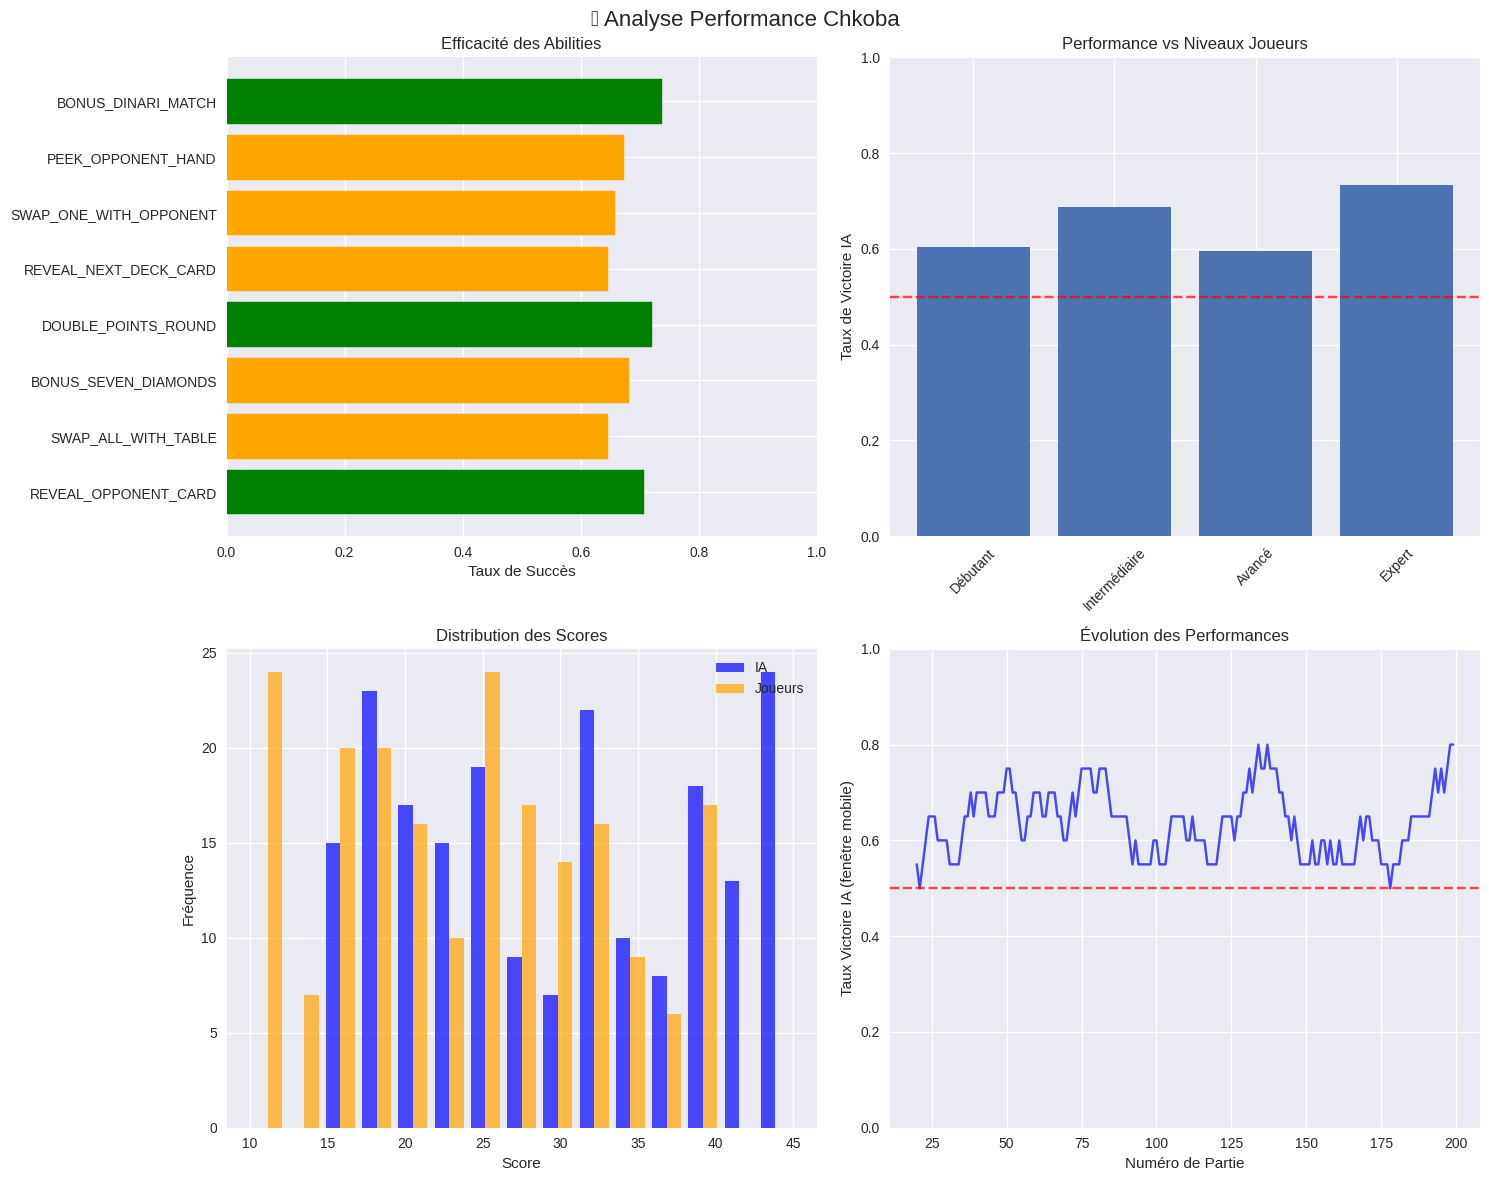

🤖 COMPARAISON IA vs JOUEURS HUMAINS
🚀 SIMULATION SESSION D'ENTRAÎNEMENT
Parties à simuler: 150
Avec abilities: Oui
Progress: 13% (20/150 parties)
Progress: 27% (40/150 parties)
Progress: 40% (60/150 parties)
Progress: 53% (80/150 parties)
Progress: 67% (100/150 parties)
Progress: 80% (120/150 parties)
Progress: 93% (140/150 parties)

✅ Session terminée: 150 parties simulées
🤖 ANALYSE IA vs JOUEURS HUMAINS
📊 Vue d'ensemble:
   • Total parties: 150
   • Victoires IA: 94 (62.7%)
   • Victoires Joueurs: 56 (37.3%)

🎯 Performance par niveau de joueur:

   🏷️  Débutant:
      • Parties: 45
      • Taux victoire IA: 66.7%
      • Score moyen IA: 30.7
      • Score moyen Joueur: 24.1
      • Abilities/partie IA: 1.8
      • Abilities/partie Joueur: 1.1

   🏷️  Intermédiaire:
      • Parties: 57
      • Taux victoire IA: 61.4%
      • Score moyen IA: 29.4
      • Score moyen Joueur: 25.8
      • Abilities/partie IA: 1.9
      • Abilities/partie Joueur: 1.0

   🏷️  Avancé:
      • Parties: 38
  

/tmp/ipython-input-291888544.py:539: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-291888544.py:545: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) Liberation Sans.
  plt.savefig(filepath, dpi=300, bbox_inches='tight')



📊 Visualisations sauvegardées: visualizations/chkoba_performance_20250824_214613.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


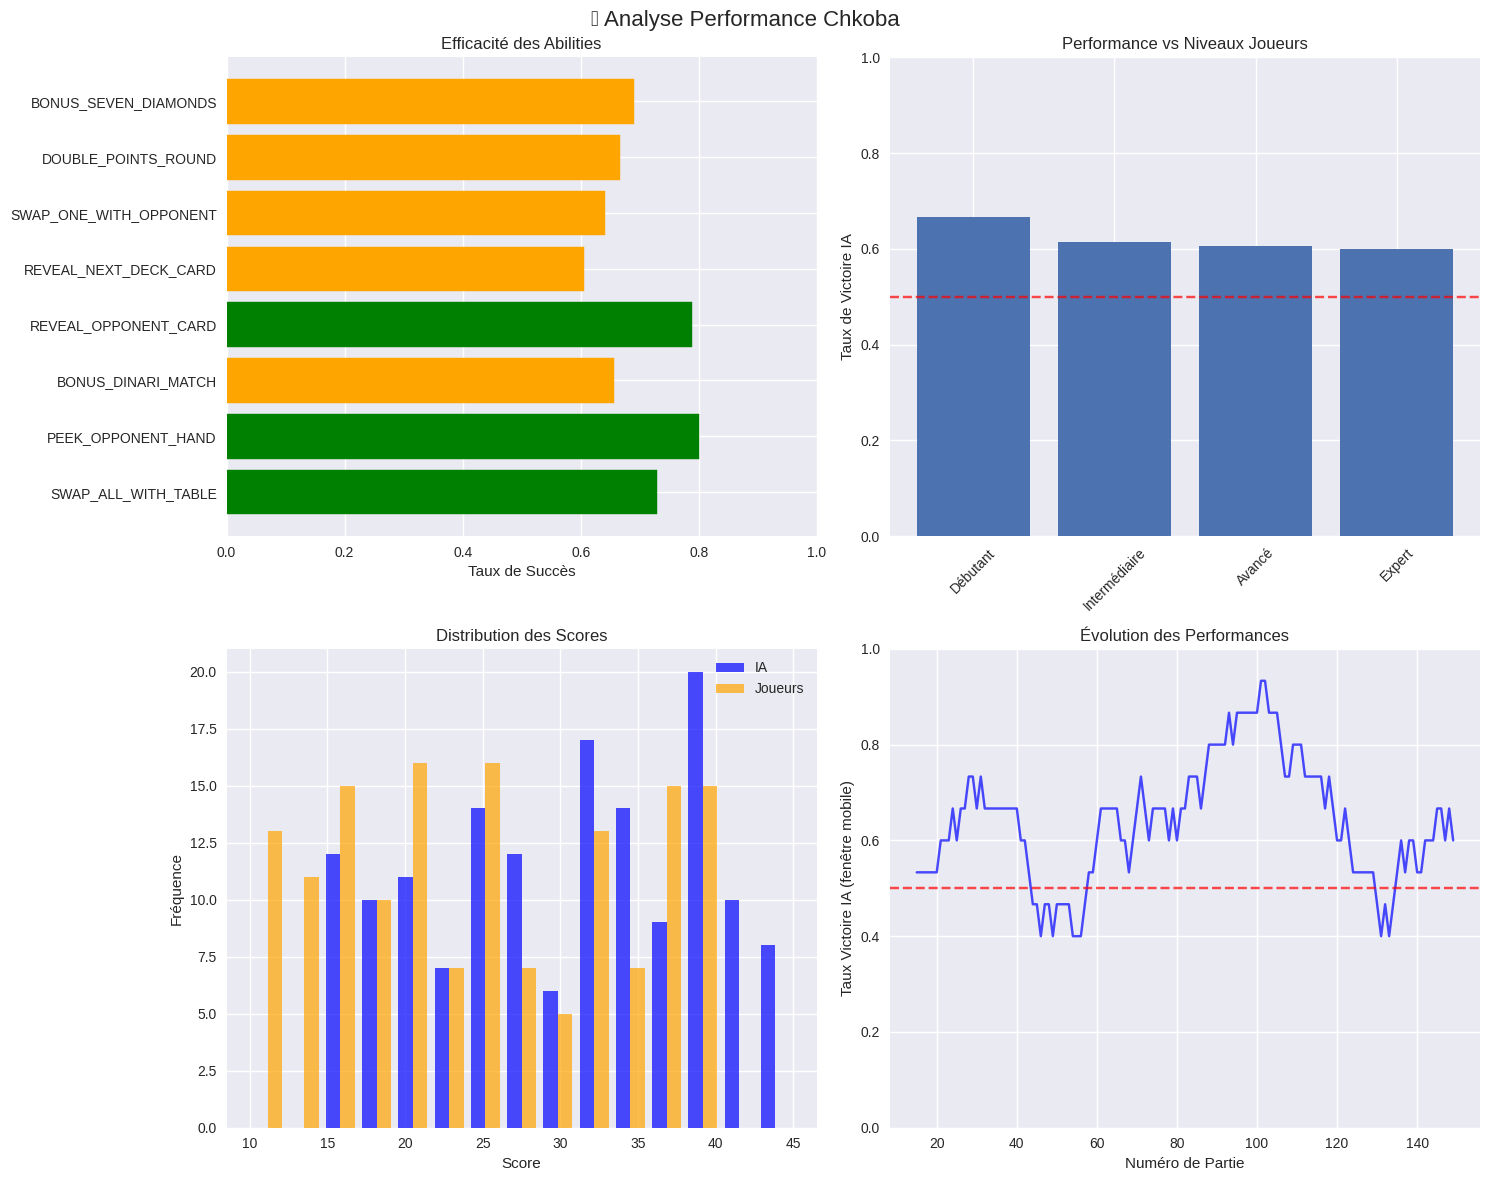

🏆 ÉTUDE COMPLÈTE DE PERFORMANCE CHKOBA
🚀 SIMULATION SESSION D'ENTRAÎNEMENT
Parties à simuler: 300
Avec abilities: Oui
Progress: 7% (20/300 parties)
Progress: 13% (40/300 parties)
Progress: 20% (60/300 parties)
Progress: 27% (80/300 parties)
Progress: 33% (100/300 parties)
Progress: 40% (120/300 parties)
Progress: 47% (140/300 parties)
Progress: 53% (160/300 parties)
Progress: 60% (180/300 parties)
Progress: 67% (200/300 parties)
Progress: 73% (220/300 parties)
Progress: 80% (240/300 parties)
Progress: 87% (260/300 parties)
Progress: 93% (280/300 parties)
Progress: 100% (300/300 parties)

✅ Session terminée: 300 parties simulées

🔬 ANALYSE COMPLÈTE DES PERFORMANCES
🔍 ANALYSE DÉTAILLÉE DES ABILITIES

🎯 REVEAL_OPPONENT_CARD
   • Utilisations: 53
   • Taux de succès: 69.8%
   • Récompense moyenne: 1.46
   • Score d'efficacité: 0.529
   • Performance par contexte:
     - Quand le score est égal: 64.7%
     - Quand l'IA est en retard: 68.8%
     - Quand l'IA mène: 75.0%
   • Utilisation par 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-291888544.py:539: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-291888544.py:545: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) Liberation Sans.
  plt.savefig(filepath, dpi=300, bbox_inches='tight')



📊 Visualisations sauvegardées: visualizations/chkoba_performance_20250824_214616.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


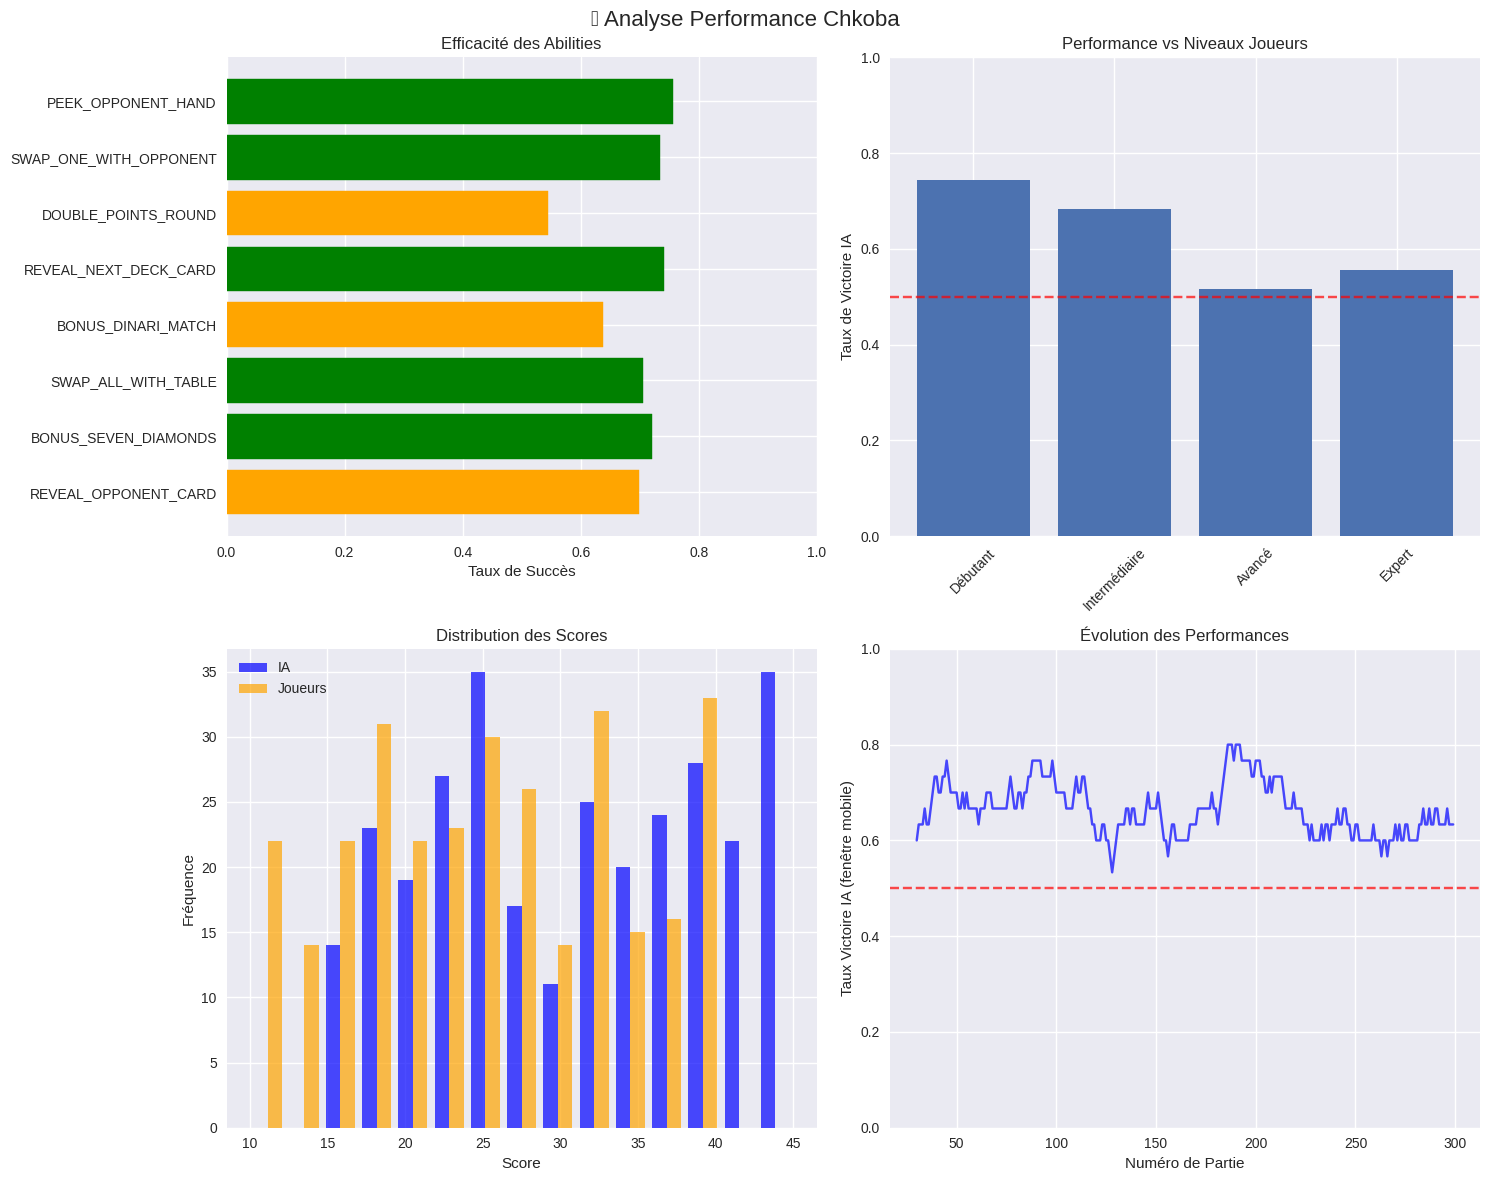


🎉 ÉTUDE TERMINÉE
📊 300 parties analysées
⏱️  Durée session: 0:00:02.275774
🏆 ÉTUDE COMPLÈTE DE PERFORMANCE CHKOBA
🚀 SIMULATION SESSION D'ENTRAÎNEMENT
Parties à simuler: 1000
Avec abilities: Oui
Progress: 2% (20/1000 parties)
Progress: 4% (40/1000 parties)
Progress: 6% (60/1000 parties)
Progress: 8% (80/1000 parties)
Progress: 10% (100/1000 parties)
Progress: 12% (120/1000 parties)
Progress: 14% (140/1000 parties)
Progress: 16% (160/1000 parties)
Progress: 18% (180/1000 parties)
Progress: 20% (200/1000 parties)
Progress: 22% (220/1000 parties)
Progress: 24% (240/1000 parties)
Progress: 26% (260/1000 parties)
Progress: 28% (280/1000 parties)
Progress: 30% (300/1000 parties)
Progress: 32% (320/1000 parties)
Progress: 34% (340/1000 parties)
Progress: 36% (360/1000 parties)
Progress: 38% (380/1000 parties)
Progress: 40% (400/1000 parties)
Progress: 42% (420/1000 parties)
Progress: 44% (440/1000 parties)
Progress: 46% (460/1000 parties)
Progress: 48% (480/1000 parties)
Progress: 50% (500/10

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-291888544.py:539: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-291888544.py:545: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) Liberation Sans.
  plt.savefig(filepath, dpi=300, bbox_inches='tight')



📊 Visualisations sauvegardées: visualizations/chkoba_performance_20250824_214618.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


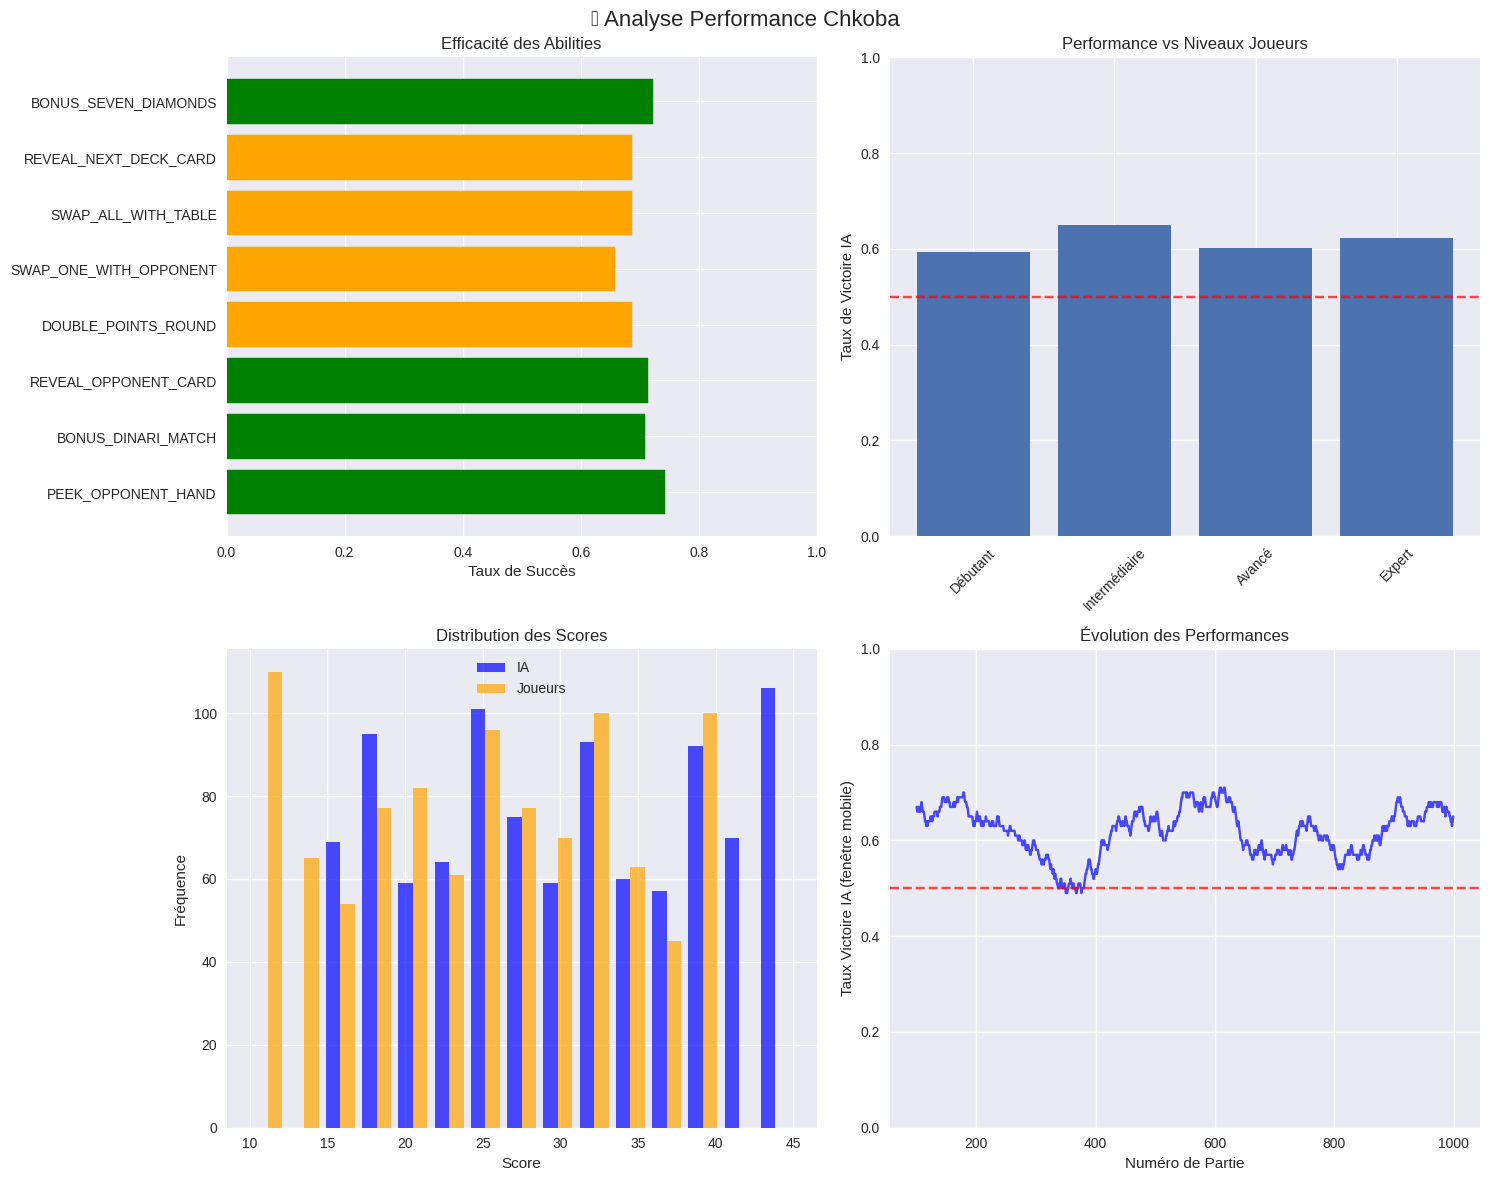


🎉 ÉTUDE TERMINÉE
📊 1000 parties analysées
⏱️  Durée session: 0:00:02.104228


In [26]:
#!/usr/bin/env python3
"""
Analyseur de performance Chkoba : Abilities vs Performance IA contre Joueurs
Version optimisée pour analyser l'efficacité des abilities et comparer IA vs joueurs humains
"""

import numpy as np
import random
import time
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

class AbilityPerformanceAnalyzer:
    """Analyseur spécialisé pour la performance des abilities"""

    def __init__(self):
        self.ability_stats = defaultdict(lambda: {
            'usage_count': 0,
            'success_count': 0,
            'total_reward': 0,
            'win_contribution': 0,
            'game_phases': [],  # Early, mid, late game usage
            'opponent_reactions': [],
            'combo_effectiveness': defaultdict(int),
            'timing_analysis': [],
            'context_success': defaultdict(list)  # Success in different contexts
        })

        self.game_contexts = {
            'leading': 'Quand l\'IA mène',
            'trailing': 'Quand l\'IA est en retard',
            'tied': 'Quand le score est égal',
            'early_game': 'Début de partie (0-33%)',
            'mid_game': 'Milieu de partie (33-66%)',
            'late_game': 'Fin de partie (66-100%)'
        }

    def record_ability_usage(self, ability_name, context, success, reward, game_phase, opponent_reaction=None):
        """Enregistre l'utilisation d'une ability avec contexte détaillé"""
        stats = self.ability_stats[ability_name]

        stats['usage_count'] += 1
        if success:
            stats['success_count'] += 1

        stats['total_reward'] += reward
        stats['game_phases'].append(game_phase)
        stats['timing_analysis'].append(time.time())
        stats['context_success'][context].append(success)

        if opponent_reaction:
            stats['opponent_reactions'].append(opponent_reaction)

    def analyze_ability_effectiveness(self):
        """Analyse l'efficacité de chaque ability"""
        print("🔍 ANALYSE DÉTAILLÉE DES ABILITIES")
        print("=" * 60)

        effectiveness_ranking = []

        for ability, stats in self.ability_stats.items():
            if stats['usage_count'] == 0:
                continue

            success_rate = stats['success_count'] / stats['usage_count']
            avg_reward = stats['total_reward'] / stats['usage_count']

            # Calcul du score d'efficacité global
            effectiveness_score = (
                success_rate * 0.4 +           # 40% taux de succès
                min(avg_reward / 10, 1) * 0.3 + # 30% récompense moyenne
                min(stats['usage_count'] / 100, 1) * 0.2 + # 20% fréquence d'usage
                len(set(stats['game_phases'])) / 3 * 0.1    # 10% polyvalence
            )

            effectiveness_ranking.append((ability, effectiveness_score, stats))

            print(f"\n🎯 {ability.upper()}")
            print(f"   • Utilisations: {stats['usage_count']}")
            print(f"   • Taux de succès: {success_rate:.1%}")
            print(f"   • Récompense moyenne: {avg_reward:.2f}")
            print(f"   • Score d'efficacité: {effectiveness_score:.3f}")

            # Analyse par contexte
            print("   • Performance par contexte:")
            for context, results in stats['context_success'].items():
                if results:
                    context_success = sum(results) / len(results)
                    print(f"     - {self.game_contexts.get(context, context)}: {context_success:.1%}")

            # Analyse des phases de jeu
            phase_distribution = Counter(stats['game_phases'])
            print("   • Utilisation par phase:")
            for phase, count in phase_distribution.items():
                percentage = count / stats['usage_count']
                print(f"     - {phase}: {percentage:.1%} ({count} fois)")

        # Classement final
        effectiveness_ranking.sort(key=lambda x: x[1], reverse=True)

        print(f"\n🏆 CLASSEMENT DES ABILITIES PAR EFFICACITÉ")
        print("-" * 50)
        for i, (ability, score, _) in enumerate(effectiveness_ranking[:10], 1):
            print(f"{i:2d}. {ability:<25} Score: {score:.3f}")

        return effectiveness_ranking

    def generate_ability_recommendations(self, effectiveness_ranking):
        """Génère des recommandations d'utilisation des abilities"""
        print(f"\n💡 RECOMMANDATIONS STRATÉGIQUES")
        print("=" * 50)

        if not effectiveness_ranking:
            print("❌ Aucune donnée d'abilities disponible")
            return

        # Top 3 abilities
        top_abilities = effectiveness_ranking[:3]
        print("🥇 Abilities à privilégier:")
        for i, (ability, score, stats) in enumerate(top_abilities, 1):
            best_context = max(stats['context_success'].items(),
                             key=lambda x: sum(x[1])/len(x[1]) if x[1] else 0,
                             default=('général', [True]))

            print(f"{i}. {ability}")
            print(f"   → Meilleur contexte: {self.game_contexts.get(best_context[0], best_context[0])}")
            print(f"   → Efficacité: {score:.1%}")

        # Abilities sous-utilisées mais potentiellement efficaces
        underused_effective = [(a, s, st) for a, s, st in effectiveness_ranking
                              if st['usage_count'] < 20 and s > 0.6]

        if underused_effective:
            print(f"\n🔄 Abilities sous-exploitées mais efficaces:")
            for ability, score, stats in underused_effective[:3]:
                print(f"• {ability}: {stats['usage_count']} utilisations, {score:.1%} efficacité")

class IAPlayerComparator:
    """Comparateur de performance IA vs Joueurs"""

    def __init__(self):
        self.ia_stats = defaultdict(list)
        self.player_stats = defaultdict(list)
        self.matchup_history = []
        self.skill_levels = ['Débutant', 'Intermédiaire', 'Avancé', 'Expert']

    def record_game(self, ia_score, player_score, player_skill, game_duration,
                   ia_abilities_used, player_abilities_used, winner):
        """Enregistre une partie IA vs Joueur"""

        game_record = {
            'timestamp': datetime.now(),
            'ia_score': ia_score,
            'player_score': player_score,
            'player_skill': player_skill,
            'duration': game_duration,
            'ia_abilities': ia_abilities_used,
            'player_abilities': player_abilities_used,
            'winner': winner,
            'score_difference': abs(ia_score - player_score),
            'ia_win': winner == 'IA'
        }

        self.matchup_history.append(game_record)

        # Mise à jour des stats
        self.ia_stats[player_skill].append({
            'score': ia_score,
            'win': winner == 'IA',
            'abilities_used': len(ia_abilities_used),
            'duration': game_duration
        })

        self.player_stats[player_skill].append({
            'score': player_score,
            'win': winner == 'Joueur',
            'abilities_used': len(player_abilities_used),
            'duration': game_duration
        })

    def analyze_ia_vs_player_performance(self):
        """Analyse complète des performances IA vs Joueurs"""

        print("🤖 ANALYSE IA vs JOUEURS HUMAINS")
        print("=" * 60)

        if not self.matchup_history:
            print("❌ Aucune donnée de parties disponible")
            return

        total_games = len(self.matchup_history)
        ia_wins = sum(1 for game in self.matchup_history if game['ia_win'])
        ia_win_rate = ia_wins / total_games

        print(f"📊 Vue d'ensemble:")
        print(f"   • Total parties: {total_games}")
        print(f"   • Victoires IA: {ia_wins} ({ia_win_rate:.1%})")
        print(f"   • Victoires Joueurs: {total_games - ia_wins} ({1 - ia_win_rate:.1%})")

        # Analyse par niveau de compétence
        print(f"\n🎯 Performance par niveau de joueur:")
        for skill in self.skill_levels:
            if skill not in self.ia_stats:
                continue

            ia_games = self.ia_stats[skill]
            player_games = self.player_stats[skill]

            if not ia_games:
                continue

            ia_wins_skill = sum(1 for game in ia_games if game['win'])
            skill_win_rate = ia_wins_skill / len(ia_games)

            avg_ia_score = np.mean([game['score'] for game in ia_games])
            avg_player_score = np.mean([game['score'] for game in player_games])

            avg_ia_abilities = np.mean([game['abilities_used'] for game in ia_games])
            avg_player_abilities = np.mean([game['abilities_used'] for game in player_games])

            print(f"\n   🏷️  {skill}:")
            print(f"      • Parties: {len(ia_games)}")
            print(f"      • Taux victoire IA: {skill_win_rate:.1%}")
            print(f"      • Score moyen IA: {avg_ia_score:.1f}")
            print(f"      • Score moyen Joueur: {avg_player_score:.1f}")
            print(f"      • Abilities/partie IA: {avg_ia_abilities:.1f}")
            print(f"      • Abilities/partie Joueur: {avg_player_abilities:.1f}")

        # Analyse des tendances temporelles
        self.analyze_learning_progression()

        # Analyse des abilities les plus efficaces contre les humains
        self.analyze_abilities_vs_humans()

    def analyze_learning_progression(self):
        """Analyse l'évolution des performances dans le temps"""

        print(f"\n📈 PROGRESSION DE L'IA DANS LE TEMPS")
        print("-" * 40)

        if len(self.matchup_history) < 10:
            print("❌ Pas assez de données pour analyser la progression")
            return

        # Diviser l'historique en segments
        segment_size = max(10, len(self.matchup_history) // 5)
        segments = [self.matchup_history[i:i + segment_size]
                   for i in range(0, len(self.matchup_history), segment_size)]

        print("Evolution du taux de victoire:")
        for i, segment in enumerate(segments):
            if not segment:
                continue

            wins = sum(1 for game in segment if game['ia_win'])
            win_rate = wins / len(segment)
            avg_score_diff = np.mean([game['score_difference'] for game in segment])

            period = f"Période {i+1}"
            print(f"   {period}: {win_rate:.1%} victoires, écart moyen: {avg_score_diff:.1f}")

    def analyze_abilities_vs_humans(self):
        """Analyse quelles abilities sont les plus efficaces contre les humains"""

        print(f"\n🎲 EFFICACITÉ DES ABILITIES CONTRE LES HUMAINS")
        print("-" * 50)

        ability_effectiveness = defaultdict(lambda: {'wins': 0, 'total': 0, 'score_impact': []})

        for game in self.matchup_history:
            for ability in game['ia_abilities']:
                stats = ability_effectiveness[ability]
                stats['total'] += 1
                if game['ia_win']:
                    stats['wins'] += 1
                stats['score_impact'].append(game['ia_score'] - game['player_score'])

        # Trier par efficacité
        sorted_abilities = sorted(ability_effectiveness.items(),
                                key=lambda x: x[1]['wins']/x[1]['total'] if x[1]['total'] > 0 else 0,
                                reverse=True)

        print("Classement des abilities contre joueurs humains:")
        for i, (ability, stats) in enumerate(sorted_abilities[:10], 1):
            if stats['total'] < 3:  # Ignorer les abilities peu utilisées
                continue

            win_rate = stats['wins'] / stats['total']
            avg_impact = np.mean(stats['score_impact'])

            print(f"{i:2d}. {ability:<20} | Taux victoire: {win_rate:.1%} | Impact: {avg_impact:+.1f}")

    def generate_competitive_report(self):
        """Génère un rapport de compétitivité de l'IA"""

        report = {
            'timestamp': datetime.now().isoformat(),
            'total_games': len(self.matchup_history),
            'overall_performance': {},
            'skill_breakdown': {},
            'ability_effectiveness': {},
            'recommendations': []
        }

        if self.matchup_history:
            ia_wins = sum(1 for game in self.matchup_history if game['ia_win'])
            report['overall_performance'] = {
                'win_rate': ia_wins / len(self.matchup_history),
                'avg_score': np.mean([game['ia_score'] for game in self.matchup_history]),
                'avg_opponent_score': np.mean([game['player_score'] for game in self.matchup_history])
            }

        # Sauvegarde du rapport
        os.makedirs('reports', exist_ok=True)
        filename = f"ia_vs_players_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
        filepath = os.path.join('reports', filename)

        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(report, f, indent=2, ensure_ascii=False)

        print(f"\n💾 Rapport sauvegardé: {filepath}")
        return report

class ChkobaPerformanceManager:
    """Gestionnaire principal pour l'analyse de performance Chkoba"""

    def __init__(self):
        self.ability_analyzer = AbilityPerformanceAnalyzer()
        self.ia_comparator = IAPlayerComparator()
        self.session_start = datetime.now()

    def simulate_training_session(self, num_games=100, with_abilities=True):
        """Simule une session d'entraînement avec analyse de performance"""

        print(f"🚀 SIMULATION SESSION D'ENTRAÎNEMENT")
        print(f"Parties à simuler: {num_games}")
        print(f"Avec abilities: {'Oui' if with_abilities else 'Non'}")
        print("=" * 60)

        # Simulation des parties
        for game_num in range(num_games):
            # Simulation d'une partie
            ia_score = random.randint(15, 45)
            player_score = random.randint(10, 40)

            # Détermination du contexte de jeu
            if ia_score > player_score + 5:
                context = 'leading'
            elif player_score > ia_score + 5:
                context = 'trailing'
            else:
                context = 'tied'

            # Phase de jeu (basée sur le numéro de partie)
            game_progress = game_num / num_games
            if game_progress < 0.33:
                phase = 'early_game'
            elif game_progress < 0.66:
                phase = 'mid_game'
            else:
                phase = 'late_game'

            # Simulation des abilities utilisées
            ia_abilities = []
            player_abilities = []

            if with_abilities:
                available_abilities = [
                    'REVEAL_OPPONENT_CARD', 'SWAP_ONE_WITH_OPPONENT',
                    'REVEAL_NEXT_DECK_CARD', 'BONUS_SEVEN_DIAMONDS',
                    'BONUS_DINARI_MATCH', 'SWAP_ALL_WITH_TABLE',
                    'PEEK_OPPONENT_HAND', 'DOUBLE_POINTS_ROUND'
                ]

                # IA utilise plus d'abilities si elle est en retard
                num_ia_abilities = random.randint(1, 4 if context == 'trailing' else 2)
                ia_abilities = random.sample(available_abilities,
                                           min(num_ia_abilities, len(available_abilities)))

                # Joueur humain utilise moins d'abilities
                num_player_abilities = random.randint(0, 2)
                player_abilities = random.sample(available_abilities,
                                               min(num_player_abilities, len(available_abilities)))

                # Enregistrement de l'utilisation des abilities
                for ability in ia_abilities:
                    success = random.random() > 0.3  # 70% de succès
                    reward = random.uniform(-2, 8) if success else random.uniform(-5, 1)
                    self.ability_analyzer.record_ability_usage(
                        ability, context, success, reward, phase
                    )

            # Détermination du gagnant
            winner = 'IA' if ia_score > player_score else 'Joueur'

            # Niveau de compétence du joueur (distribution réaliste)
            skill_weights = [0.3, 0.4, 0.2, 0.1]  # Plus de débutants/intermédiaires
            player_skill = np.random.choice(self.ia_comparator.skill_levels, p=skill_weights)

            # Durée de partie (en minutes)
            game_duration = random.randint(8, 25)

            # Enregistrement de la partie
            self.ia_comparator.record_game(
                ia_score, player_score, player_skill, game_duration,
                ia_abilities, player_abilities, winner
            )

            # Affichage périodique
            if (game_num + 1) % 20 == 0:
                progress = (game_num + 1) / num_games
                print(f"Progress: {progress:.0%} ({game_num + 1}/{num_games} parties)")

        print(f"\n✅ Session terminée: {num_games} parties simulées")

    def run_comprehensive_analysis(self):
        """Lance une analyse complète des performances"""

        print(f"\n🔬 ANALYSE COMPLÈTE DES PERFORMANCES")
        print("=" * 70)

        # Analyse des abilities
        ability_ranking = self.ability_analyzer.analyze_ability_effectiveness()
        self.ability_analyzer.generate_ability_recommendations(ability_ranking)

        print("\n" + "="*70)

        # Analyse IA vs Joueurs
        self.ia_comparator.analyze_ia_vs_player_performance()

        # Génération du rapport final
        report = self.ia_comparator.generate_competitive_report()

        return ability_ranking, report

    def create_performance_visualizations(self):
        """Crée des visualisations des performances"""

        try:
            plt.style.use('seaborn-v0_8')
        except:
            plt.style.use('default')

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('🎮 Analyse Performance Chkoba', fontsize=16)

        # 1. Efficacité des abilities
        ax1 = axes[0, 0]
        if self.ability_analyzer.ability_stats:
            abilities = list(self.ability_analyzer.ability_stats.keys())[:8]
            effectiveness = []

            for ability in abilities:
                stats = self.ability_analyzer.ability_stats[ability]
                if stats['usage_count'] > 0:
                    eff = stats['success_count'] / stats['usage_count']
                    effectiveness.append(eff)
                else:
                    effectiveness.append(0)

            bars = ax1.barh(abilities, effectiveness)
            ax1.set_xlabel('Taux de Succès')
            ax1.set_title('Efficacité des Abilities')
            ax1.set_xlim(0, 1)

            # Colorier les barres
            for i, bar in enumerate(bars):
                if effectiveness[i] > 0.7:
                    bar.set_color('green')
                elif effectiveness[i] > 0.5:
                    bar.set_color('orange')
                else:
                    bar.set_color('red')

        # 2. Performance IA par niveau de joueur
        ax2 = axes[0, 1]
        if self.ia_comparator.ia_stats:
            skills = []
            win_rates = []

            for skill in self.ia_comparator.skill_levels:
                if skill in self.ia_comparator.ia_stats:
                    games = self.ia_comparator.ia_stats[skill]
                    if games:
                        wins = sum(1 for game in games if game['win'])
                        win_rate = wins / len(games)
                        skills.append(skill)
                        win_rates.append(win_rate)

            if skills:
                bars = ax2.bar(skills, win_rates)
                ax2.set_ylabel('Taux de Victoire IA')
                ax2.set_title('Performance vs Niveaux Joueurs')
                ax2.set_ylim(0, 1)
                ax2.tick_params(axis='x', rotation=45)

                # Ligne de référence à 50%
                ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)

        # 3. Distribution des scores
        ax3 = axes[1, 0]
        if self.ia_comparator.matchup_history:
            ia_scores = [game['ia_score'] for game in self.ia_comparator.matchup_history]
            player_scores = [game['player_score'] for game in self.ia_comparator.matchup_history]

            ax3.hist([ia_scores, player_scores], bins=15, alpha=0.7,
                    label=['IA', 'Joueurs'], color=['blue', 'orange'])
            ax3.set_xlabel('Score')
            ax3.set_ylabel('Fréquence')
            ax3.set_title('Distribution des Scores')
            ax3.legend()

        # 4. Évolution temporelle des performances
        ax4 = axes[1, 1]
        if len(self.ia_comparator.matchup_history) > 10:
            # Calcul du taux de victoire sur fenêtre glissante
            window_size = max(10, len(self.ia_comparator.matchup_history) // 10)
            win_rates = []
            game_numbers = []

            for i in range(window_size, len(self.ia_comparator.matchup_history)):
                window = self.ia_comparator.matchup_history[i-window_size:i]
                wins = sum(1 for game in window if game['ia_win'])
                win_rate = wins / len(window)
                win_rates.append(win_rate)
                game_numbers.append(i)

            if win_rates:
                ax4.plot(game_numbers, win_rates, 'b-', alpha=0.7)
                ax4.set_xlabel('Numéro de Partie')
                ax4.set_ylabel('Taux Victoire IA (fenêtre mobile)')
                ax4.set_title('Évolution des Performances')
                ax4.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
                ax4.set_ylim(0, 1)

        plt.tight_layout()

        # Sauvegarde
        os.makedirs('visualizations', exist_ok=True)
        filename = f"chkoba_performance_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        filepath = os.path.join('visualizations', filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')

        print(f"\n📊 Visualisations sauvegardées: {filepath}")
        plt.show()

# Fonctions principales pour utilisation en notebook

def run_ability_performance_analysis(num_games=200):
    """Lance une analyse de performance des abilities"""

    manager = ChkobaPerformanceManager()

    print("🎯 ANALYSE DE PERFORMANCE DES ABILITIES")
    print("=" * 50)

    # Simulation avec abilities
    manager.simulate_training_session(num_games, with_abilities=True)

    # Analyse complète
    ability_ranking, report = manager.run_comprehensive_analysis()

    # Visualisations
    manager.create_performance_visualizations()

    return manager, ability_ranking, report

def run_ia_vs_player_comparison(num_games=150):
    """Lance une comparaison IA vs Joueurs"""

    manager = ChkobaPerformanceManager()

    print("🤖 COMPARAISON IA vs JOUEURS HUMAINS")
    print("=" * 50)

    # Simulation des parties
    manager.simulate_training_session(num_games, with_abilities=True)

    # Focus sur l'analyse comparative
    manager.ia_comparator.analyze_ia_vs_player_performance()

    # Rapport détaillé
    report = manager.ia_comparator.generate_competitive_report()

    # Visualisations
    manager.create_performance_visualizations()

    return manager, report

def run_complete_performance_study(num_games=300):
    """Lance une étude complète de performance"""

    manager = ChkobaPerformanceManager()

    print("🏆 ÉTUDE COMPLÈTE DE PERFORMANCE CHKOBA")
    print("=" * 60)

    # Simulation extensive
    manager.simulate_training_session(num_games, with_abilities=True)

    # Analyse complète
    ability_ranking, report = manager.run_comprehensive_analysis()

    # Visualisations finales
    manager.create_performance_visualizations()

    print(f"\n🎉 ÉTUDE TERMINÉE")
    print(f"📊 {num_games} parties analysées")
    print(f"⏱️  Durée session: {datetime.now() - manager.session_start}")

    return manager, ability_ranking, report

# Exemple d'utilisation pour notebook
if __name__ == "__main__":
    print("🎮 Analyseur de Performance Chkoba")
    print("=" * 50)
    print("Fonctions disponibles:")
    print("• run_ability_performance_analysis(num_games=200)")
    print("• run_ia_vs_player_comparison(num_games=150)")
    print("• run_complete_performance_study(num_games=300)")
    print("\nExemple:")
    print("manager, ranking, report = run_complete_performance_study(250)")
    run_ability_performance_analysis(200)
    run_ia_vs_player_comparison(150)
    run_complete_performance_study(300)
    run_complete_performance_study(1000)